In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
import numpy as np
from pyscf import dft
from functools import partial
import pylibxc
import pyscfad.dft as dftad
from jax import custom_jvp
jax.config.update("jax_enable_x64", True) #Enables 64 bit precision


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/dft/libxc.py:773: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


# Section: Training

In this section, we train exchange and correlation enhancement factors to fit to those of PBE.

Below are the PBE exchange and correlation enhancement factors, $F_X(\rho)$ and $F_C(\rho, s)$.

In [2]:
#Sampled points can be biased in favor of smaller values of s
# Define the enhancement factor functions (Fx and Fc)
def Fx(rho, grad_rho):
    #Equation 14 from PBE paper -- DOI: 10.1103/PhysRevLett.77.3865
    rho = jnp.maximum(1e-12, rho) #Prevents division by 0
    k_F = (3 * jnp.pi**2 * rho)**(1/3)
    s = grad_rho / (2 * k_F * rho)
    kappa, mu = 0.804, 0.21951

    Fx = 1 + kappa - kappa / (1 + mu * s**2 / kappa) #exchange enhancement factor

    return Fx

def Fc(rho, grad_rho): #Assumes zeta = 0
    #Equation 3 from PBE paper -- DOI: 10.1103/PhysRevLett.77.3865
    #Ec = Integral[ rho * (e_C^HEG + H) ]
    # H from equation 7
    # A from equation 8
    rho = jnp.maximum(1e-12, rho) #Prevents division by 0
    pi = jnp.pi
    k_F = (3 * pi**2 * rho)**(1/3)
    s = grad_rho / (2 * k_F * rho)
    k_s = jnp.sqrt((4 * k_F) / pi)
    t = jnp.abs(grad_rho) / (2 * k_s * rho)
    beta = 0.066725
    gamma = (1 - jnp.log(2)) / (pi**2)

    #Calculate e_heg_c (heterogeneous electron gas correlation energy)
    N = rho.size 
    rho_array = np.zeros((6, N))  # Initialize the rho_array with the correct shape. Only the first element (rho) matters, so the rest are populated with 0. 
    rho_array[0, :] = rho  # Populate first array value with rho
    e_heg_c = dft.libxc.eval_xc(',LDA_C_PW', rho_array, spin=0, deriv=1)[0]

    A = (beta / gamma) / (jnp.exp(-e_heg_c / (gamma)) - 1)

    H = gamma * jnp.log(1 + (beta / gamma) * t**2 * ((1 + A * t**2) / (1 + A * t**2 + A**2 * t**4)))

    Fc = 1 + (H / e_heg_c) #correlation enhancement factor

    return Fc

def pw91_correlation_energy_density(rho):
    """
    Calculate the correlation energy density according to the PW91 functional.

    Parameters:
    - rho: electron density (numpy array or scalar)
    - grad_rho: gradient of the electron density (numpy array or scalar)

    Returns:
    - correlation energy density (numpy array or scalar)
    """
    A = 0.0311
    B = 0.116
    C = 0.145
    
    # Compute the correlation energy density
    rho_1_3 = np.cbrt(rho)  # rho^(1/3)
    term1 = 1 / np.sqrt(1 + C / rho_1_3)
    epsilon_c = -A / rho * (1 + B * (term1 - 1))
    
    return epsilon_c    
def lda_c_pw(rho):
    params_a_pp     = [1,  1,  1]
    params_a_a      = [0.031091, 0.015545, 0.016887]
    params_a_alpha1 = [0.21370,  0.20548,  0.11125]
    params_a_beta1  = [7.5957, 14.1189, 10.357]
    params_a_beta2  = [3.5876, 6.1977, 3.6231]
    params_a_beta3  = [1.6382, 3.3662,  0.88026]
    params_a_beta4  = [0.49294, 0.62517, 0.49671]
    params_a_fz20   = 1.709921

    zeta = (rho - rho)/(rho + rho + 1e-8)
    rs = (4*np.pi*(rho + 1e-8)/3)**(-1/3)

    def g_aux(k, rs):
        return params_a_beta1[k]*jnp.sqrt(rs) + params_a_beta2[k]*rs\
      + params_a_beta3[k]*rs**1.5 + params_a_beta4[k]*rs**(params_a_pp[k] + 1)

    def g(k, rs):
        return -2*params_a_a[k]*(1 + params_a_alpha1[k]*rs)\
      * jnp.log(1 +  1/(2*params_a_a[k]*g_aux(k, rs)))

    def f_zeta(zeta):
        return ((1+zeta)**(4/3) + (1-zeta)**(4/3) - 2)/(2**(4/3)-2)

    def f_pw(rs, zeta):
        return g(0, rs) + zeta**4*f_zeta(zeta)*(g(1, rs) - g(0, rs) + g(2, rs)/params_a_fz20)\
      - f_zeta(zeta)*g(2, rs)/params_a_fz20

    return f_pw(rs, zeta)

def lda_x(rho):
    return -3/4*(3/jnp.pi)**(1/3)*rho**(1/3)

def pw92c(Dens, nspin=1):
    # Constants
    DENMIN = 1.e-12
    ONE = 1 + 1.e-12
    PI = jnp.pi
    # Parameters
    P = jnp.array([1.00, 1.00, 1.00])
    A = jnp.array([0.031091, 0.015545, 0.016887])
    ALPHA1 = jnp.array([0.21370, 0.20548, 0.11125])
    # MVFS test the transpose
    X = jnp.array([[7.5957, 14.1189, 10.357],
                      [3.5876, 6.1977, 3.6231],
                      [1.6382, 3.3662, 0.88026],
                      [0.49294, 0.62517, 0.49671]])
    BETA = jnp.transpose(X)
    # Calculate rs and zeta
    if nspin == 1:
        DTOT = jnp.maximum(DENMIN, Dens[0])
        ZETA = 0
        RS = (3 / (4 * PI * DTOT)) ** (1 / 3)
        DRSDD = -RS / DTOT / 3
        DZDD = jnp.array([0.0])
    else:
        DTOT = jnp.maximum(DENMIN, Dens[0] + Dens[1])
        ZETA = (Dens[0] - Dens[1]) / DTOT
        RS = (3 / (4 * PI * DTOT)) ** (1 / 3)
        DRSDD = -RS / DTOT / 3
        DZDD = jnp.array([(ONE - ZETA) / DTOT, - (ONE + ZETA) / DTOT])
    # Compute G and its derivatives
    G = jnp.zeros(3)
    DGDRS = jnp.zeros(3)
    for IG in range(3):
        B = BETA[IG, 0] * RS ** 0.5 + \
            BETA[IG, 1] * RS + \
            BETA[IG, 2] * RS ** 1.5 + \
            BETA[IG, 3] * RS ** (P[IG] + 1)
        DBDRS = BETA[IG, 0] * 0.5 / RS ** 0.5 + \
                BETA[IG, 1] + \
                BETA[IG, 2] * 1.5 * RS ** 0.5 + \
                BETA[IG, 3] * (P[IG] + 1) * RS ** P[IG]
        C = 1 + 1 / (2 * A[IG] * B)
        DCDRS = - ((C - 1) * DBDRS / B)
        Gtmp = (-2) * A[IG] * (1 + ALPHA1[IG] * RS) * jnp.log(C)
        DGDRStmp = (-2) * A[IG] * (ALPHA1[IG] * jnp.log(C) + \
                                    (1 + ALPHA1[IG] * RS) * DCDRS / C)
        G = G.at[IG].set(Gtmp)
        DGDRS = DGDRS.at[IG].set(DGDRStmp)
    # Find f’’(0) and f(zeta)
    C = 1 / (2 ** (4 / 3) - 2)
    FPP0 = 8 * C / 9
    F = ((ONE + ZETA) ** (4 / 3) + (ONE - ZETA) ** (4 / 3) - 2) * C
    DFDZ = (4 / 3) * ((ONE + ZETA) ** (1 / 3) - (ONE - ZETA) ** (1 / 3)) * C
    # Compute EC and VC
    EC = G[0] - G[2] * F / FPP0 * (ONE - ZETA ** 4) + \
         (G[1] - G[0]) * F * ZETA ** 4
    DECDRS = DGDRS[0] - DGDRS[2] * F / FPP0 * (ONE - ZETA ** 4) + \
             (DGDRS[1] - DGDRS[0]) * F * ZETA ** 4
    DECDZ = (-G[2]) / FPP0 * (DFDZ * (ONE - ZETA ** 4) - F * 4 * ZETA ** 3) + \
            (G[1] - G[0]) * (DFDZ * ZETA ** 4 + F * 4 * ZETA ** 3)
    # Calculate correlation potential
    if nspin == 1:
        DECDD = DECDRS * DRSDD
        VC = jnp.array([EC + DTOT * DECDD])
    else:
        DECDD = jnp.array([DECDRS * DRSDD + DECDZ * DZDD[0],
                           DECDRS * DRSDD + DECDZ * DZDD[1]])
        VC = jnp.array([EC + DTOT * DECDD[0],
                        EC + DTOT * DECDD[1]])
    return EC, VC

def pw92c_unpolarized(rho):
    """
    Implements the Perdew-Wang '92 local correlation (beyond RPA) for the unpolarized case.
    Reference: J.P.Perdew & Y.Wang, PRB, 45, 13244 (1992)
    
    Parameters:
    rho : jax.numpy array
        Total electron density array on a grid.

    Returns:
    EC : jax.numpy array
        Correlation energy density array.
    """
    # Ensure rho is a jax.numpy array
    rho = jnp.asarray(rho)

    # Parameters from Table I of Perdew & Wang, PRB, 45, 13244 (92)
    A = jnp.array([0.031091, 0.015545, 0.016887])
    ALPHA1 = jnp.array([0.21370, 0.20548, 0.11125])
    BETA1 = jnp.array([7.5957, 14.1189, 10.357])
    BETA2 = jnp.array([3.5876, 6.1977, 3.6231])
    BETA3 = jnp.array([1.6382, 3.3662, 0.88026])
    BETA4 = jnp.array([0.49294, 0.62517, 0.49671])

    # Compute rs (Wigner-Seitz radius) for each grid point
    rs = (3 / (4 * jnp.pi * rho))**(1/3)

    # Compute G for unpolarized case (zeta = 0) across all grid points
    def compute_g(rs):
        try:
            G = jnp.zeros((len(rs), 3))
        except:
            G = jnp.zeros((1, 3))
        for k in range(3):
            B = (BETA1[k] * jnp.sqrt(rs) +
                 BETA2[k] * rs +
                 BETA3[k] * rs**1.5 +
                 BETA4[k] * rs**2)
            C = 1 + 1 / (2 * A[k] * B)
            G = G.at[:, k].set(-2 * A[k] * (1 + ALPHA1[k] * rs) * jnp.log(C))
        return G

    # Apply compute_g to each grid point
    G = compute_g(rs)

    # For unpolarized case, correlation energy density is G[0]
    EC = G[:, 0]

    return EC


# Including Constraints

There are various constraints which xc-diff and xcquinox are encoded to respect:
- Correct uniform density scaling behavior for $E_x$, which is enforced through dropping local-density inputs to the exchange enhancement factor (here, this means the `FxNet` should only depend on the gradient)
- At $s=0$, the UEG limit should be obtained. If the XC energy density is obtained through multiplying the enhancement factors by the UEG exchange/correlation energy densities, this means that $F_x(s=0)=1$ and $F_c(s=0)=1$.
- [Lieb-Oxford bound for the GGA enhancement factor](https://sci-hub.se/https://doi.org/10.1063/1.4870763) is $F_x^\mathrm{GGA}(s) < 1.804$; for the [MGGA enhancement factor](https://www.pnas.org/doi/epdf/10.1073/pnas.1423145112) is $F_x(s,\alpha) \leq F_x(s,\alpha=0) \leq 1.174$
- Correlation energy is non-positive, so the correlation enhancement factor must be non-negative: $F_c(s,\dots) \geq 0$.
- The exchange energy is negative, so the exchange enhancement factor must be postive: $F_x(s) \geq 0$.

However, these constraints only apply to the actual enhancement factors, **not** a function that predicts a Z-score that will be distribution dependent on whatever training data you train with. As such, I don't train to the Z-scores below as was done above.

The simplest way to enforce both the upper (Lieb-Oxford) and lower (positivity requirements) bounds are to pass the network outputs through a modified sigmoid function. xc-diff and xcquinox do this with the following modified sigmoid -- it enforces the domain to be within $[-1, a-1]$ via $$I_a(x) = \frac{a}{1+(a-1)\exp^{-x}} -1,\ \ I_a(0)=0,$$ and then adds one in the "definition" of the enhancement factor, i.e.: $$F_x(\tilde{x}_2,\tilde{x}_3) = 1 + I_{1.174}[(\tilde{x}_2+\tanh^2\tilde{x}_3)\mathcal{F}(\tilde{x}_2,\tilde{x}_3,\vec{\omega}_x)],$$ where the $(\tilde{x}_2+\tanh^2\tilde{x}_3)$ ensures the UEG limit is recovered for $s=x_2=\tilde{x}_2=0$ at $\alpha=x_3=1\to\tilde{x}_3=0$. $F_c$ is similarly constrained via $I_2(x)$, such that the end result lies in the range $[0, 1]$.

We are currently only concerned with GGAs as a start, so we'll omit the linear $s$ terms and just assume that $$F_x(s) = 1+I_{1.804}[\tanh^2(s)\cdot \mathcal{F}(s,\vec{\omega}_x)]$$ and $$F_c(\rho,s) = 1+I_2[\tanh^2(s)\cdot \mathcal{F}(\rho, s,\vec{\omega}_c)],$$ as $\tanh^2(x)\to0$ as $x\to 0$. It would be valid to omit the $\tanh$ terms and keep the linear $s$ terms, as they will equivalently vanish at the appropriate limit, but since $\tanh^2(x)$ saturates to $\sim 1$ as $x\sim 2$, we keep the $\tanh$ dependence.

Try to modify the sigmoid wrapping to avoid nans. In running the above interfaces, there were a few `NaN`s appearing in the gradients, potentially due to the [sigmoid wrapping](https://stackoverflow.com/questions/68290850/jax-autograd-of-a-sigmoid-always-returns-nan). As such, below here I re-implement that constraining function to avoid such issues.

In [3]:
#Define the equinox module for the Lieb-Oxford bound enforcement
class LOB2(eqx.Module):
    limit: float

    def __init__(self, limit: float):
        self.limit = limit

    def __call__(self, x):
        #this formulation is so that the constraints can be enforced while avoiding potential gradient issues with the sigmoid
        return self.limit * jax.nn.sigmoid(x-jnp.log(self.limit - 1))-1

# THE BELOW TWO NETWORKS ARE TRAINED USING THE REDUCED DENSITY GRADIENT s
# Define the neural network module for Fx
class FxNetS(eqx.Module):
    depth: int
    nodes: int
    seed: int
    lob_lim: float
    net: eqx.nn.MLP
    lobf: eqx.Module

    def __init__(self, depth: int, nodes: int, seed: int, lob_lim=1.804):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.lob_lim = lob_lim
        #to constrain this, we require only gradient inputs
        self.net = eqx.nn.MLP(in_size = 1, # Input is ONLY s
                              out_size = 1, # Output is Fx
                              depth = self.depth,
                              width_size = self.nodes,
                              activation = jax.nn.gelu,
                              key = jax.random.PRNGKey(self.seed))
        self.lobf = LOB2(limit=lob_lim)

    

    def __call__(self, inputs):
        #here, assume the inputs is [rho, s] and select the appropriate input
        #takes forever if inputs[1] tanh input has extended shape , i.e. (1,1) as opposed to scalar shape (1,)
        return 1+self.lobf((jnp.tanh(inputs[1])**2)*self.net(inputs[1, jnp.newaxis]).squeeze())


# Define the neural network module for Fc
class FcNetS(eqx.Module):
    depth: int
    nodes: int
    seed: int
    lob_lim: float
    net: eqx.nn.MLP
    lobf: eqx.Module


    def __init__(self, depth: int, nodes: int, seed: int, lob_lim=2.0):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.lob_lim = lob_lim
        self.net = eqx.nn.MLP(in_size = 2, # Input is rho, s
                              out_size = 1, # Output is Fx
                              depth = self.depth,
                              width_size = self.nodes,
                              activation = jax.nn.gelu,
                              key = jax.random.PRNGKey(self.seed))
        self.lobf = LOB2(limit=lob_lim)

    def __call__(self, inputs):
        #here, assume the inputs is [rho, s] and select the appropriate input
        #takes forever if inputs[1] tanh input has extended shape , i.e. (1,1) as opposed to scalar shape (1,)
        return 1+self.lobf((jnp.tanh(inputs[1])**2)*self.net(inputs).squeeze())


# THE BELOW TWO NETWORKS ARE TRAINED USING THE DENSITY GRADIENT,
# BUT THE NETWORK IS STILL PARAMETRIZED USING s AS AN INPUT
# Define the neural network module for Fx
class FxNetG(eqx.Module):
    depth: int
    nodes: int
    seed: int
    lob_lim: float
    net: eqx.nn.MLP
    lobf: eqx.Module

    def __init__(self, depth: int, nodes: int, seed: int, lob_lim=1.804):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.lob_lim = lob_lim
        #to constrain this, we require only gradient inputs
        self.net = eqx.nn.MLP(in_size = 1, # Input is ONLY s
                              out_size = 1, # Output is Fx
                              depth = self.depth,
                              width_size = self.nodes,
                              activation = jax.nn.gelu,
                              key = jax.random.PRNGKey(self.seed))
        self.lobf = LOB2(limit=lob_lim)

    

    def __call__(self, inputs):
        #here, assume the inputs is [rho, grad] and select the appropriate input
        #takes forever if inputs[1] tanh input has extended shape , i.e. (1,1) as opposed to scalar shape (1,)
        rho = jnp.maximum(1e-12, inputs[0]) #Prevents division by 0
        rho = rho.flatten()
        # print('rho shape', rho.shape)
        k_F = (3 * jnp.pi**2 * rho)**(1/3)
        # grad_rho = jnp.sqrt(dx**2 + dy**2 + dz**2) 
        s = inputs[1].flatten() / (2 * k_F * rho)
        # print('s shape', s.shape)
        s = s.flatten()
        tanhterm = jnp.tanh(s)**2
        netterm = self.net(s)
        lobterm = self.lobf( tanhterm*netterm )
        # print('jnp.tanh(s)**2', tanhterm.shape)
        # print('self.net(s[:, jnp.newaxis]', netterm.shape)
        # print('self.lobf( (tanhterm**2)*netterm )', lobterm.shape)
        return 1+lobterm.squeeze()


# Define the neural network module for Fc
class FcNetG(eqx.Module):
    depth: int
    nodes: int
    seed: int
    lob_lim: float
    net: eqx.nn.MLP
    lobf: eqx.Module


    def __init__(self, depth: int, nodes: int, seed: int, lob_lim=2.0):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.lob_lim = lob_lim
        self.net = eqx.nn.MLP(in_size = 2, # Input is rho, s
                              out_size = 1, # Output is Fx
                              depth = self.depth,
                              width_size = self.nodes,
                              activation = jax.nn.gelu,
                              key = jax.random.PRNGKey(self.seed))
        self.lobf = LOB2(limit=lob_lim)

    def __call__(self, inputs):
        #here, assume the inputs is [rho, grad] and select the appropriate input
        #takes forever if inputs[1] tanh input has extended shape , i.e. (1,1) as opposed to scalar shape (1,)
        rho = jnp.maximum(1e-12, inputs[0]) #Prevents division by 0
        rho = rho.flatten()
        # print('rho shape', rho.shape)
        k_F = (3 * jnp.pi**2 * rho)**(1/3)
        # grad_rho = jnp.sqrt(dx**2 + dy**2 + dz**2) 
        s = inputs[1].flatten() / (2 * k_F * rho)
        # print('s shape', s.shape)
        s = s.flatten()
        netinp = jnp.stack([rho, s], axis=0).flatten()
        # print('netinp shape', netinp.shape)
        tanhterm = jnp.tanh(s)**2
        netterm = self.net(netinp)
        lobterm = self.lobf( tanhterm*netterm )
        # print('jnp.tanh(s)**2', tanhterm.shape)
        # print('self.net(netinp[:, jnp.newaxis])', netterm.shape)
        # print('self.lobf( (tanhterm**2)*netterm )', lobterm.shape)
        return 1+lobterm.squeeze()

# ---- MODEL ARCHITECTURES BELOW ARE FOR TRAINING ON (rho, sigma) 
# ---- __call__ function depends on (rho, sigma) but network itself depends on (rho, s) explicitly here
# Define the neural network module for Fx
class FxNetGsig(eqx.Module):
    depth: int
    nodes: int
    seed: int
    lob_lim: float
    net: eqx.nn.MLP
    lobf: eqx.Module

    def __init__(self, depth: int, nodes: int, seed: int, lob_lim=1.804):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.lob_lim = lob_lim
        #to constrain this, we require only gradient inputs
        self.net = eqx.nn.MLP(in_size = 1, # Input is ONLY s
                              out_size = 1, # Output is Fx
                              depth = self.depth,
                              width_size = self.nodes,
                              activation = jax.nn.gelu,
                              key = jax.random.PRNGKey(self.seed))
        self.lobf = LOB2(limit=lob_lim)

    

    def __call__(self, inputs):
        #here, assume the inputs is [rho, grad] and select the appropriate input
        #takes forever if inputs[1] tanh input has extended shape , i.e. (1,1) as opposed to scalar shape (1,)
        rho = jnp.maximum(1e-12, inputs[0]) #Prevents division by 0
        rho = rho.flatten()
        sigma = jnp.maximum(1e-12, inputs[1]) #Prevents division by 0
        sigma = sigma.flatten()
        # print('rho shape', rho.shape)
        k_F = (3 * jnp.pi**2 * rho)**(1/3)
        # grad_rho = jnp.sqrt(dx**2 + dy**2 + dz**2) 
        s = jnp.sqrt(sigma) / (2 * k_F * rho)
        # print('s shape', s.shape)
        s = s.flatten()
        tanhterm = jnp.tanh(s)**2
        netterm = self.net(s)
        lobterm = self.lobf( tanhterm*netterm )
        # print('jnp.tanh(s)**2', tanhterm.shape)
        # print('self.net(s[:, jnp.newaxis]', netterm.shape)
        # print('self.lobf( (tanhterm**2)*netterm )', lobterm.shape)
        return 1+lobterm.squeeze()


# Define the neural network module for Fc
class FcNetGsig(eqx.Module):
    depth: int
    nodes: int
    seed: int
    lob_lim: float
    net: eqx.nn.MLP
    lobf: eqx.Module


    def __init__(self, depth: int, nodes: int, seed: int, lob_lim=2.0):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.lob_lim = lob_lim
        self.net = eqx.nn.MLP(in_size = 2, # Input is rho, s
                              out_size = 1, # Output is Fc
                              depth = self.depth,
                              width_size = self.nodes,
                              activation = jax.nn.gelu,
                              key = jax.random.PRNGKey(self.seed))
        self.lobf = LOB2(limit=lob_lim)

    def __call__(self, inputs):
        #here, assume the inputs is [rho, grad] and select the appropriate input
        #takes forever if inputs[1] tanh input has extended shape , i.e. (1,1) as opposed to scalar shape (1,)
        rho = jnp.maximum(1e-12, inputs[0]) #Prevents division by 0
        rho = rho.flatten()
        sigma = jnp.maximum(1e-12, inputs[1]) #Prevents division by 0
        sigma = sigma.flatten()
        # print('rho shape', rho.shape)
        k_F = (3 * jnp.pi**2 * rho)**(1/3)
        # grad_rho = jnp.sqrt(dx**2 + dy**2 + dz**2) 
        s = jnp.sqrt(sigma) / (2 * k_F * rho)
        # print('s shape', s.shape)
        s = s.flatten()
        netinp = jnp.stack([rho, s], axis=0).flatten()
        # print('netinp shape', netinp.shape)
        tanhterm = jnp.tanh(s)**2
        netterm = self.net(netinp)
        lobterm = self.lobf( tanhterm*netterm )
        # print('jnp.tanh(s)**2', tanhterm.shape)
        # print('self.net(netinp[:, jnp.newaxis])', netterm.shape)
        # print('self.lobf( (tanhterm**2)*netterm )', lobterm.shape)
        return 1+lobterm.squeeze()


In [18]:
def gen_grid_s(npts=50000, start_stop_rho = (0.01, 5), start_stop_s = (0.01, 5)):
    '''
    Generates a grid of rho, grad_rho, and reduced_density_gradient values and returns their flattened forms to be fed into a given enhancement factor function for training or validation purposes.

    :param npts: Number of points to generate in each array, defaults to 30000. The function will get close, but not necessarily exactly the number of points, unless the desired value is a perfect square.
    :type npts: int, optional
    :param start_stop_rho: Bounds for the generated reduced_density_gradient values, defaults to (0.01, 5)
    :type start_stop_rho: tuple, optional
    :param start_stop_s: Bounds for the generated rho values, defaults to (0.01, 5)
    :type start_stop_s: tuple, optional
    :return: The flattened density, grad_rho, and s arrays
    :rtype: 3-tuple: (rho_flat, grad_rho_flat, s_flat)
    '''
    START_RHO, STOP_RHO = start_stop_rho
    START_S, STOP_S = start_stop_s
    s_values_low = jnp.linspace(START_S, 0.5, num=int(0.7 * jnp.sqrt(npts)))
    s_values_high = jnp.linspace(0.5, STOP_S, num=int(0.3 * jnp.sqrt(npts)))
    s_values = jnp.concatenate([s_values_low, s_values_high])
    rho_values = jnp.logspace(jnp.log10(START_RHO), jnp.log10(STOP_RHO), num=int(jnp.sqrt(npts)))
    rho_mesh, s_mesh = jnp.meshgrid(rho_values, s_values)
    rho_flat = rho_mesh.flatten()
    s_flat = s_mesh.flatten()
    # Calculate grad_rho
    k_F = (3 * jnp.pi**2 * rho_flat)**(1/3)
    grad_rho_flat = 2 * s_flat * k_F * rho_flat
    print('shapes- r/gr/s: {}/{}/{}'.format(rho_flat.shape, grad_rho_flat.shape, s_flat.shape))
    return (rho_flat, grad_rho_flat, s_flat)

r, gr, s = gen_grid_s(npts = 1e5)

shapes- r/gr/s: (99540,)/(99540,)/(99540,)


In [89]:
# NPTS = 30000  # Note: Number of grid points [i.e. (x,y) pairs] is actually sqrt(NPTS).

# # Generate test points
# NUM_RHO = 1000  # Number of different rho values to test
# NUM_S = 1000  # Number of s values for each rho

# START_S, STOP_S = 0.01, 5  # Adjust these values as needed
# START_RHO, STOP_RHO = 0.01, 5  # Range of rho values to test

# test_s = jnp.linspace(START_S, STOP_S, num=NPTS)
# test_rho = jnp.linspace(START_RHO, STOP_RHO, num=NPTS)

# # Generate training data
# # Create more points for small values of s
# s_values_low = jnp.linspace(START_S, 0.5, num=int(0.7 * jnp.sqrt(NPTS)))
# s_values_high = jnp.linspace(0.5, STOP_S, num=int(0.3 * jnp.sqrt(NPTS)))
# s_values = jnp.concatenate([s_values_low, s_values_high])

# rho_values = jnp.logspace(jnp.log10(START_RHO), jnp.log10(STOP_RHO), num=int(jnp.sqrt(NPTS)))
# #s_values = jnp.linspace(START_S, STOP_S, num=int(jnp.sqrt(NPTS))) #Use this for unbiased sampling

# rho_mesh, s_mesh = jnp.meshgrid(rho_values, s_values)
# rho_flat = rho_mesh.flatten()
# s_flat = s_mesh.flatten()

# # Calculate grad_rho
# k_F = (3 * jnp.pi**2 * rho_flat)**(1/3)
# grad_rho_flat = 2 * s_flat * k_F * rho_flat

# Create input array
# inputs = jnp.stack([rho_flat, grad_rho_flat], axis=1)
# sinputs = jnp.stack([rho_flat, s_flat], axis=1)
inputs = jnp.stack([r, gr], axis=1)
sinputs = jnp.stack([r, s], axis=1)

# Calculate true Fx and Fc values
# true_fx = Fx(rho_flat, grad_rho_flat)
# true_fc = Fc(rho_flat, grad_rho_flat)
true_fx = Fx(r, gr)
true_fc = Fc(r, gr)

# # Normalize inputs and outputs
# inputs_mean = inputs.mean(axis=0)
# inputs_std = inputs.std(axis=0)
# inputs_normalized = (inputs - inputs_mean) / (inputs_std + 1e-8)

# true_fx_mean = true_fx.mean()
# true_fx_std = true_fx.std()
# true_fx_normalized = (true_fx - true_fx_mean) / (true_fx_std + 1e-8)

# true_fc_mean = true_fc.mean()
# true_fc_std = true_fc.std()
# true_fc_normalized = (true_fc - true_fc_mean) / (true_fc_std + 1e-8)

# Define the training loop function
def loop(model, model_name, inputs, ref, optimizer, epochs=1000000, printevery=2500): #model_name is just for printing purposes
    @eqx.filter_value_and_grad
    def compute_loss(model, inputs, ref):
        pred = jax.vmap(model)(inputs)
        loss = jnp.mean(jnp.abs(pred - ref))
        return loss

    @eqx.filter_jit
    def make_step(model, inputs, ref, opt_state):
        loss, grad = compute_loss(model, inputs, ref)
        print('LOSS', loss)
        print('GRAD', grad)
        updates, opt_state = optimizer.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state
    print(f"Starting training for model: {model_name}")
    
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    losses = []

    for step in range(epochs):
        print(step)
        loss, model, opt_state = make_step(model, inputs, ref, opt_state)
        print('OPT_STATE', opt_state)
        lossi = loss.item()
        losses.append(lossi)
        if step % printevery == 0:
            print(f'Epoch {step}: Loss = {lossi}')

    return model, losses

# Create optimizers
optimizer_fx = optax.chain(
    optax.adam(learning_rate=1e-3)
)
optimizer_fc = optax.chain(
    optax.adam(learning_rate=1e-3)
)

model_fxs = FxNetS(depth=3, nodes=16, seed=42)
model_fcs = FcNetS(depth=3, nodes=16, seed=42)

# Train the Fx model -- Fx(s)
model_fxs, losses_fxs = loop(model_fxs, 'Fx', sinputs, true_fx, optimizer_fx, epochs=1000, printevery=100) #Can adjust number of epochs 

# Train the Fc model -- Fc(rho, s)
model_fcs, losses_fcs = loop(model_fcs, 'Fc', sinputs, true_fc, optimizer_fc, epochs=1000, printevery=100) #Can adjust number of epochs 


Starting training for model: Fx
0
LOSS Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>
GRAD FxNetS(
  depth=None,
  nodes=None,
  seed=None,
  lob_lim=None,
  net=MLP(
    layers=(
      Linear(
        weight=f64[16,1],
        bias=f64[16],
        in_features=1,
        out_features=16,
        use_bias=True
      ),
      Linear(
        weight=f64[16,16],
        bias=f64[16],
        in_features=16,
        out_features=16,
        use_bias=True
      ),
      Linear(
        weight=f64[16,16],
        bias=f64[16],
        in_features=16,
        out_features=16,
        use_bias=True
      ),
      Linear(
        weight=f64[1,16],
        bias=f64[1],
        in_features=16,
        out_features=1,
        use_bias=True
      )
    ),
    activation=None,
    final_activation=None,
    use_bias=True,
    use_final_bias=True,
    in_size=1,
    out_size=1,
    width_size=16,
    depth=3
  ),
  lobf=LOB2(limit=None)
)
OPT_STATE ((ScaleByAdamState(count=Array(1, 

KeyboardInterrupt: 

In [110]:
from typing import Callable
class Pretrainer(eqx.Module):
    model: eqx.Module
    optim: optax.GradientTransformation
    steps: int
    print_every: int
    opt_state: tuple
    inputs: jnp.array
    ref: jnp.array
    loss: Callable

    def __init__(self, model, optim, inputs, ref, loss, steps=1000, print_every=100):
        super().__init__()
        self.model = model
        self.optim = optim
        self.inputs = inputs
        self.ref = ref
        self.steps = steps
        self.print_every = print_every
        self.opt_state = self.optim.init(eqx.filter(self.model, eqx.is_array))
        self.loss = loss

    def __call__(self):
        losses = []
        for epoch in range(self.steps):
            if epoch == 0:
                this_model = self.model
                this_opt_state = self.opt_state
            loss, this_model, this_opt_state = self.make_step(this_model, self.inputs, self.ref, this_opt_state)
            lossi = loss.item()
            losses.append(lossi)
            if epoch % self.print_every == 0:
                print(f'Epoch {epoch}: Loss = {lossi}')

        return this_model, losses

    @eqx.filter_jit
    def make_step(self, model, inputs, ref, opt_state):
        loss, grad = self.loss(model, inputs, ref)
        updates, opt_state = self.optim.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

@eqx.filter_value_and_grad
def compute_loss_mae(model, inputs, ref):
    pred = jax.vmap(model)(inputs)
    loss = jnp.mean(jnp.abs(pred - ref))
    return loss



In [111]:
pt_x = Pretrainer(model = model_fxs, optim = optimizer_fx, inputs = sinputs, ref = true_fx, loss=compute_loss_mae)
nm, nml = pt_x()

Epoch 0: Loss = 0.17332152672311749
Epoch 100: Loss = 0.009041407194608463
Epoch 200: Loss = 0.0004877682584667767
Epoch 300: Loss = 0.00026189996573210687


KeyboardInterrupt: 

Below we test our fits to the enhancement factors only.

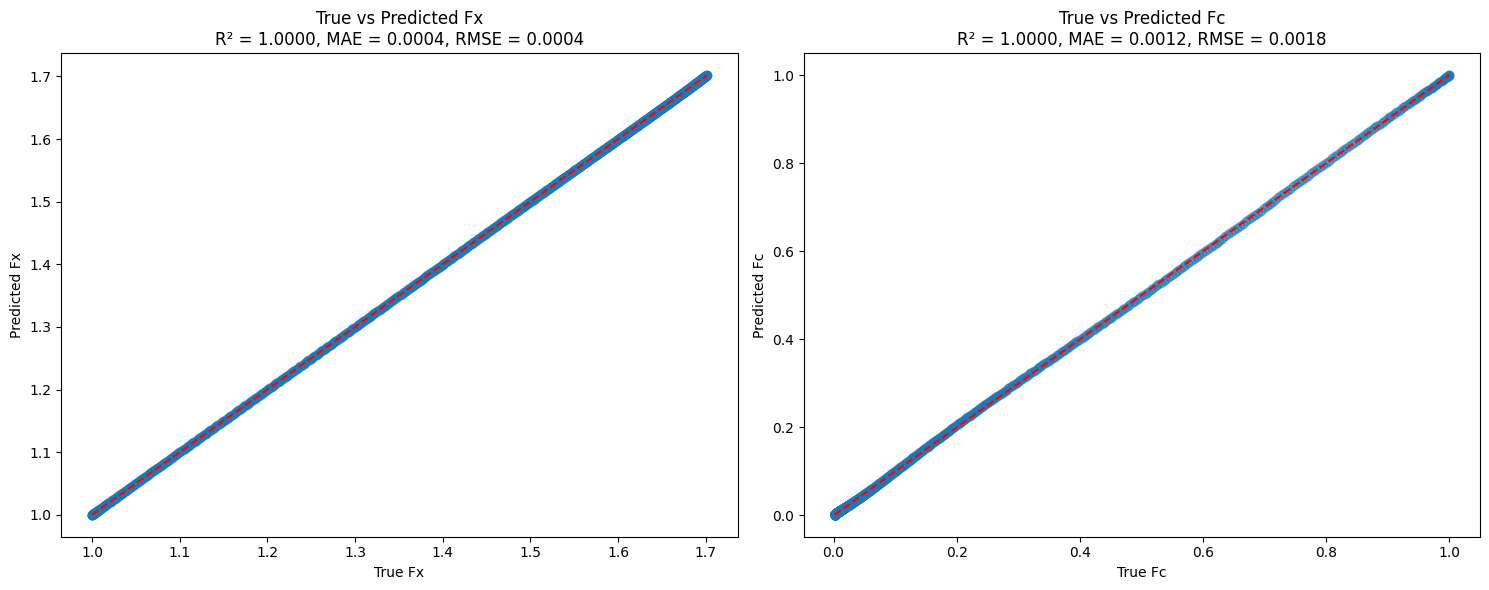

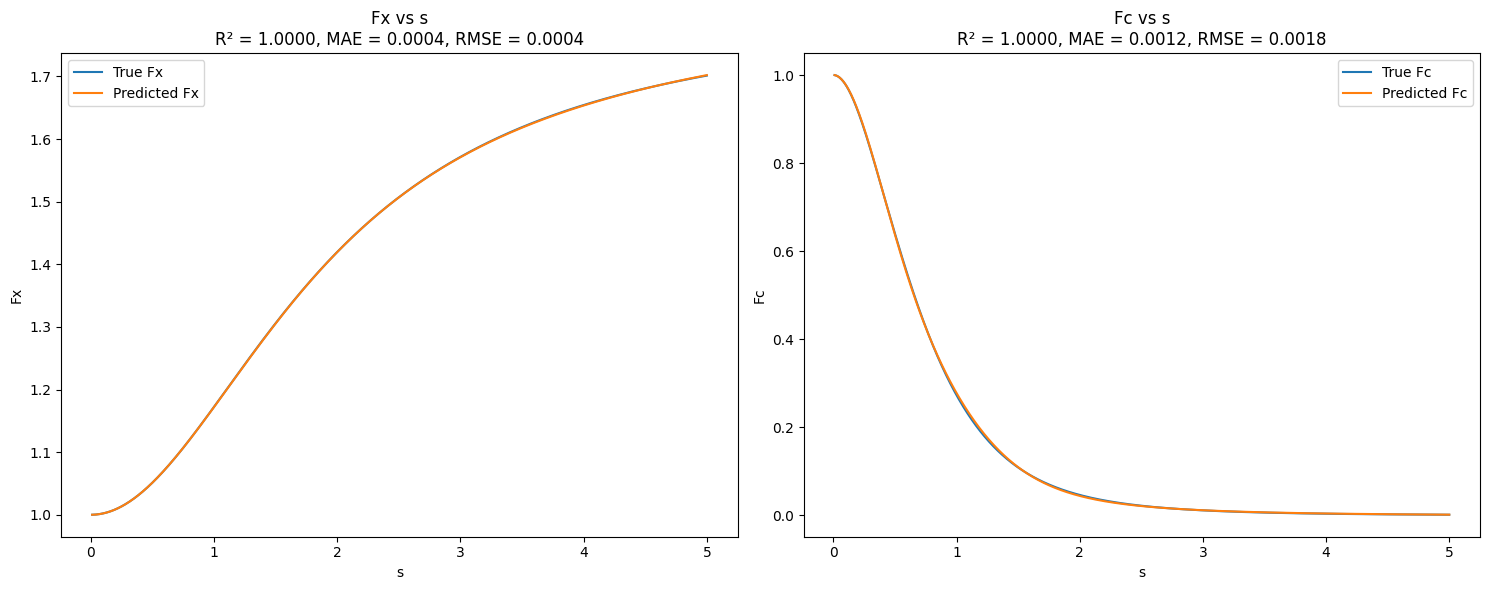

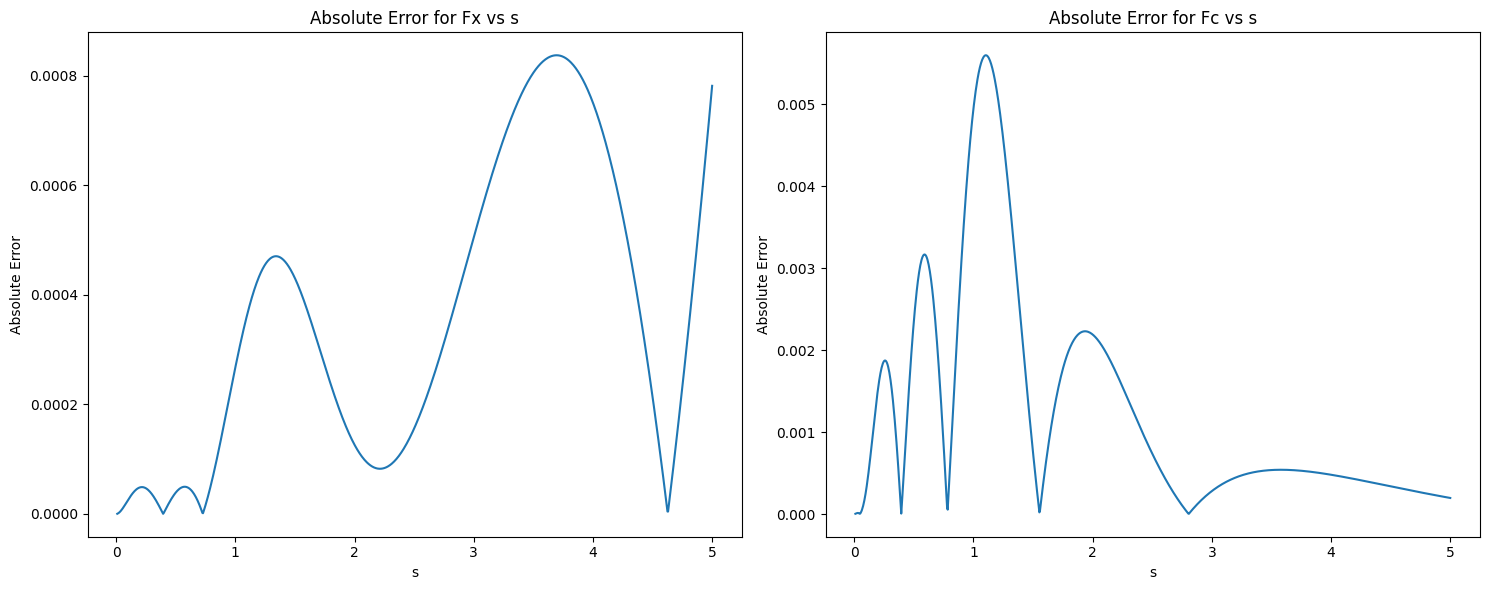

Fx Statistics:
R-squared: 0.999996
Mean Absolute Error: 0.000355
Root Mean Squared Error: 0.000445
Maximum Absolute Error: 0.000837

Fc Statistics:
R-squared: 0.999953
Mean Absolute Error: 0.001242
Root Mean Squared Error: 0.001834
Maximum Absolute Error: 0.005595


In [22]:
NPTS = 30000  # Note: Number of grid points [i.e. (x,y) pairs] is actually sqrt(NPTS).

# Generate test points
NUM_RHO = 1000  # Number of different rho values to test
NUM_S = 1000  # Number of s values for each rho

START_S, STOP_S = 0.01, 5  # Adjust these values as needed
START_RHO, STOP_RHO = 0.01, 5  # Range of rho values to test



# Generate test points
test_s = jnp.linspace(START_S, STOP_S, num=1000)
test_rho = jnp.full_like(test_s, 1.0)  # We'll use a constant rho for simplicity

# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * test_rho)**(1/3)
grad_rho_test = 2 * test_s * k_F_test * test_rho

# Prepare inputs for the neural networks
test_inputs = jnp.stack([test_rho, grad_rho_test], axis=1)
test_sinputs = jnp.stack([test_rho, test_s], axis=1)
# test_inputs_normalized = (test_inputs - inputs_mean) / (inputs_std + 1e-8)

# Calculate true PBE enhancement factors
true_fx_test = Fx(test_rho, grad_rho_test)
true_fc_test = Fc(test_rho, grad_rho_test)

# Predict using neural networks
#NOTE -- the inputs here ARE the s values, not the grad_rho values
pred_fx = jax.vmap(model_fxs)(test_s[:, jnp.newaxis]).squeeze()
# pred_fx = jax.vmap(model_fx2)(grad_rho_test[:, jnp.newaxis]).squeeze()

#The inputs here 
pred_fc = jax.vmap(model_fcs)(test_sinputs).squeeze()

# Function to calculate statistics
def calculate_stats(true, pred):
    # R-squared
    ss_res = np.sum((true - pred) ** 2)
    ss_tot = np.sum((true - np.mean(true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(true - pred))
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean((true - pred) ** 2))
    
    return r2, mae, rmse

# Calculate statistics
r2_fx, mae_fx, rmse_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc = calculate_stats(true_fc_test, pred_fc)

# 1. Correlation plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(true_fx_test, pred_fx, alpha=0.5)
ax1.plot([true_fx_test.min(), true_fx_test.max()], [true_fx_test.min(), true_fx_test.max()], 'r--')
ax1.set_xlabel('True Fx')
ax1.set_ylabel('Predicted Fx')
ax1.set_title(f'True vs Predicted Fx\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')

ax2.scatter(true_fc_test, pred_fc, alpha=0.5)
ax2.plot([true_fc_test.min(), true_fc_test.max()], [true_fc_test.min(), true_fc_test.max()], 'r--')
ax2.set_xlabel('True Fc')
ax2.set_ylabel('Predicted Fc')
ax2.set_title(f'True vs Predicted Fc\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')

plt.tight_layout()
plt.show()

# 2. True PBE factors vs. s
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, true_fx_test, label='True Fx')
ax1.plot(test_s, pred_fx, label='Predicted Fx')
ax1.set_xlabel('s')
ax1.set_ylabel('Fx')
ax1.set_title(f'Fx vs s\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')
ax1.legend()

ax2.plot(test_s, true_fc_test, label='True Fc')
ax2.plot(test_s, pred_fc, label='Predicted Fc')
ax2.set_xlabel('s')
ax2.set_ylabel('Fc')
ax2.set_title(f'Fc vs s\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')
ax2.legend()

plt.tight_layout()
plt.show()

# 3. Error plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, np.abs(true_fx_test - pred_fx))
ax1.set_xlabel('s')
ax1.set_ylabel('Absolute Error')
ax1.set_title('Absolute Error for Fx vs s')

ax2.plot(test_s, np.abs(true_fc_test - pred_fc))
ax2.set_xlabel('s')
ax2.set_ylabel('Absolute Error')
ax2.set_title('Absolute Error for Fc vs s')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {np.max(np.abs(true_fx_test - pred_fx)):.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {np.max(np.abs(true_fc_test - pred_fc)):.6f}")

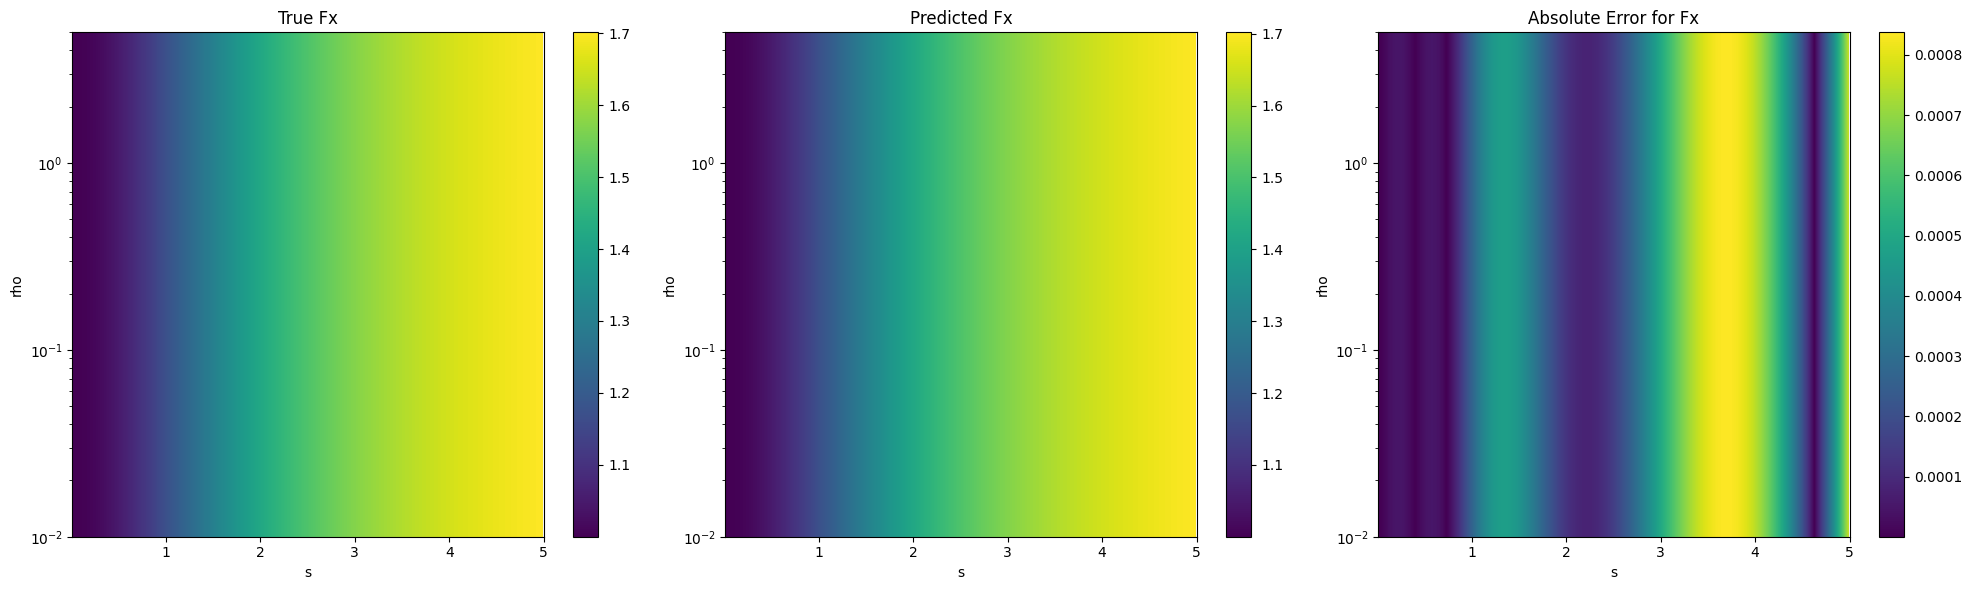

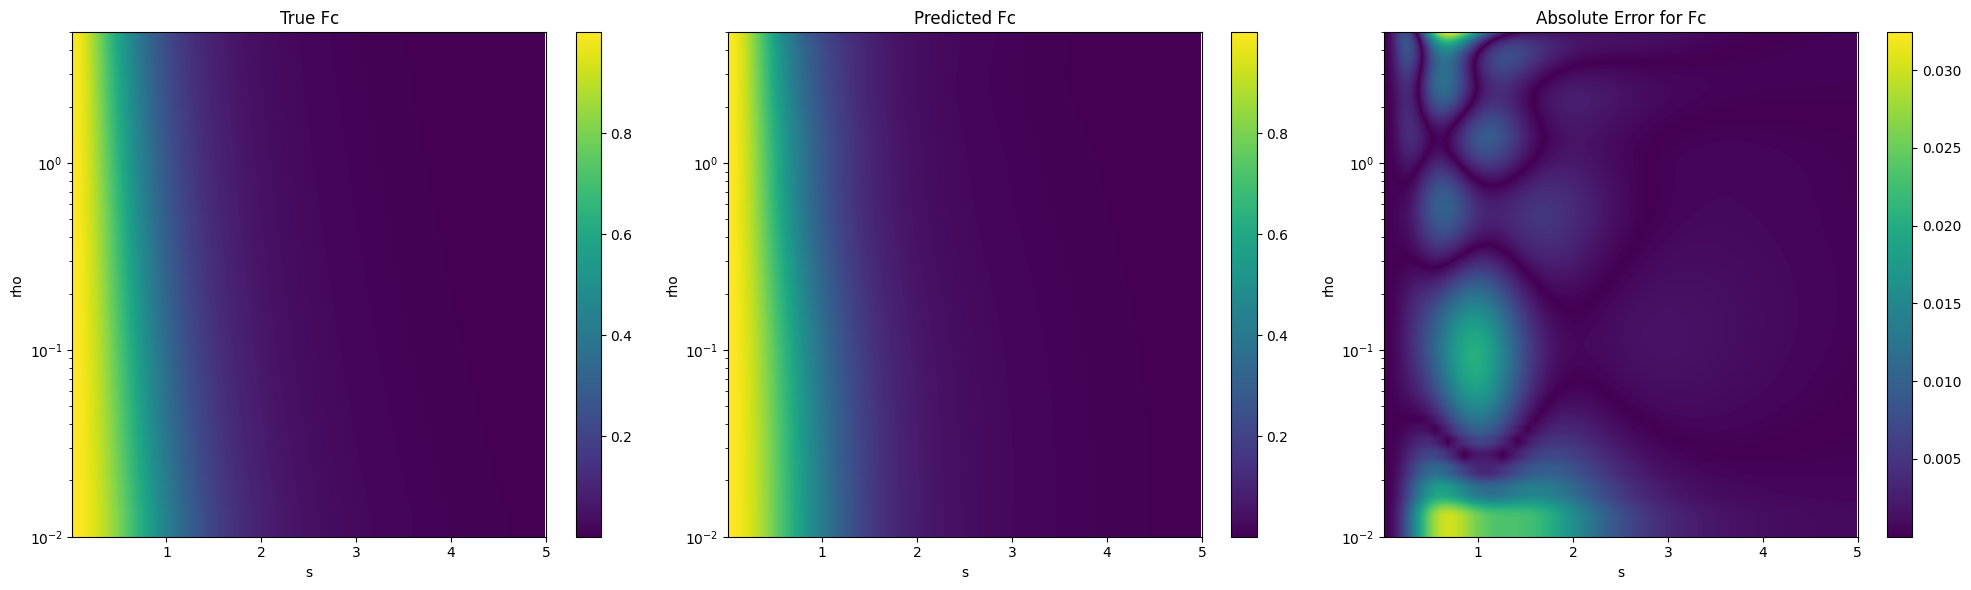

Fx Statistics:
R-squared: 0.999996
Mean Absolute Error: 0.000355
Root Mean Squared Error: 0.000445
Maximum Absolute Error: 0.000837

Fc Statistics:
R-squared: 0.999750
Mean Absolute Error: 0.002197
Root Mean Squared Error: 0.004176
Maximum Absolute Error: 0.032438


In [24]:
# Generate test points
NUM_RHO = 1000  # Number of different rho values to test
NUM_S = 1000  # Number of s values for each rho

START_S, STOP_S = 0.01, 5  # Adjust these values as needed
START_RHO, STOP_RHO = 0.01, 5  # Range of rho values to test

test_s = jnp.linspace(START_S, STOP_S, num=NUM_S)
test_rho = jnp.linspace(START_RHO, STOP_RHO, num=NUM_RHO)

# Create meshgrid for s and rho
s_mesh, rho_mesh = jnp.meshgrid(test_s, test_rho)

# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * rho_mesh)**(1/3)
grad_rho_test = 2 * s_mesh * k_F_test * rho_mesh

# Prepare inputs for the neural networks
test_inputs = jnp.stack([rho_mesh.flatten(), grad_rho_test.flatten()], axis=1)
test_sinputs = jnp.stack([rho_mesh.flatten(), s_mesh.flatten()], axis=1)
# test_inputs_normalized = (test_inputs - inputs_mean) / (inputs_std + 1e-8)

# Calculate true PBE enhancement factors
true_fx_test = Fx(rho_mesh.flatten(), grad_rho_test.flatten())
true_fc_test = Fc(rho_mesh.flatten(), grad_rho_test.flatten())

# Predict using neural networks
# pred_fx_normalized = jax.vmap(model_fx)(test_inputs_normalized).squeeze()
# pred_fx = pred_fx_normalized * true_fx_std + true_fx_mean
pred_fx = jax.vmap(model_fxs)(s_mesh.flatten()[:, jnp.newaxis])

# pred_fc_normalized = jax.vmap(model_fc)(test_inputs_normalized).squeeze()
# pred_fc = pred_fc_normalized * true_fc_std + true_fc_mean
pred_fc = jax.vmap(model_fcs)(test_sinputs)

# Reshape results
true_fx_test = true_fx_test.reshape(NUM_RHO, NUM_S)
true_fc_test = true_fc_test.reshape(NUM_RHO, NUM_S)
pred_fx = pred_fx.reshape(NUM_RHO, NUM_S)
pred_fc = pred_fc.reshape(NUM_RHO, NUM_S)

# Function to calculate statistics
def calculate_stats(true, pred):
    true_flat = true.flatten()
    pred_flat = pred.flatten()
    
    # R-squared
    ss_res = np.sum((true_flat - pred_flat) ** 2)
    ss_tot = np.sum((true_flat - np.mean(true_flat)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(true_flat - pred_flat))
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean((true_flat - pred_flat) ** 2))
    
    # Maximum Absolute Error
    max_error = np.max(np.abs(true_flat - pred_flat))
    
    return r2, mae, rmse, max_error

# Calculate statistics
r2_fx, mae_fx, rmse_fx, max_error_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc, max_error_fc = calculate_stats(true_fc_test, pred_fc)

# Plotting
def plot_heatmap(true, pred, title, rho_values, s_values):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    im1 = ax1.imshow(true, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax1.set_title(f'True {title}')
    ax1.set_xlabel('s')
    ax1.set_ylabel('rho')
    ax1.set_yscale('log')
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(pred, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax2.set_title(f'Predicted {title}')
    ax2.set_xlabel('s')
    ax2.set_ylabel('rho')
    ax2.set_yscale('log')
    fig.colorbar(im2, ax=ax2)
    
    error = np.abs(true - pred)
    im3 = ax3.imshow(error, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax3.set_title(f'Absolute Error for {title}')
    ax3.set_xlabel('s')
    ax3.set_ylabel('rho')
    ax3.set_yscale('log')
    fig.colorbar(im3, ax=ax3)
    
    plt.tight_layout()
    plt.show()

# Plot heatmaps
plot_heatmap(true_fx_test, pred_fx, 'Fx', test_rho, test_s)
plot_heatmap(true_fc_test, pred_fc, 'Fc', test_rho, test_s)

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {max_error_fx:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {max_error_fc:.6f}")

## Below, we train FxNetG and FcNetG

These networks are to demonstrate how one would instead rely on inputs of $(\rho, |\nabla\rho|)$ as opposed to the above inputs of $(\rho,s)$. The network itself is still dependent on input $s$ values, but the function takes $(\rho,|\nabla\rho|)$ and generates the corresponding $s$ value to feed to the network, allowing us to take gradients of the output energy density with respect to the density gradient, as opposed to $s$.

In [7]:
NPTS = 30000  # Note: Number of grid points [i.e. (x,y) pairs] is actually sqrt(NPTS).

# Generate test points
NUM_RHO = 1000  # Number of different rho values to test
NUM_S = 1000  # Number of s values for each rho

START_S, STOP_S = 0.01, 5  # Adjust these values as needed
START_RHO, STOP_RHO = 0.01, 5  # Range of rho values to test

test_s = jnp.linspace(START_S, STOP_S, num=NPTS)
test_rho = jnp.linspace(START_RHO, STOP_RHO, num=NPTS)

# Generate training data
# Create more points for small values of s
s_values_low = jnp.linspace(START_S, 0.5, num=int(0.7 * jnp.sqrt(NPTS)))
s_values_high = jnp.linspace(0.5, STOP_S, num=int(0.3 * jnp.sqrt(NPTS)))
s_values = jnp.concatenate([s_values_low, s_values_high])

rho_values = jnp.logspace(jnp.log10(START_RHO), jnp.log10(STOP_RHO), num=int(jnp.sqrt(NPTS)))
#s_values = jnp.linspace(START_S, STOP_S, num=int(jnp.sqrt(NPTS))) #Use this for unbiased sampling

rho_mesh, s_mesh = jnp.meshgrid(rho_values, s_values)
rho_flat = rho_mesh.flatten()
s_flat = s_mesh.flatten()

# Calculate grad_rho
k_F = (3 * jnp.pi**2 * rho_flat)**(1/3)
grad_rho_flat = 2 * s_flat * k_F * rho_flat

# Create input array
inputs = jnp.stack([rho_flat, grad_rho_flat], axis=1)
sinputs = jnp.stack([rho_flat, s_flat], axis=1)

# Calculate true Fx and Fc values
true_fx = Fx(rho_flat, grad_rho_flat)
true_fc = Fc(rho_flat, grad_rho_flat)

# Normalize inputs and outputs
inputs_mean = inputs.mean(axis=0)
inputs_std = inputs.std(axis=0)
inputs_normalized = (inputs - inputs_mean) / (inputs_std + 1e-8)

true_fx_mean = true_fx.mean()
true_fx_std = true_fx.std()
true_fx_normalized = (true_fx - true_fx_mean) / (true_fx_std + 1e-8)

true_fc_mean = true_fc.mean()
true_fc_std = true_fc.std()
true_fc_normalized = (true_fc - true_fc_mean) / (true_fc_std + 1e-8)

# Define the training loop function
def loop(model, model_name, inputs, ref, optimizer, epochs=1000000, printevery=2500): #model_name is just for printing purposes
    @eqx.filter_value_and_grad
    def compute_loss(model, inputs, ref):
        pred = jax.vmap(model)(inputs)
        loss = jnp.mean(jnp.abs(pred - ref))
        return loss

    @eqx.filter_jit
    def make_step(model, inputs, ref, opt_state):
        loss, grad = compute_loss(model, inputs, ref)
        updates, opt_state = optimizer.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state
    print(f"Starting training for model: {model_name}")
    
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    losses = []

    for step in range(epochs):
        loss, model, opt_state = make_step(model, inputs, ref, opt_state)
        lossi = loss.item()
        losses.append(lossi)
        if step % printevery == 0:
            print(f'Epoch {step}: Loss = {lossi}')

    return model, losses

# Create optimizers
optimizer_fx = optax.chain(
    optax.adam(learning_rate=1e-3)
)
optimizer_fc = optax.chain(
    optax.adam(learning_rate=1e-3)
)

model_fxg = FxNetG(depth=3, nodes=16, seed=42)
model_fcg = FcNetG(depth=3, nodes=16, seed=42)

# Train the Fx model -- Fx(s)
model_fxg, losses_fxg = loop(model_fxg, 'Fx', inputs, true_fx, optimizer_fx, epochs=5000, printevery=100) #Can adjust number of epochs 

# Train the Fc model -- Fc(rho, s)
model_fcg, losses_fcg = loop(model_fcg, 'Fc', inputs, true_fc, optimizer_fc, epochs=5000, printevery=100) #Can adjust number of epochs 


Starting training for model: Fx
Epoch 0: Loss = 0.1720148024971639
Epoch 100: Loss = 0.00897189529988701
Epoch 200: Loss = 0.000415473940210338
Epoch 300: Loss = 0.0002659195474472434
Epoch 400: Loss = 0.00021032480170918438
Epoch 500: Loss = 0.0004211246666722107
Epoch 600: Loss = 0.0001518460867766321
Epoch 700: Loss = 0.00012651692413859675
Epoch 800: Loss = 0.00029470721752719066
Epoch 900: Loss = 0.00021367057794970823
Epoch 1000: Loss = 0.0003806253110166315
Epoch 1100: Loss = 0.00031396786172684863
Epoch 1200: Loss = 0.0001735424005038429
Epoch 1300: Loss = 8.236852724035745e-05
Epoch 1400: Loss = 0.00017757969482675625
Epoch 1500: Loss = 0.00016798057982571438
Epoch 1600: Loss = 0.000401110064559652
Epoch 1700: Loss = 0.00046535582803580375
Epoch 1800: Loss = 0.0002595712130950247
Epoch 1900: Loss = 0.000280276663607721
Epoch 2000: Loss = 0.0002796524566990366
Epoch 2100: Loss = 0.00010332342980454359
Epoch 2200: Loss = 0.00033065360339227124
Epoch 2300: Loss = 0.00058857119728

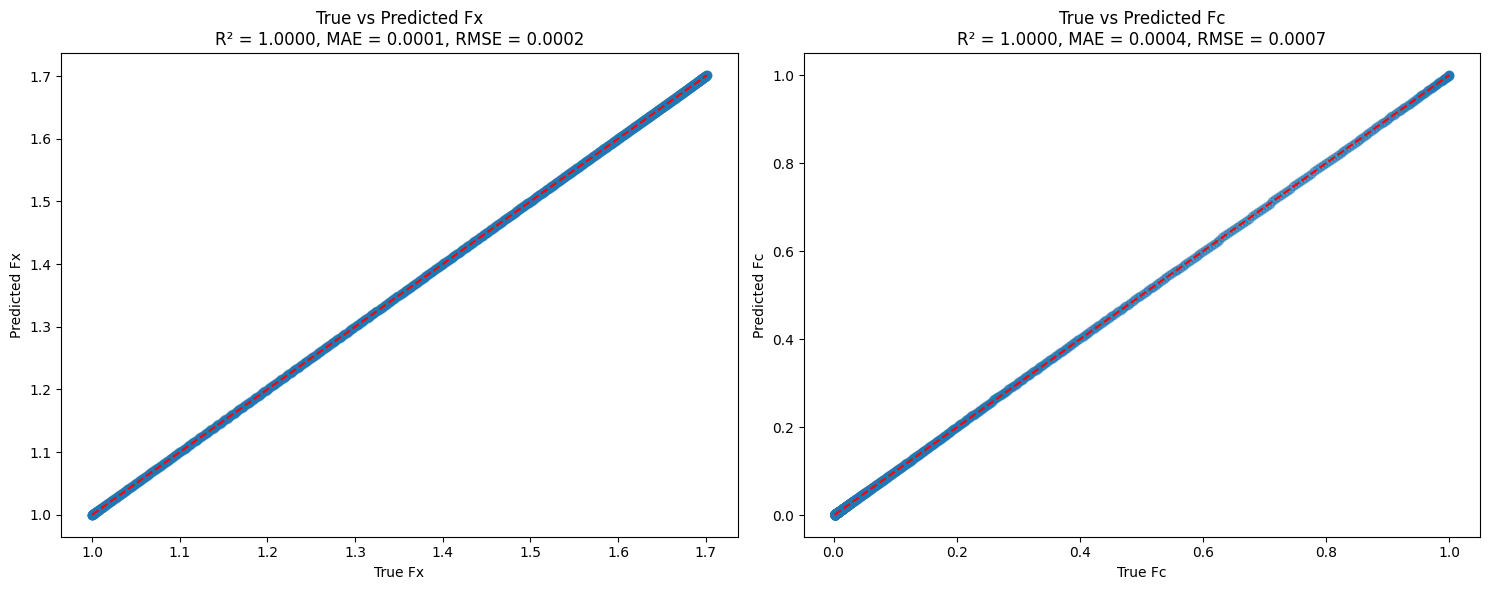

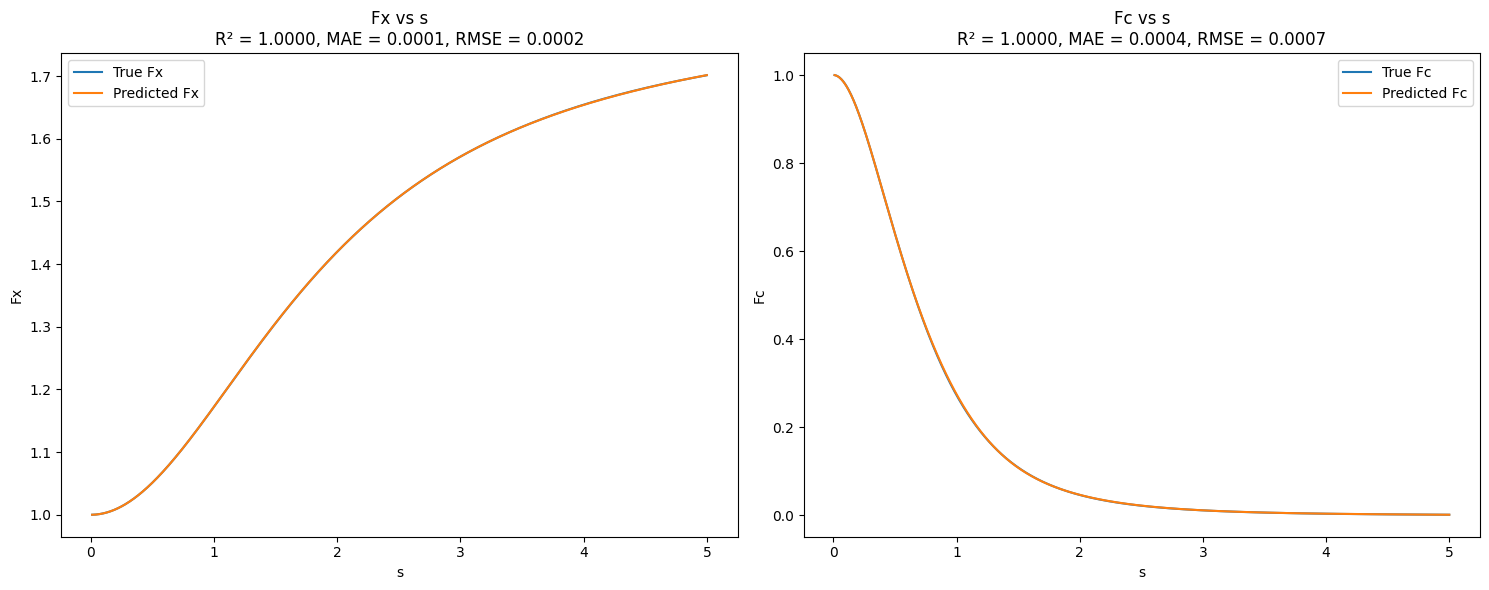

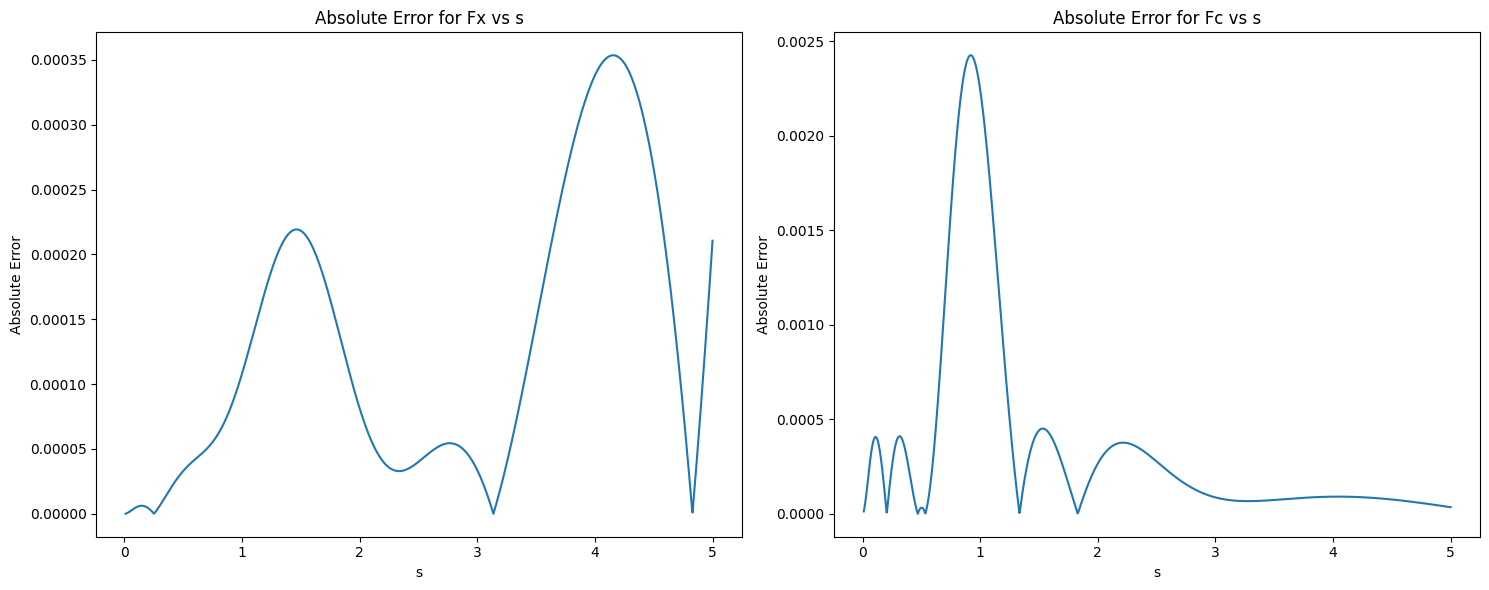

Fx Statistics:
R-squared: 0.999999
Mean Absolute Error: 0.000128
Root Mean Squared Error: 0.000167
Maximum Absolute Error: 0.000354

Fc Statistics:
R-squared: 0.999994
Mean Absolute Error: 0.000352
Root Mean Squared Error: 0.000655
Maximum Absolute Error: 0.002426


In [8]:
# Generate test points
test_s = jnp.linspace(START_S, STOP_S, num=1000)
test_rho = jnp.full_like(test_s, 1.0)  # We'll use a constant rho for simplicity

# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * test_rho)**(1/3)
grad_rho_test = 2 * test_s * k_F_test * test_rho

# Prepare inputs for the neural networks
test_inputs = jnp.stack([test_rho, grad_rho_test], axis=1)
test_sinputs = jnp.stack([test_rho, test_s], axis=1)
test_inputs_normalized = (test_inputs - inputs_mean) / (inputs_std + 1e-8)

# Calculate true PBE enhancement factors
true_fx_test = Fx(test_rho, grad_rho_test)
true_fc_test = Fc(test_rho, grad_rho_test)

# Predict using neural networks
#NOTE -- the inputs here ARE the s values, not the grad_rho values
pred_fx = jax.vmap(model_fxg)(test_inputs).squeeze()
# pred_fx = jax.vmap(model_fx2)(grad_rho_test[:, jnp.newaxis]).squeeze()

#The inputs here 
pred_fc = jax.vmap(model_fcg)(test_inputs).squeeze()

# Function to calculate statistics
def calculate_stats(true, pred):
    # R-squared
    ss_res = np.sum((true - pred) ** 2)
    ss_tot = np.sum((true - np.mean(true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(true - pred))
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean((true - pred) ** 2))
    
    return r2, mae, rmse

# Calculate statistics
r2_fx, mae_fx, rmse_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc = calculate_stats(true_fc_test, pred_fc)

# 1. Correlation plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(true_fx_test, pred_fx, alpha=0.5)
ax1.plot([true_fx_test.min(), true_fx_test.max()], [true_fx_test.min(), true_fx_test.max()], 'r--')
ax1.set_xlabel('True Fx')
ax1.set_ylabel('Predicted Fx')
ax1.set_title(f'True vs Predicted Fx\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')

ax2.scatter(true_fc_test, pred_fc, alpha=0.5)
ax2.plot([true_fc_test.min(), true_fc_test.max()], [true_fc_test.min(), true_fc_test.max()], 'r--')
ax2.set_xlabel('True Fc')
ax2.set_ylabel('Predicted Fc')
ax2.set_title(f'True vs Predicted Fc\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')

plt.tight_layout()
plt.show()

# 2. True PBE factors vs. s
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, true_fx_test, label='True Fx')
ax1.plot(test_s, pred_fx, label='Predicted Fx')
ax1.set_xlabel('s')
ax1.set_ylabel('Fx')
ax1.set_title(f'Fx vs s\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')
ax1.legend()

ax2.plot(test_s, true_fc_test, label='True Fc')
ax2.plot(test_s, pred_fc, label='Predicted Fc')
ax2.set_xlabel('s')
ax2.set_ylabel('Fc')
ax2.set_title(f'Fc vs s\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')
ax2.legend()

plt.tight_layout()
plt.show()

# 3. Error plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, np.abs(true_fx_test - pred_fx))
ax1.set_xlabel('s')
ax1.set_ylabel('Absolute Error')
ax1.set_title('Absolute Error for Fx vs s')

ax2.plot(test_s, np.abs(true_fc_test - pred_fc))
ax2.set_xlabel('s')
ax2.set_ylabel('Absolute Error')
ax2.set_title('Absolute Error for Fc vs s')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {np.max(np.abs(true_fx_test - pred_fx)):.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {np.max(np.abs(true_fc_test - pred_fc)):.6f}")

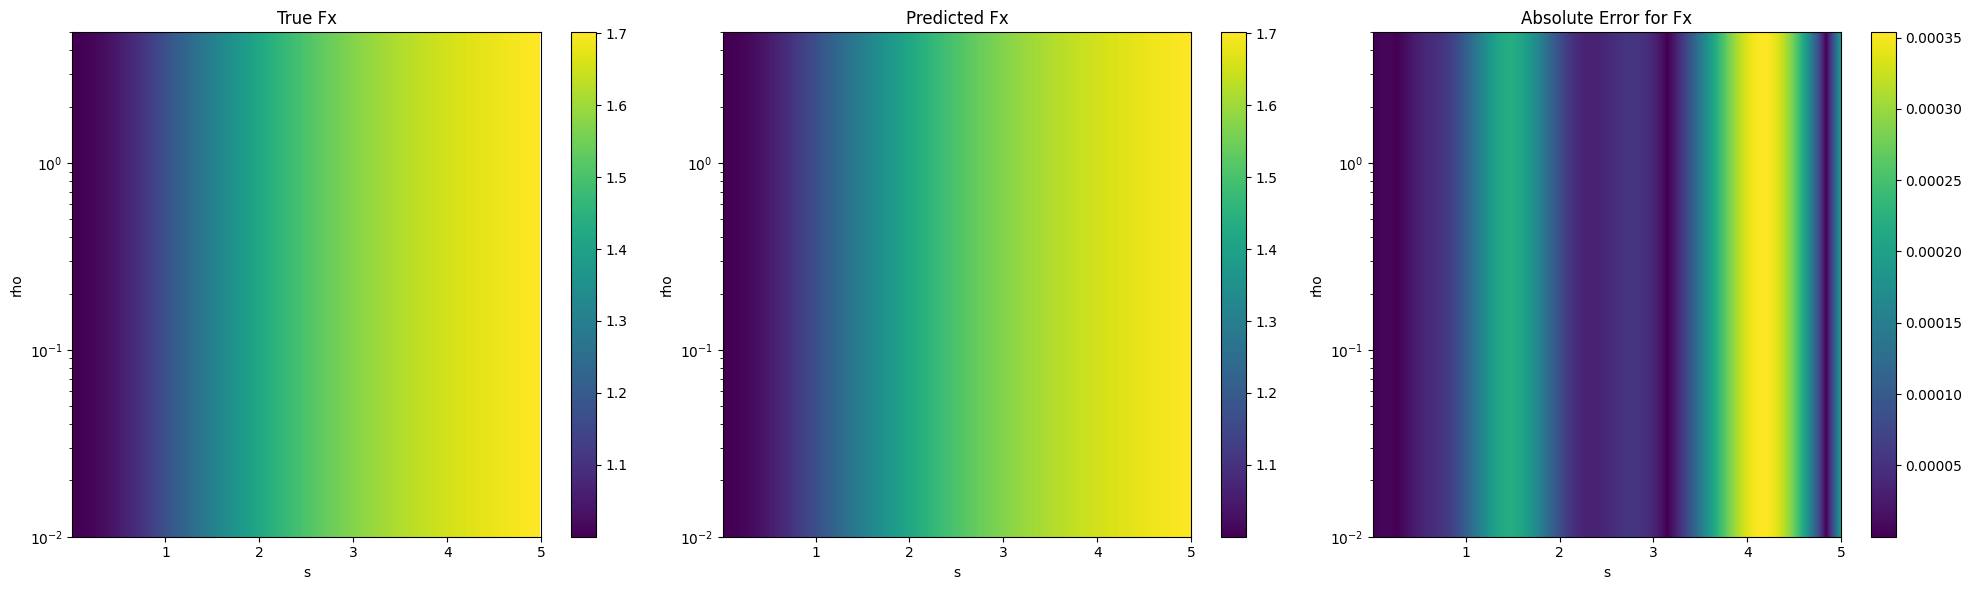

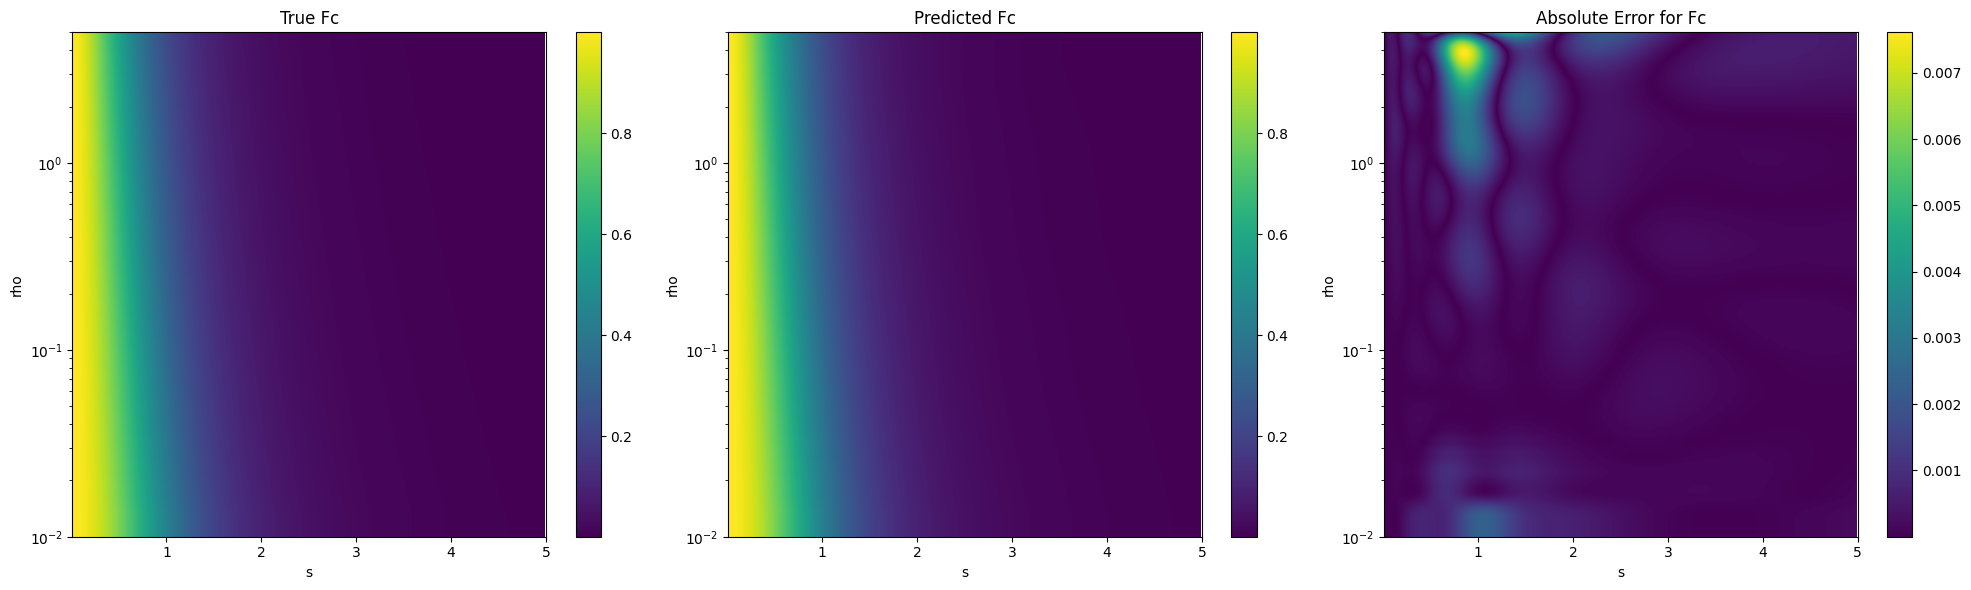

Fx Statistics:
R-squared: 0.999999
Mean Absolute Error: 0.000128
Root Mean Squared Error: 0.000167
Maximum Absolute Error: 0.000354

Fc Statistics:
R-squared: 0.999973
Mean Absolute Error: 0.000744
Root Mean Squared Error: 0.001373
Maximum Absolute Error: 0.007614


In [9]:
# Generate test points
NUM_RHO = 1000  # Number of different rho values to test
NUM_S = 1000  # Number of s values for each rho

START_S, STOP_S = 0.01, 5  # Adjust these values as needed
START_RHO, STOP_RHO = 0.01, 5  # Range of rho values to test

test_s = jnp.linspace(START_S, STOP_S, num=NUM_S)
test_rho = jnp.linspace(START_RHO, STOP_RHO, num=NUM_RHO)

# Create meshgrid for s and rho
s_mesh, rho_mesh = jnp.meshgrid(test_s, test_rho)

# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * rho_mesh)**(1/3)
grad_rho_test = 2 * s_mesh * k_F_test * rho_mesh

# Prepare inputs for the neural networks
test_inputs = jnp.stack([rho_mesh.flatten(), grad_rho_test.flatten()], axis=1)
test_sinputs = jnp.stack([rho_mesh.flatten(), s_mesh.flatten()], axis=1)
test_inputs_normalized = (test_inputs - inputs_mean) / (inputs_std + 1e-8)

# Calculate true PBE enhancement factors
true_fx_test = Fx(rho_mesh.flatten(), grad_rho_test.flatten())
true_fc_test = Fc(rho_mesh.flatten(), grad_rho_test.flatten())

# Predict using neural networks
# pred_fx_normalized = jax.vmap(model_fx)(test_inputs_normalized).squeeze()
# pred_fx = pred_fx_normalized * true_fx_std + true_fx_mean
pred_fx = jax.vmap(model_fxg)(test_inputs)

# pred_fc_normalized = jax.vmap(model_fc)(test_inputs_normalized).squeeze()
# pred_fc = pred_fc_normalized * true_fc_std + true_fc_mean
pred_fc = jax.vmap(model_fcg)(test_inputs)

# Reshape results
true_fx_test = true_fx_test.reshape(NUM_RHO, NUM_S)
true_fc_test = true_fc_test.reshape(NUM_RHO, NUM_S)
pred_fx = pred_fx.reshape(NUM_RHO, NUM_S)
pred_fc = pred_fc.reshape(NUM_RHO, NUM_S)

# Function to calculate statistics
def calculate_stats(true, pred):
    true_flat = true.flatten()
    pred_flat = pred.flatten()
    
    # R-squared
    ss_res = np.sum((true_flat - pred_flat) ** 2)
    ss_tot = np.sum((true_flat - np.mean(true_flat)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(true_flat - pred_flat))
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean((true_flat - pred_flat) ** 2))
    
    # Maximum Absolute Error
    max_error = np.max(np.abs(true_flat - pred_flat))
    
    return r2, mae, rmse, max_error

# Calculate statistics
r2_fx, mae_fx, rmse_fx, max_error_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc, max_error_fc = calculate_stats(true_fc_test, pred_fc)

# Plotting
def plot_heatmap(true, pred, title, rho_values, s_values):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    im1 = ax1.imshow(true, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax1.set_title(f'True {title}')
    ax1.set_xlabel('s')
    ax1.set_ylabel('rho')
    ax1.set_yscale('log')
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(pred, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax2.set_title(f'Predicted {title}')
    ax2.set_xlabel('s')
    ax2.set_ylabel('rho')
    ax2.set_yscale('log')
    fig.colorbar(im2, ax=ax2)
    
    error = np.abs(true - pred)
    im3 = ax3.imshow(error, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax3.set_title(f'Absolute Error for {title}')
    ax3.set_xlabel('s')
    ax3.set_ylabel('rho')
    ax3.set_yscale('log')
    fig.colorbar(im3, ax=ax3)
    
    plt.tight_layout()
    plt.show()

# Plot heatmaps
plot_heatmap(true_fx_test, pred_fx, 'Fx', test_rho, test_s)
plot_heatmap(true_fc_test, pred_fc, 'Fc', test_rho, test_s)

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {max_error_fx:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {max_error_fc:.6f}")

### Below, we train FxNetGsig and FcNetGsig

These networks are to demonstrate how one would instead rely on PySCF-inputs of $(\rho, \sigma)$ as opposed to the above inputs of $(\rho,s)$. The network itself is still dependent on input $s$ values, but the function takes $(\rho,\sigma)$ and generates the corresponding $s$ value to feed to the network, allowing us to take gradients of the output energy density with respect to $\sigma$, as opposed to $s$.

In [10]:
NPTS = 30000  # Note: Number of grid points [i.e. (x,y) pairs] is actually sqrt(NPTS).

# Generate test points
NUM_RHO = 1000  # Number of different rho values to test
NUM_S = 1000  # Number of s values for each rho

START_S, STOP_S = 0.01, 5  # Adjust these values as needed
START_RHO, STOP_RHO = 0.01, 5  # Range of rho values to test

test_s = jnp.linspace(START_S, STOP_S, num=NPTS)
test_rho = jnp.linspace(START_RHO, STOP_RHO, num=NPTS)

# Generate training data
# Create more points for small values of s
s_values_low = jnp.linspace(START_S, 0.5, num=int(0.7 * jnp.sqrt(NPTS)))
s_values_high = jnp.linspace(0.5, STOP_S, num=int(0.3 * jnp.sqrt(NPTS)))
s_values = jnp.concatenate([s_values_low, s_values_high])

rho_values = jnp.logspace(jnp.log10(START_RHO), jnp.log10(STOP_RHO), num=int(jnp.sqrt(NPTS)))
#s_values = jnp.linspace(START_S, STOP_S, num=int(jnp.sqrt(NPTS))) #Use this for unbiased sampling

rho_mesh, s_mesh = jnp.meshgrid(rho_values, s_values)
rho_flat = rho_mesh.flatten()
s_flat = s_mesh.flatten()

# Calculate grad_rho
k_F = (3 * jnp.pi**2 * rho_flat)**(1/3)
grad_rho_flat = 2 * s_flat * k_F * rho_flat
sigma_flat = grad_rho_flat**2

# Create input array
inputs = jnp.stack([rho_flat, sigma_flat], axis=1)
sinputs = jnp.stack([rho_flat, s_flat], axis=1)

# Calculate true Fx and Fc values
true_fx = Fx(rho_flat, grad_rho_flat)
true_fc = Fc(rho_flat, grad_rho_flat)

# Normalize inputs and outputs
inputs_mean = inputs.mean(axis=0)
inputs_std = inputs.std(axis=0)
inputs_normalized = (inputs - inputs_mean) / (inputs_std + 1e-8)

true_fx_mean = true_fx.mean()
true_fx_std = true_fx.std()
true_fx_normalized = (true_fx - true_fx_mean) / (true_fx_std + 1e-8)

true_fc_mean = true_fc.mean()
true_fc_std = true_fc.std()
true_fc_normalized = (true_fc - true_fc_mean) / (true_fc_std + 1e-8)

# Define the training loop function
def loop(model, model_name, inputs, ref, optimizer, epochs=1000000, printevery=2500): #model_name is just for printing purposes
    @eqx.filter_value_and_grad
    def compute_loss(model, inputs, ref):
        pred = jax.vmap(model)(inputs)
        loss = jnp.mean(jnp.abs(pred - ref))
        return loss

    @eqx.filter_jit
    def make_step(model, inputs, ref, opt_state):
        loss, grad = compute_loss(model, inputs, ref)
        updates, opt_state = optimizer.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state
    print(f"Starting training for model: {model_name}")
    
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    losses = []

    for step in range(epochs):
        loss, model, opt_state = make_step(model, inputs, ref, opt_state)
        lossi = loss.item()
        losses.append(lossi)
        if step % printevery == 0:
            print(f'Epoch {step}: Loss = {lossi}')

    return model, losses

# Create optimizers
optimizer_fx = optax.chain(
    optax.adam(learning_rate=1e-3)
)
optimizer_fc = optax.chain(
    optax.adam(learning_rate=1e-3)
)

model_fxgsig = FxNetGsig(depth=3, nodes=16, seed=42)
model_fcgsig = FcNetGsig(depth=3, nodes=16, seed=42)

# Train the Fx model -- Fx(s)
model_fxgsig, losses_fxgsig = loop(model_fxgsig, 'Fx', inputs, true_fx, optimizer_fx, epochs=5000, printevery=100) #Can adjust number of epochs 

# Train the Fc model -- Fc(rho, s)
model_fcgsig, losses_fcgsig = loop(model_fcgsig, 'Fc', inputs, true_fc, optimizer_fc, epochs=5000, printevery=100) #Can adjust number of epochs 


Starting training for model: Fx
Epoch 0: Loss = 0.1720148024971639
Epoch 100: Loss = 0.00897189529988701
Epoch 200: Loss = 0.000415473940210338
Epoch 300: Loss = 0.0002659195474472434
Epoch 400: Loss = 0.00021032480170918438
Epoch 500: Loss = 0.0004211246666722107
Epoch 600: Loss = 0.0001518460867766321
Epoch 700: Loss = 0.00012651692413859675
Epoch 800: Loss = 0.00029470721752719066
Epoch 900: Loss = 0.00021367057794970823
Epoch 1000: Loss = 0.0003806253110166315
Epoch 1100: Loss = 0.00031396786172684863
Epoch 1200: Loss = 0.0001735424005038429
Epoch 1300: Loss = 8.236852724035745e-05
Epoch 1400: Loss = 0.00017757969482675625
Epoch 1500: Loss = 0.00016798057982571438
Epoch 1600: Loss = 0.000401110064559652
Epoch 1700: Loss = 0.00046535582803580375
Epoch 1800: Loss = 0.0002595712130950247
Epoch 1900: Loss = 0.000280276663607721
Epoch 2000: Loss = 0.0002796524566990366
Epoch 2100: Loss = 0.00010332342980454359
Epoch 2200: Loss = 0.00033065360339227124
Epoch 2300: Loss = 0.00058857119728

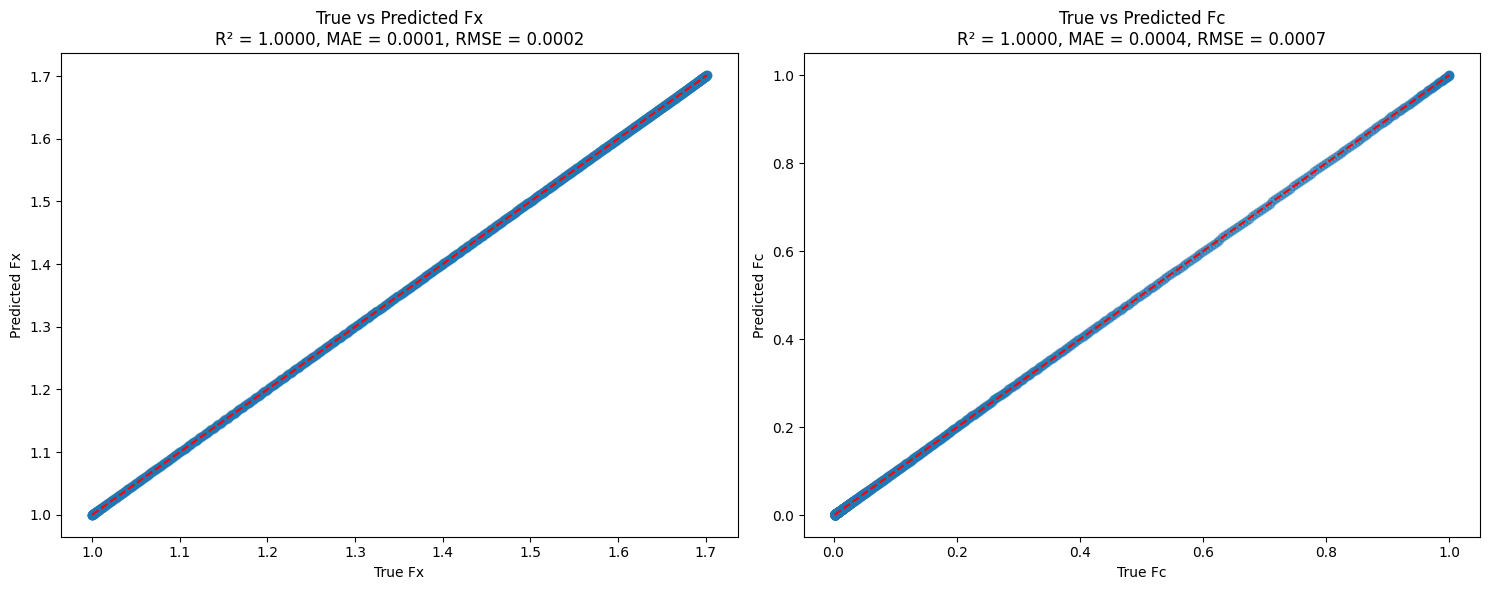

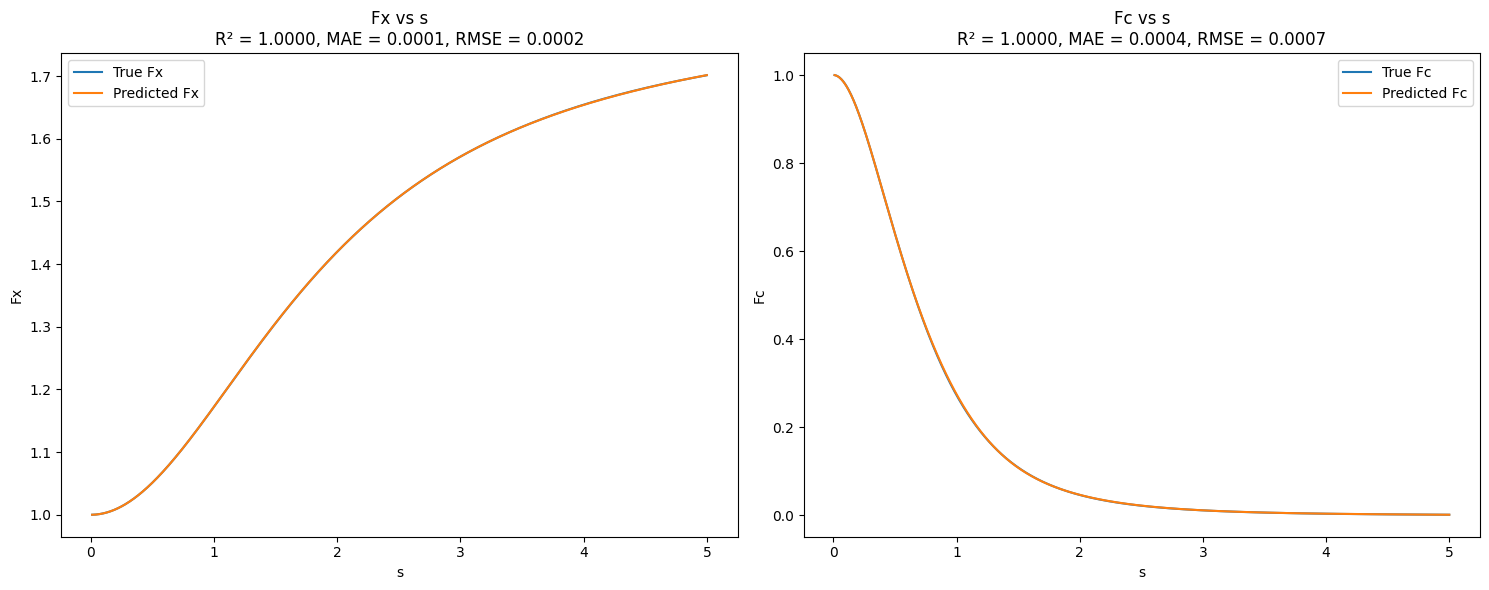

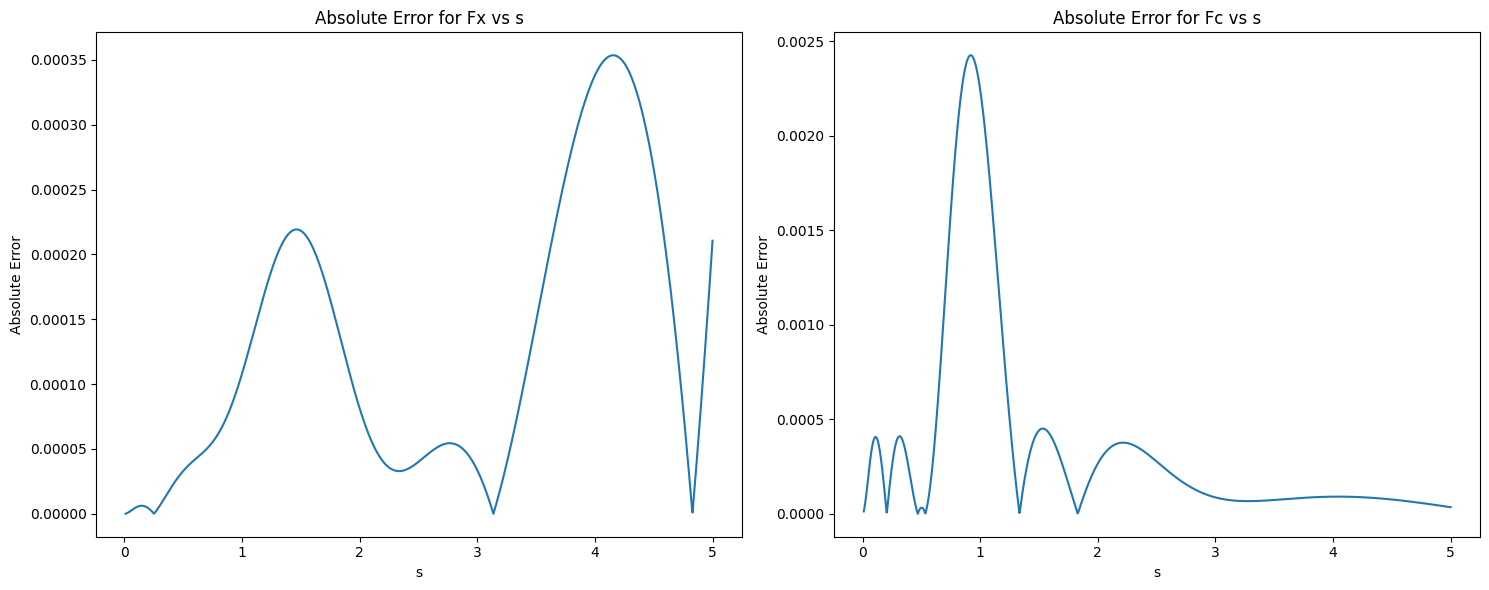

Fx Statistics:
R-squared: 0.999999
Mean Absolute Error: 0.000128
Root Mean Squared Error: 0.000167
Maximum Absolute Error: 0.000354

Fc Statistics:
R-squared: 0.999994
Mean Absolute Error: 0.000352
Root Mean Squared Error: 0.000655
Maximum Absolute Error: 0.002426


In [11]:
# Generate test points
test_s = jnp.linspace(START_S, STOP_S, num=1000)
test_rho = jnp.full_like(test_s, 1.0)  # We'll use a constant rho for simplicity

# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * test_rho)**(1/3)
grad_rho_test = 2 * test_s * k_F_test * test_rho
sigma_test = grad_rho_test**2

# Prepare inputs for the neural networks
test_inputs = jnp.stack([test_rho, sigma_test], axis=1)
test_sinputs = jnp.stack([test_rho, test_s], axis=1)
test_inputs_normalized = (test_inputs - inputs_mean) / (inputs_std + 1e-8)

# Calculate true PBE enhancement factors
true_fx_test = Fx(test_rho, grad_rho_test)
true_fc_test = Fc(test_rho, grad_rho_test)

# Predict using neural networks
#NOTE -- the inputs here ARE the s values, not the grad_rho values
pred_fx = jax.vmap(model_fxgsig)(test_inputs).squeeze()
# pred_fx = jax.vmap(model_fx2)(grad_rho_test[:, jnp.newaxis]).squeeze()

#The inputs here 
pred_fc = jax.vmap(model_fcgsig)(test_inputs).squeeze()

# Function to calculate statistics
def calculate_stats(true, pred):
    # R-squared
    ss_res = np.sum((true - pred) ** 2)
    ss_tot = np.sum((true - np.mean(true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(true - pred))
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean((true - pred) ** 2))
    
    return r2, mae, rmse

# Calculate statistics
r2_fx, mae_fx, rmse_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc = calculate_stats(true_fc_test, pred_fc)

# 1. Correlation plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(true_fx_test, pred_fx, alpha=0.5)
ax1.plot([true_fx_test.min(), true_fx_test.max()], [true_fx_test.min(), true_fx_test.max()], 'r--')
ax1.set_xlabel('True Fx')
ax1.set_ylabel('Predicted Fx')
ax1.set_title(f'True vs Predicted Fx\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')

ax2.scatter(true_fc_test, pred_fc, alpha=0.5)
ax2.plot([true_fc_test.min(), true_fc_test.max()], [true_fc_test.min(), true_fc_test.max()], 'r--')
ax2.set_xlabel('True Fc')
ax2.set_ylabel('Predicted Fc')
ax2.set_title(f'True vs Predicted Fc\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')

plt.tight_layout()
plt.show()

# 2. True PBE factors vs. s
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, true_fx_test, label='True Fx')
ax1.plot(test_s, pred_fx, label='Predicted Fx')
ax1.set_xlabel('s')
ax1.set_ylabel('Fx')
ax1.set_title(f'Fx vs s\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')
ax1.legend()

ax2.plot(test_s, true_fc_test, label='True Fc')
ax2.plot(test_s, pred_fc, label='Predicted Fc')
ax2.set_xlabel('s')
ax2.set_ylabel('Fc')
ax2.set_title(f'Fc vs s\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')
ax2.legend()

plt.tight_layout()
plt.show()

# 3. Error plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, np.abs(true_fx_test - pred_fx))
ax1.set_xlabel('s')
ax1.set_ylabel('Absolute Error')
ax1.set_title('Absolute Error for Fx vs s')

ax2.plot(test_s, np.abs(true_fc_test - pred_fc))
ax2.set_xlabel('s')
ax2.set_ylabel('Absolute Error')
ax2.set_title('Absolute Error for Fc vs s')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {np.max(np.abs(true_fx_test - pred_fx)):.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {np.max(np.abs(true_fc_test - pred_fc)):.6f}")

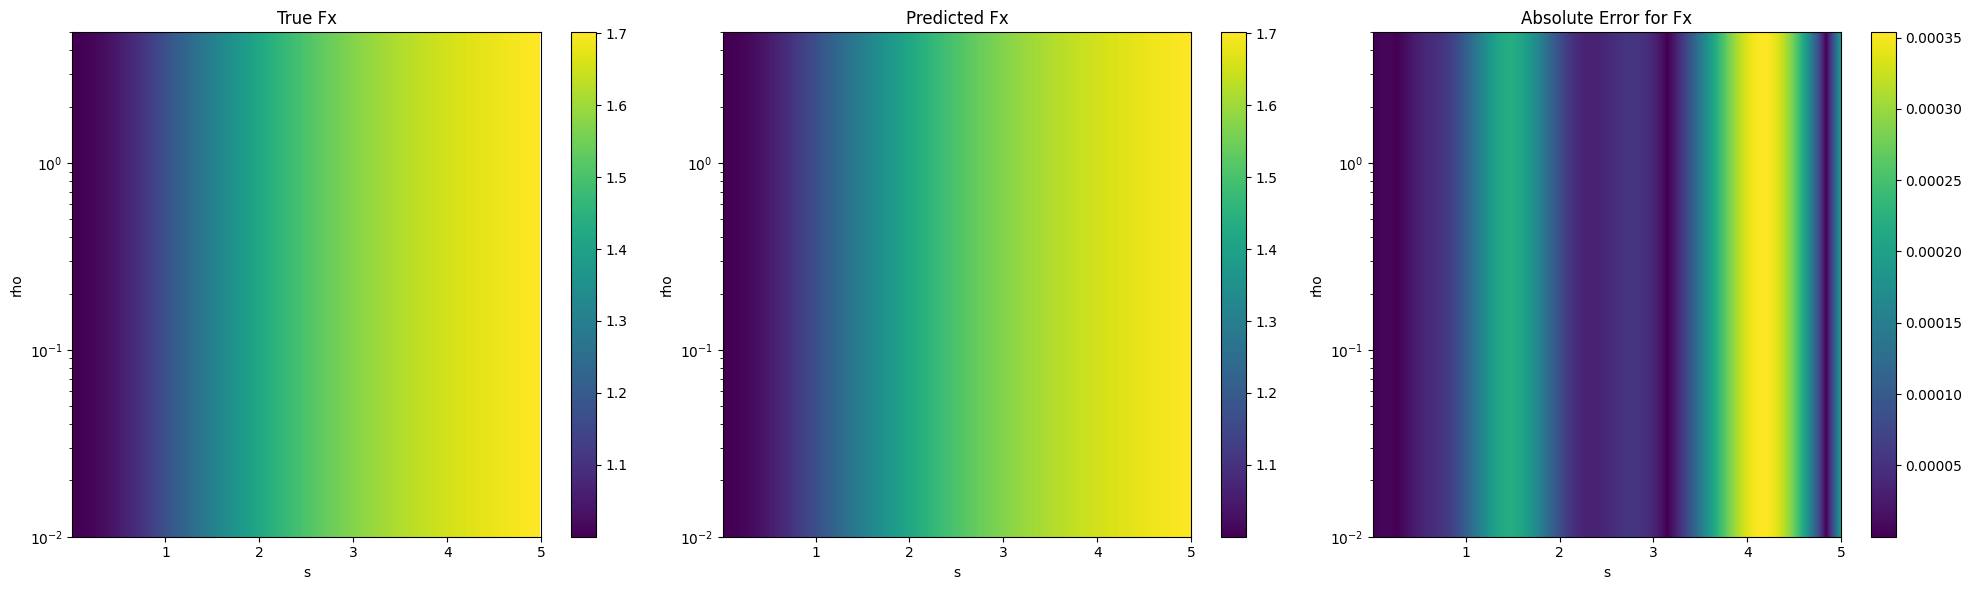

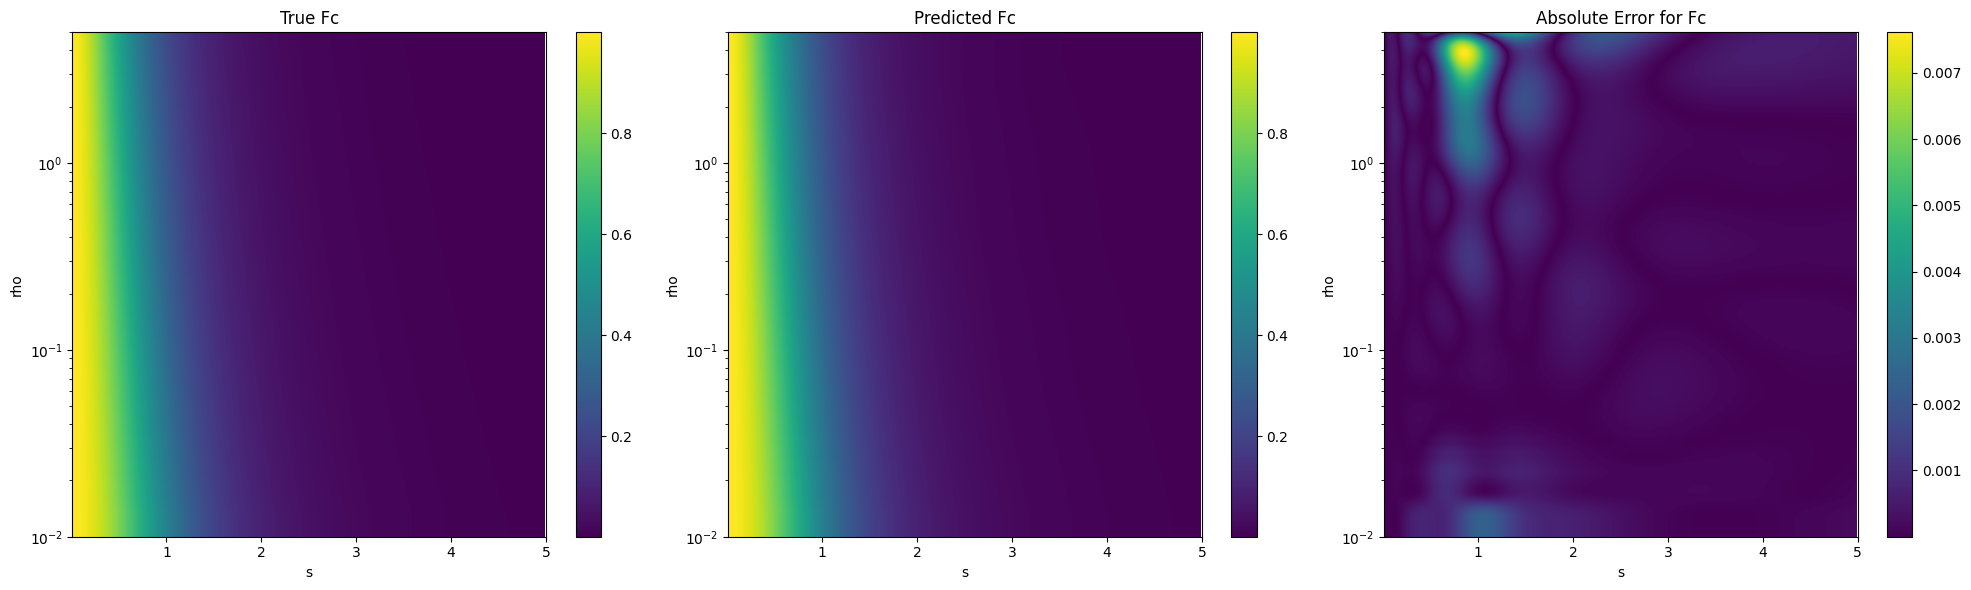

Fx Statistics:
R-squared: 0.999999
Mean Absolute Error: 0.000128
Root Mean Squared Error: 0.000167
Maximum Absolute Error: 0.000354

Fc Statistics:
R-squared: 0.999973
Mean Absolute Error: 0.000744
Root Mean Squared Error: 0.001373
Maximum Absolute Error: 0.007614


In [12]:
# Generate test points
NUM_RHO = 1000  # Number of different rho values to test
NUM_S = 1000  # Number of s values for each rho

START_S, STOP_S = 0.01, 5  # Adjust these values as needed
START_RHO, STOP_RHO = 0.01, 5  # Range of rho values to test

test_s = jnp.linspace(START_S, STOP_S, num=NUM_S)
test_rho = jnp.linspace(START_RHO, STOP_RHO, num=NUM_RHO)

# Create meshgrid for s and rho
s_mesh, rho_mesh = jnp.meshgrid(test_s, test_rho)

# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * rho_mesh)**(1/3)
grad_rho_test = 2 * s_mesh * k_F_test * rho_mesh
sigma_test = grad_rho_test**2

# Prepare inputs for the neural networks
test_inputs = jnp.stack([rho_mesh.flatten(), sigma_test.flatten()], axis=1)
test_sinputs = jnp.stack([rho_mesh.flatten(), s_mesh.flatten()], axis=1)
test_inputs_normalized = (test_inputs - inputs_mean) / (inputs_std + 1e-8)

# Calculate true PBE enhancement factors
true_fx_test = Fx(rho_mesh.flatten(), grad_rho_test.flatten())
true_fc_test = Fc(rho_mesh.flatten(), grad_rho_test.flatten())

# Predict using neural networks
# pred_fx_normalized = jax.vmap(model_fx)(test_inputs_normalized).squeeze()
# pred_fx = pred_fx_normalized * true_fx_std + true_fx_mean
pred_fx = jax.vmap(model_fxgsig)(test_inputs)

# pred_fc_normalized = jax.vmap(model_fc)(test_inputs_normalized).squeeze()
# pred_fc = pred_fc_normalized * true_fc_std + true_fc_mean
pred_fc = jax.vmap(model_fcgsig)(test_inputs)

# Reshape results
true_fx_test = true_fx_test.reshape(NUM_RHO, NUM_S)
true_fc_test = true_fc_test.reshape(NUM_RHO, NUM_S)
pred_fx = pred_fx.reshape(NUM_RHO, NUM_S)
pred_fc = pred_fc.reshape(NUM_RHO, NUM_S)

# Function to calculate statistics
def calculate_stats(true, pred):
    true_flat = true.flatten()
    pred_flat = pred.flatten()
    
    # R-squared
    ss_res = np.sum((true_flat - pred_flat) ** 2)
    ss_tot = np.sum((true_flat - np.mean(true_flat)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(true_flat - pred_flat))
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean((true_flat - pred_flat) ** 2))
    
    # Maximum Absolute Error
    max_error = np.max(np.abs(true_flat - pred_flat))
    
    return r2, mae, rmse, max_error

# Calculate statistics
r2_fx, mae_fx, rmse_fx, max_error_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc, max_error_fc = calculate_stats(true_fc_test, pred_fc)

# Plotting
def plot_heatmap(true, pred, title, rho_values, s_values):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    im1 = ax1.imshow(true, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax1.set_title(f'True {title}')
    ax1.set_xlabel('s')
    ax1.set_ylabel('rho')
    ax1.set_yscale('log')
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(pred, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax2.set_title(f'Predicted {title}')
    ax2.set_xlabel('s')
    ax2.set_ylabel('rho')
    ax2.set_yscale('log')
    fig.colorbar(im2, ax=ax2)
    
    error = np.abs(true - pred)
    im3 = ax3.imshow(error, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax3.set_title(f'Absolute Error for {title}')
    ax3.set_xlabel('s')
    ax3.set_ylabel('rho')
    ax3.set_yscale('log')
    fig.colorbar(im3, ax=ax3)
    
    plt.tight_layout()
    plt.show()

# Plot heatmaps
plot_heatmap(true_fx_test, pred_fx, 'Fx', test_rho, test_s)
plot_heatmap(true_fc_test, pred_fc, 'Fc', test_rho, test_s)

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {max_error_fx:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {max_error_fc:.6f}")

As these results agree exactly with the `FxNetG` and `FcNetG` results, we can see that a change of the `__call__` function's inputs does not change the network's end behavior, as it still depends on `s` which is generated from $\sigma$ in the forward pass.

# Training with Gradients
For this, we must develop a function that returns $\rho\cdot\epsilon_{x/c}$ which we take the derivatives of w.r.t. $\rho$ and $\sigma=|\nabla\rho|^2$. To that end, though, the function must take as inputs $\rho$ and $\sigma$, and modify $\sigma$ to feed to the network itself as $|\nabla\rho|$ as it is expecting.

In [13]:
def gen_rhoxexc_func(modelx, modelc, inputs):
    def get_rhoxexc_scf(inputs):
        rho0 = inputs[0, jnp.newaxis]
        sigma = inputs[1, jnp.newaxis]
        gamma = jnp.sqrt(sigma)
        # gamma = sigma
        inp = {}
        inp['rho'] = rho0[0]
        inp['sigma'] = gamma[0]
    
        e_heg_x = jsexchng_exonly(rho0)
        e_heg_c = pw92c_unpolarized(rho0)
    
        # print(f'e_heg_c shape = {e_heg_c.shape}, e_heg_x shape = {e_heg_x.shape}')
        # print(f'e_heg_c = {e_heg_c}, e_heg_x = {e_heg_x}')        
        k_F = (3 * jnp.pi**2 * rho0)**(1/3)
        s = gamma/(2*k_F*rho0+1e-10)
        sinputs = jnp.array([rho0[0], s[0]])

        Fx = modelx(sinputs)
        Fc = modelc(sinputs)
        
        exc = rho0*(e_heg_x*Fx + e_heg_c*Fc)
        return exc[0]

    return get_rhoxexc_scf

def calc_exc_vxc_pbe(rho, grho, xmodel, cmodel, do_v = False, vvv=False):
    stacked_inputs = jnp.stack([rho, grho], axis=1)

    def calc_ex(rho, grho):
        ex_stacked_inputs = jnp.stack([rho, grho], axis=1)

        return lda_x(rho) * jax.vmap(xmodel)(ex_stacked_inputs)
    def calc_ec(rho, grho):
        ec_stacked_inputs = jnp.stack([rho, grho], axis=1)

        return pw92c_unpolarized(rho) * jax.vmap(cmodel)(ec_stacked_inputs)
    def calc_rhoex(inputs):
        rho, sig = inputs
        #convert sigma to gamma to pass to network
        ex_stacked_inputs = jnp.stack([rho, jnp.sqrt(sig)], axis=0)
        if vvv:
            print('calc_rhoex inputs shape', inputs.shape)
            print('calc_rhoex inputs', inputs, inputs[0], inputs[1])
            print('ex_stacked_inputs shape', ex_stacked_inputs.shape)
        return rho*lda_x(rho) * xmodel(ex_stacked_inputs)
    def calc_rhoec(inputs):
        rho, sig = inputs
        #convert sigma to gamma to pass to network
        ec_stacked_inputs = jnp.stack([rho, jnp.sqrt(sig)], axis=0)
        ret = rho*pw92c_unpolarized(rho) * cmodel(ec_stacked_inputs)
        return ret[0]

    ex = calc_ex(rho, grho)
    ec = calc_ec(rho, grho)

    if do_v:
        sigma = grho**2
        vinp = jnp.stack([rho, sigma], axis=1)
        if vvv:
            print('vinp shape', vinp.shape)
        vxf = jax.grad(calc_rhoex)
        vcf = jax.grad(calc_rhoec)
        
        vxr = jax.vmap(vxf)(vinp)
        vcr = jax.vmap(vcf)(vinp)

        return ex, vxr, ec, vcr
    else:
        return ex, ec

def calc_ex_vx_pbe(inputs, xmodel, do_v = False, vvv=False):
    rho, grho = inputs
    stacked_inputs = jnp.stack([rho, grho], axis=0)

    def calc_ex(rho, grho):
        ex_stacked_inputs = jnp.stack([rho, grho], axis=0)

        return lda_x(rho) * jax.vmap(xmodel)(ex_stacked_inputs[:, jnp.newaxis])
    def calc_rhoex(inputs):
        # print('calc_rhoex inputs', inputs)
        # print('calc_rhoex inputs shape', inputs.shape)
        rho, sig = inputs
        #convert sigma to gamma to pass to network
        ex_stacked_inputs = jnp.stack([rho, jnp.sqrt(sig)], axis=0)
        if vvv:
            print('calc_rhoex inputs shape', inputs.shape)
            print('calc_rhoex inputs', inputs, inputs[0], inputs[1])
            print('ex_stacked_inputs shape', ex_stacked_inputs.shape)
        return rho*lda_x(rho) * xmodel(ex_stacked_inputs)

    ex = calc_ex(rho, grho)

    if do_v:
        sigma = grho**2
        vinp = jnp.stack([rho, sigma], axis=0)
        if vvv:
            print('vinp shape', vinp.shape)
        vxf = jax.grad(calc_rhoex)
        print('do_v, vinp.shape:', vinp.shape)
        # vxr = jax.vmap(vxf)(vinp)
        vxr = vxf(vinp)

        return ex, vxr
    else:
        return ex

def calc_ec_vc_pbe(inputs, cmodel, do_v = False, vvv=False):
    rho, grho = inputs
    stacked_inputs = jnp.stack([rho, grho], axis=0)

    def calc_ec(rho, grho):
        ec_stacked_inputs = jnp.stack([rho, grho], axis=0)

        return pw92c_unpolarized(rho) * jax.vmap(cmodel)(ec_stacked_inputs[:, jnp.newaxis])
    def calc_rhoec(inputs):
        rho, sig = inputs
        #convert sigma to gamma to pass to network
        ec_stacked_inputs = jnp.stack([rho, jnp.sqrt(sig)], axis=0)
        ret = rho*pw92c_unpolarized(rho) * cmodel(ec_stacked_inputs)
        return ret[0]

    ec = calc_ec(rho, grho)

    if do_v:
        sigma = grho**2
        vinp = jnp.stack([rho, sigma], axis=0)
        if vvv:
            print('vinp shape', vinp.shape)
        vcf = jax.grad(calc_rhoec)
        
        # vcr = jax.vmap(vcf)(vinp)
        vcr = vcf(vinp)

        return ec, vcr
    else:
        return ec


# --- below are copies of the above functions, modified to expect the inputs of (rho, sigma) and a network 
# --- parameterized by (rho, s)
def calc_ex_vx_pbe_sig(inputs, xmodel, do_v = False, vvv=False):
    rho, sigma = inputs
    stacked_inputs = jnp.stack([rho, sigma], axis=0)
    def sig_to_s(rho, sigma):
        k_F = (3 * jnp.pi**2 * rho)**(1/3)
        # grad_rho = jnp.sqrt(dx**2 + dy**2 + dz**2) 
        s = jnp.sqrt(sigma) / (2 * k_F * rho)
        return s
        
    def calc_ex(rho, sigma):
        #convert sigma to s to pass to network
        s = sig_to_s(rho, sigma)

        ex_stacked_inputs = jnp.stack([rho, s], axis=0)

        return lda_x(rho) * jax.vmap(xmodel)(ex_stacked_inputs[:, jnp.newaxis])
    def calc_rhoex(inputs):
        # print('calc_rhoex inputs', inputs)
        # print('calc_rhoex inputs shape', inputs.shape)
        rho, sigma = inputs
        #convert sigma to s to pass to network
        s = sig_to_s(rho, sigma)
        
        ex_stacked_inputs = jnp.stack([rho, s], axis=0)
        if vvv:
            print('calc_rhoex inputs shape', inputs.shape)
            print('calc_rhoex inputs', inputs, inputs[0], inputs[1])
            print('ex_stacked_inputs shape', ex_stacked_inputs.shape)
        return rho*lda_x(rho) * xmodel(ex_stacked_inputs)

    ex = calc_ex(rho, sigma)

    if do_v:
        vinp = jnp.stack([rho, sigma], axis=0)
        if vvv:
            print('vinp shape', vinp.shape)
        vxf = jax.grad(calc_rhoex)
        print('do_v, vinp.shape:', vinp.shape)
        # vxr = jax.vmap(vxf)(vinp)
        vxr = vxf(vinp)

        return ex, vxr
    else:
        return ex

def calc_ec_vc_pbe_sig(inputs, cmodel, do_v = False, vvv=False):
    rho, sigma = inputs
    stacked_inputs = jnp.stack([rho, sigma], axis=0)
    def sig_to_s(rho, sigma):
        k_F = (3 * jnp.pi**2 * rho)**(1/3)
        # grad_rho = jnp.sqrt(dx**2 + dy**2 + dz**2) 
        s = jnp.sqrt(sigma) / (2 * k_F * rho)
        return s

    def calc_ec(rho, sigma):
        #convert sigma to s to pass to network
        s = sig_to_s(rho, sigma)

        ec_stacked_inputs = jnp.stack([rho, sigma], axis=0)

        return pw92c_unpolarized(rho) * jax.vmap(cmodel)(ec_stacked_inputs[:, jnp.newaxis])
        
    def calc_rhoec(inputs):
        rho, sigma = inputs
        #convert sigma to s to pass to network
        s = sig_to_s(rho, sigma)
        
        ec_stacked_inputs = jnp.stack([rho, s], axis=0)
        ret = rho*pw92c_unpolarized(rho) * cmodel(ec_stacked_inputs)
        return ret[0]

    ec = calc_ec(rho, sigma)

    if do_v:
        vinp = jnp.stack([rho, sigma], axis=0)
        if vvv:
            print('vinp shape', vinp.shape)
        vcf = jax.grad(calc_rhoec)
        
        # vcr = jax.vmap(vcf)(vinp)
        vcr = vcf(vinp)

        return ec, vcr
    else:
        return ec

In [14]:
NPTS = 30000  # Note: Number of grid points [i.e. (x,y) pairs] is actually sqrt(NPTS).

# Generate test points
NUM_RHO = 1000  # Number of different rho values to test
NUM_S = 1000  # Number of s values for each rho

START_S, STOP_S = 0.01, 5  # Adjust these values as needed
START_RHO, STOP_RHO = 0.01, 5  # Range of rho values to test

test_s = jnp.linspace(START_S, STOP_S, num=NPTS)
test_rho = jnp.linspace(START_RHO, STOP_RHO, num=NPTS)

# Generate training data
# Create more points for small values of s
s_values_low = jnp.linspace(START_S, 0.5, num=int(0.7 * jnp.sqrt(NPTS)))
s_values_high = jnp.linspace(0.5, STOP_S, num=int(0.3 * jnp.sqrt(NPTS)))
s_values = jnp.concatenate([s_values_low, s_values_high])

rho_values = jnp.logspace(jnp.log10(START_RHO), jnp.log10(STOP_RHO), num=int(jnp.sqrt(NPTS)))
#s_values = jnp.linspace(START_S, STOP_S, num=int(jnp.sqrt(NPTS))) #Use this for unbiased sampling

rho_mesh, s_mesh = jnp.meshgrid(rho_values, s_values)
rho_flat = rho_mesh.flatten()
s_flat = s_mesh.flatten()

# Calculate grad_rho
k_F = (3 * jnp.pi**2 * rho_flat)**(1/3)
grad_rho_flat = 2 * s_flat * k_F * rho_flat
sigma = grad_rho_flat**2

# Create input array
inputs = jnp.stack([rho_flat, grad_rho_flat], axis=1)
sinputs = jnp.stack([rho_flat, s_flat], axis=1)

# Calculate true Fx and Fc values
true_fx = Fx(rho_flat, grad_rho_flat)
true_fc = Fc(rho_flat, grad_rho_flat)

# Normalize inputs and outputs
inputs_mean = inputs.mean(axis=0)
inputs_std = inputs.std(axis=0)
inputs_normalized = (inputs - inputs_mean) / (inputs_std + 1e-8)

true_fx_mean = true_fx.mean()
true_fx_std = true_fx.std()
true_fx_normalized = (true_fx - true_fx_mean) / (true_fx_std + 1e-8)

true_fc_mean = true_fc.mean()
true_fc_std = true_fc.std()
true_fc_normalized = (true_fc - true_fc_mean) / (true_fc_std + 1e-8)

# Define the training loop function
def loop(model, model_name, inputs, ref, gref, optimizer, epochs=1000000, printevery=2500): #model_name is just for printing purposes
    @eqx.filter_value_and_grad
    def compute_loss_x(model, inputs, ref, gref):
        pred = jax.vmap(model)(inputs)
        grad_f = lambda x: calc_ex_vx_pbe(x, xmodel=model, do_v = True, vvv=False)
        ex, vx = jax.vmap(grad_f)(inputs)
        losse = jnp.mean(jnp.abs(pred - ref))
        lossg = jnp.mean(jnp.abs(vx - gref))
        loss = jnp.sqrt(losse**2 + lossg**2)
        return loss

    @eqx.filter_jit
    def make_step_x(model, inputs, ref, gref, opt_state):
        loss, grad = compute_loss_x(model, inputs, ref, gref)
        updates, opt_state = optimizer.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state
        
    @eqx.filter_value_and_grad
    def compute_loss_c(model, inputs, ref, gref):
        pred = jax.vmap(model)(inputs)
        grad_f = lambda x: calc_ec_vc_pbe(x, cmodel=model, do_v = True, vvv=False)
        ec, vc = jax.vmap(grad_f)(inputs)
        losse = jnp.mean(jnp.abs(pred - ref))
        lossg = jnp.mean(jnp.abs(vc - gref))
        loss = jnp.sqrt(losse**2 + lossg**2)
        return loss

    @eqx.filter_jit
    def make_step_c(model, inputs, ref, gref, opt_state):
        loss, grad = compute_loss_c(model, inputs, ref, gref)
        updates, opt_state = optimizer.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state
    print(f"Starting training for model: {model_name}")
    
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    losses = []

    for step in range(epochs):
        if model_name == 'Fx':
            loss, model, opt_state = make_step_x(model, inputs, ref, gref, opt_state)
        elif model_name == 'Fc':
            loss, model, opt_state = make_step_c(model, inputs, ref, gref, opt_state)

        lossi = loss.item()
        losses.append(lossi)
        if step % printevery == 0:
            print(f'Epoch {step}: Loss = {lossi}')

    return model, losses

func_pbe_x = pylibxc.LibXCFunctional("gga_x_pbe", "unpolarized")
func_pbe_c = pylibxc.LibXCFunctional("gga_c_pbe", "unpolarized")

inp = {'rho': rho_flat, 'sigma': grad_rho_flat**2}

ret_pbe_x = func_pbe_x.compute(inp)
ret_pbe_c = func_pbe_c.compute(inp)

gref_x = jnp.stack([ret_pbe_x['vrho'][0], ret_pbe_x['vsigma'][0]], axis=1)
gref_c = jnp.stack([ret_pbe_c['vrho'][0], ret_pbe_c['vsigma'][0]], axis=1)

print('gref shapes: gref_x = ', gref_x.shape, 'gref_c = ', gref_c.shape)

#create LR scheduler
ILR = 1e-3
NEPOCHS = 5000

sched = optax.schedules.cosine_decay_schedule(init_value = ILR,
                                              decay_steps = NEPOCHS,
                                              alpha = 1e-5)

# Create optimizers
optimizer_fx = optax.chain(
    optax.adam(learning_rate=sched)
)
optimizer_fc = optax.chain(
    optax.adam(learning_rate=sched)
)
# optimizer_fx = optax.chain(
#     optax.adam(learning_rate=1e-3)
# )
# optimizer_fc = optax.chain(
#     optax.adam(learning_rate=1e-3)
# )

model_fxgg = FxNetG(depth=3, nodes=16, seed=42)
model_fcgg = FcNetG(depth=3, nodes=16, seed=42)

# Train the Fx model -- Fx(rho, gradrho) -> 
model_fxgg, losses_fxgg = loop(model_fxgg, 'Fx', inputs, true_fx, gref_x, optimizer_fx, epochs=NEPOCHS, printevery=100) #Can adjust number of epochs 

# Train the Fc model -- Fc(rho, gradrho)
model_fcgg, losses_fcgg = loop(model_fcgg, 'Fc', inputs, true_fc, gref_c, optimizer_fc, epochs=NEPOCHS, printevery=100) #Can adjust number of epochs 


gref shapes: gref_x =  (29756, 2) gref_c =  (29756, 2)
Starting training for model: Fx
do_v, vinp.shape: (2,)
Epoch 0: Loss = 0.23635321610789994
Epoch 100: Loss = 0.006577241918249625
Epoch 200: Loss = 0.0019296611901080663
Epoch 300: Loss = 0.0012966100581704376
Epoch 400: Loss = 0.000775121808364372
Epoch 500: Loss = 0.001339397054248568
Epoch 600: Loss = 0.0002652938331140319
Epoch 700: Loss = 0.0002741962977638547
Epoch 800: Loss = 0.00039020793392776515
Epoch 900: Loss = 0.00020652233714457013
Epoch 1000: Loss = 0.0002041029128335746
Epoch 1100: Loss = 0.00032572039232600756
Epoch 1200: Loss = 0.0005086930429977199
Epoch 1300: Loss = 0.0007725283247363697
Epoch 1400: Loss = 0.00024028839169780775
Epoch 1500: Loss = 0.00015223113256646016
Epoch 1600: Loss = 0.00013640745681393866
Epoch 1700: Loss = 0.00015937865010960366
Epoch 1800: Loss = 0.0005478066288089897
Epoch 1900: Loss = 0.0003003009804626159
Epoch 2000: Loss = 0.0003294648897875082
Epoch 2100: Loss = 0.000108993673544169

In [15]:
ret_pbe_x = func_pbe_x.compute(inp)

In [16]:
ret_pbe_x['vrho'][0].shape, ret_pbe_x['vsigma'][0].shape

((29756,), (29756,))

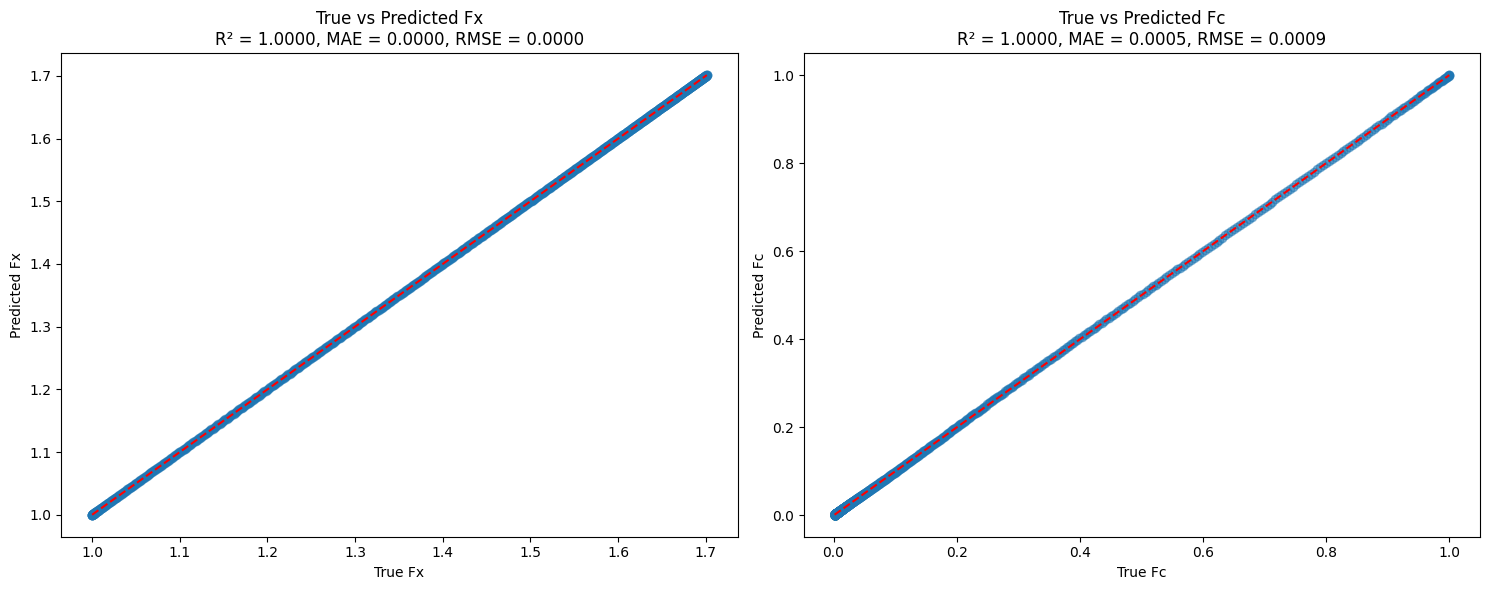

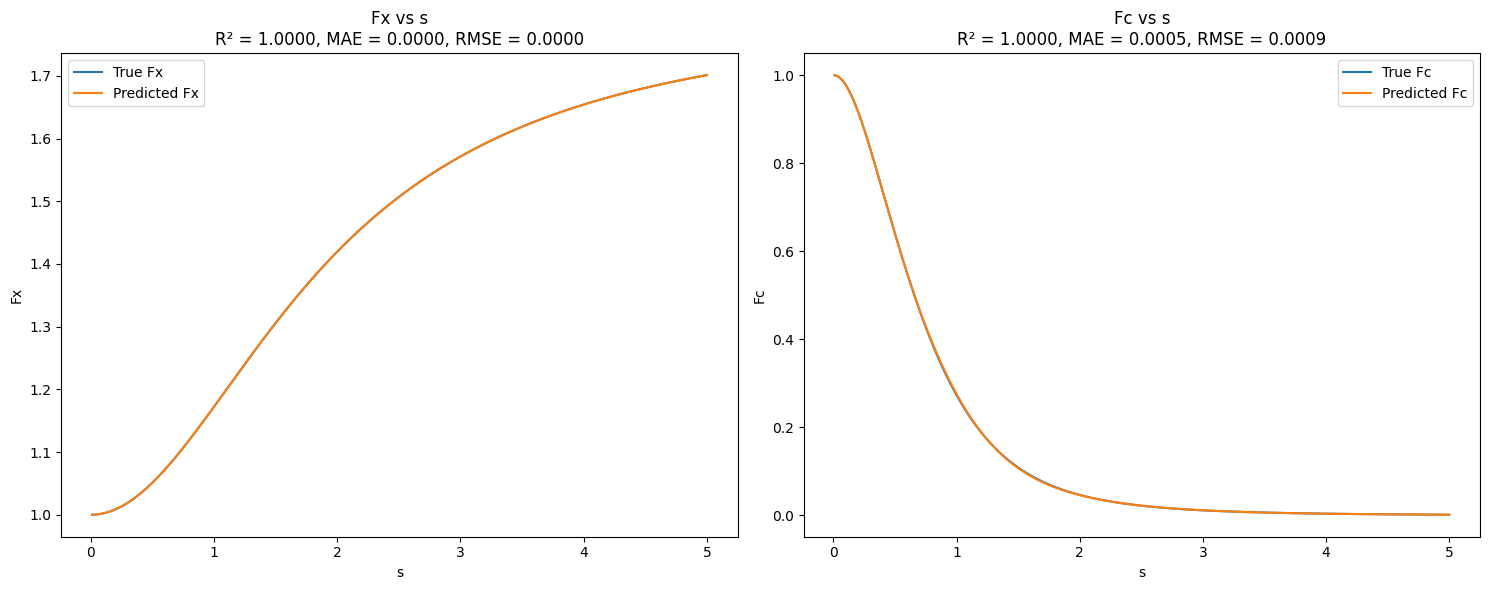

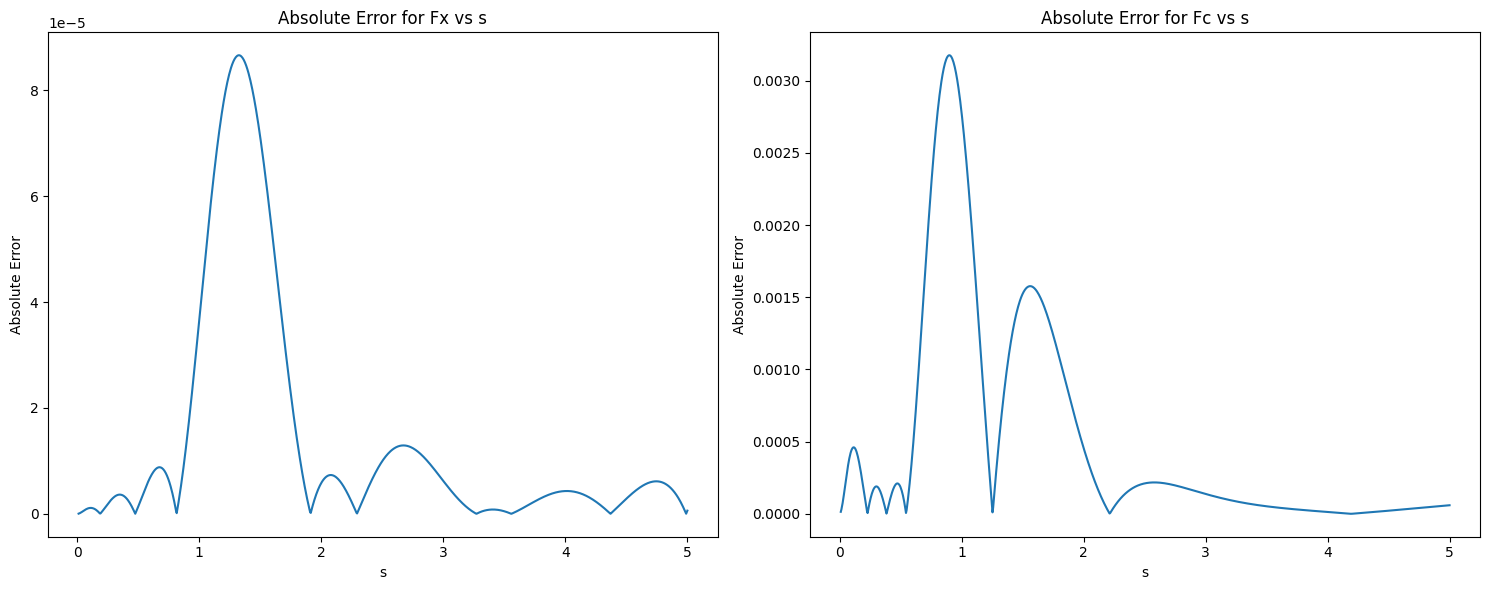

Fx Statistics:
R-squared: 1.000000
Mean Absolute Error: 0.000014
Root Mean Squared Error: 0.000027
Maximum Absolute Error: 0.000087

Fc Statistics:
R-squared: 0.999988
Mean Absolute Error: 0.000499
Root Mean Squared Error: 0.000925
Maximum Absolute Error: 0.003176


In [17]:
# Generate test points
test_s = jnp.linspace(START_S, STOP_S, num=1000)
test_rho = jnp.full_like(test_s, 1.0)  # We'll use a constant rho for simplicity

# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * test_rho)**(1/3)
grad_rho_test = 2 * test_s * k_F_test * test_rho

# Prepare inputs for the neural networks
test_inputs = jnp.stack([test_rho, grad_rho_test], axis=1)
test_sinputs = jnp.stack([test_rho, test_s], axis=1)
test_inputs_normalized = (test_inputs - inputs_mean) / (inputs_std + 1e-8)

# Calculate true PBE enhancement factors
true_fx_test = Fx(test_rho, grad_rho_test)
true_fc_test = Fc(test_rho, grad_rho_test)

# Predict using neural networks
#NOTE -- the inputs here ARE the s values, not the grad_rho values
pred_fx = jax.vmap(model_fxgg)(test_inputs).squeeze()
# pred_fx = jax.vmap(model_fx2)(grad_rho_test[:, jnp.newaxis]).squeeze()

#The inputs here 
pred_fc = jax.vmap(model_fcgg)(test_inputs).squeeze()

# Function to calculate statistics
def calculate_stats(true, pred):
    # R-squared
    ss_res = np.sum((true - pred) ** 2)
    ss_tot = np.sum((true - np.mean(true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(true - pred))
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean((true - pred) ** 2))
    
    return r2, mae, rmse

# Calculate statistics
r2_fx, mae_fx, rmse_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc = calculate_stats(true_fc_test, pred_fc)

# 1. Correlation plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(true_fx_test, pred_fx, alpha=0.5)
ax1.plot([true_fx_test.min(), true_fx_test.max()], [true_fx_test.min(), true_fx_test.max()], 'r--')
ax1.set_xlabel('True Fx')
ax1.set_ylabel('Predicted Fx')
ax1.set_title(f'True vs Predicted Fx\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')

ax2.scatter(true_fc_test, pred_fc, alpha=0.5)
ax2.plot([true_fc_test.min(), true_fc_test.max()], [true_fc_test.min(), true_fc_test.max()], 'r--')
ax2.set_xlabel('True Fc')
ax2.set_ylabel('Predicted Fc')
ax2.set_title(f'True vs Predicted Fc\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')

plt.tight_layout()
plt.show()

# 2. True PBE factors vs. s
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, true_fx_test, label='True Fx')
ax1.plot(test_s, pred_fx, label='Predicted Fx')
ax1.set_xlabel('s')
ax1.set_ylabel('Fx')
ax1.set_title(f'Fx vs s\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')
ax1.legend()

ax2.plot(test_s, true_fc_test, label='True Fc')
ax2.plot(test_s, pred_fc, label='Predicted Fc')
ax2.set_xlabel('s')
ax2.set_ylabel('Fc')
ax2.set_title(f'Fc vs s\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')
ax2.legend()

plt.tight_layout()
plt.show()

# 3. Error plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, np.abs(true_fx_test - pred_fx))
ax1.set_xlabel('s')
ax1.set_ylabel('Absolute Error')
ax1.set_title('Absolute Error for Fx vs s')

ax2.plot(test_s, np.abs(true_fc_test - pred_fc))
ax2.set_xlabel('s')
ax2.set_ylabel('Absolute Error')
ax2.set_title('Absolute Error for Fc vs s')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {np.max(np.abs(true_fx_test - pred_fx)):.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {np.max(np.abs(true_fc_test - pred_fc)):.6f}")

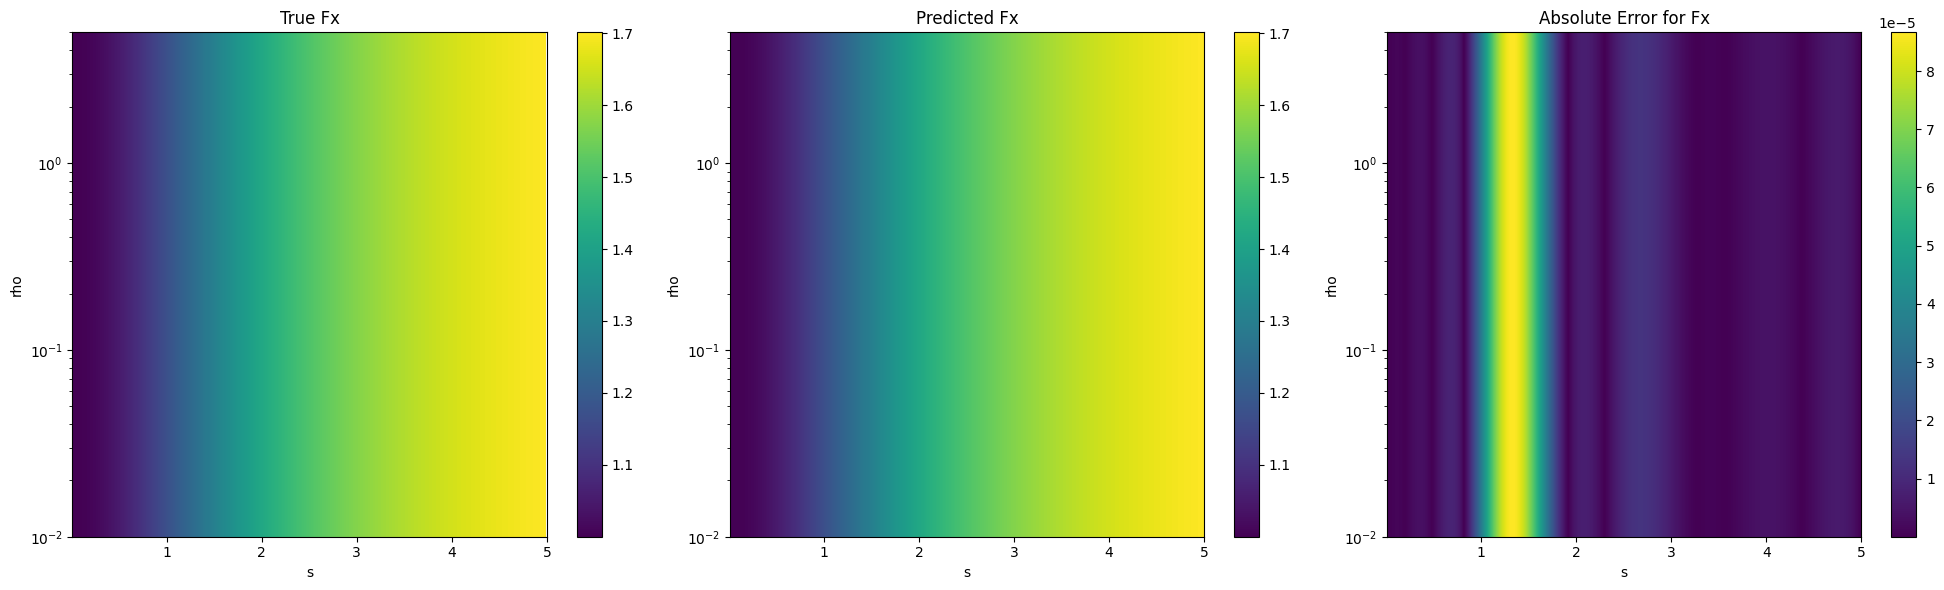

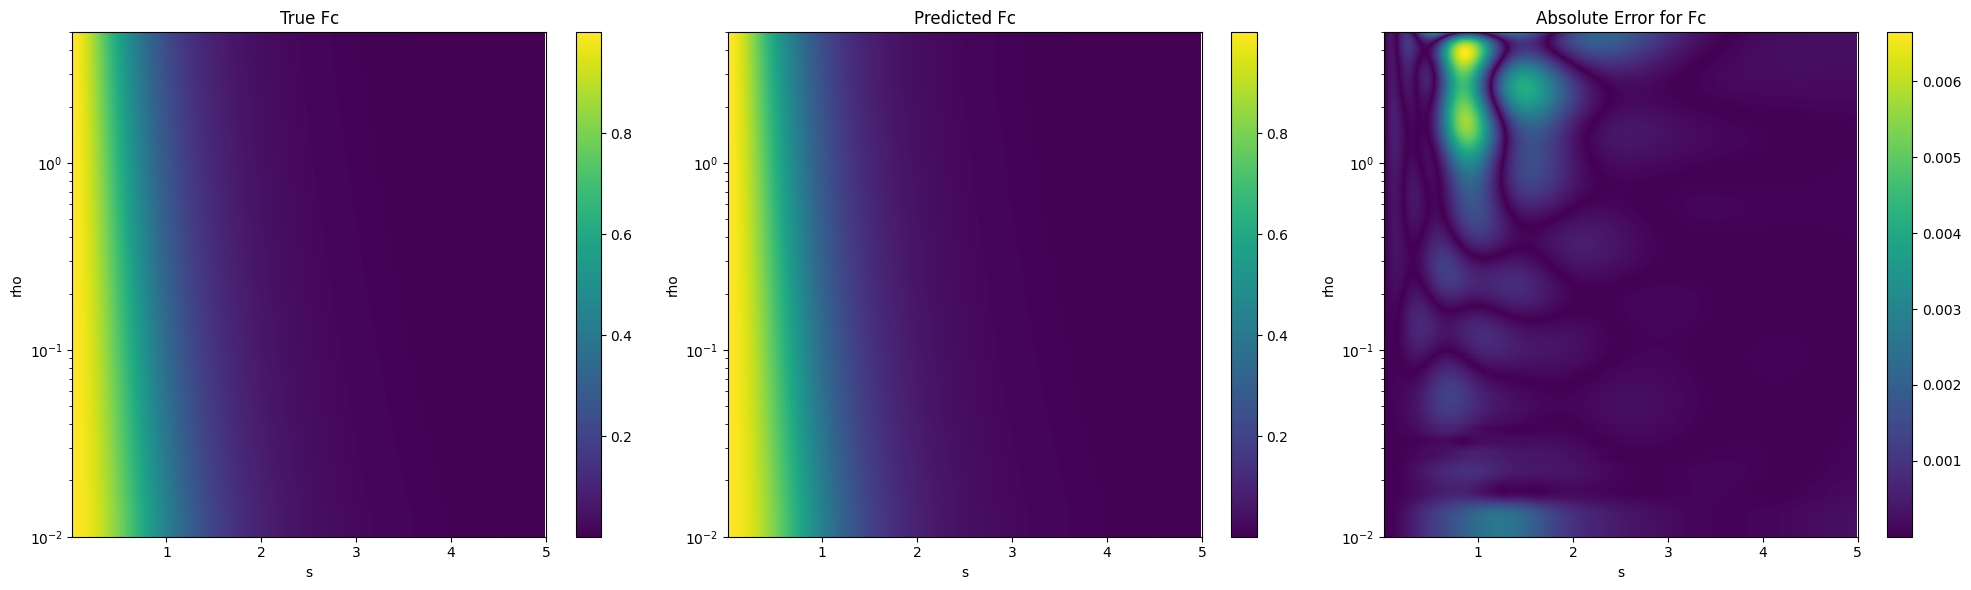

Fx Statistics:
R-squared: 1.000000
Mean Absolute Error: 0.000014
Root Mean Squared Error: 0.000027
Maximum Absolute Error: 0.000087

Fc Statistics:
R-squared: 0.999970
Mean Absolute Error: 0.000799
Root Mean Squared Error: 0.001453
Maximum Absolute Error: 0.006647


In [18]:
# Generate test points
NUM_RHO = 1000  # Number of different rho values to test
NUM_S = 1000  # Number of s values for each rho

START_S, STOP_S = 0.01, 5  # Adjust these values as needed
START_RHO, STOP_RHO = 0.01, 5  # Range of rho values to test

test_s = jnp.linspace(START_S, STOP_S, num=NUM_S)
test_rho = jnp.linspace(START_RHO, STOP_RHO, num=NUM_RHO)

# Create meshgrid for s and rho
s_mesh, rho_mesh = jnp.meshgrid(test_s, test_rho)

# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * rho_mesh)**(1/3)
grad_rho_test = 2 * s_mesh * k_F_test * rho_mesh

# Prepare inputs for the neural networks
test_inputs = jnp.stack([rho_mesh.flatten(), grad_rho_test.flatten()], axis=1)
test_sinputs = jnp.stack([rho_mesh.flatten(), s_mesh.flatten()], axis=1)
test_inputs_normalized = (test_inputs - inputs_mean) / (inputs_std + 1e-8)

# Calculate true PBE enhancement factors
true_fx_test = Fx(rho_mesh.flatten(), grad_rho_test.flatten())
true_fc_test = Fc(rho_mesh.flatten(), grad_rho_test.flatten())

# Predict using neural networks
# pred_fx_normalized = jax.vmap(model_fx)(test_inputs_normalized).squeeze()
# pred_fx = pred_fx_normalized * true_fx_std + true_fx_mean
pred_fx = jax.vmap(model_fxgg)(test_inputs)

# pred_fc_normalized = jax.vmap(model_fc)(test_inputs_normalized).squeeze()
# pred_fc = pred_fc_normalized * true_fc_std + true_fc_mean
pred_fc = jax.vmap(model_fcgg)(test_inputs)

# Reshape results
true_fx_test = true_fx_test.reshape(NUM_RHO, NUM_S)
true_fc_test = true_fc_test.reshape(NUM_RHO, NUM_S)
pred_fx = pred_fx.reshape(NUM_RHO, NUM_S)
pred_fc = pred_fc.reshape(NUM_RHO, NUM_S)

# Function to calculate statistics
def calculate_stats(true, pred):
    true_flat = true.flatten()
    pred_flat = pred.flatten()
    
    # R-squared
    ss_res = np.sum((true_flat - pred_flat) ** 2)
    ss_tot = np.sum((true_flat - np.mean(true_flat)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(true_flat - pred_flat))
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean((true_flat - pred_flat) ** 2))
    
    # Maximum Absolute Error
    max_error = np.max(np.abs(true_flat - pred_flat))
    
    return r2, mae, rmse, max_error

# Calculate statistics
r2_fx, mae_fx, rmse_fx, max_error_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc, max_error_fc = calculate_stats(true_fc_test, pred_fc)

# Plotting
def plot_heatmap(true, pred, title, rho_values, s_values):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    im1 = ax1.imshow(true, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax1.set_title(f'True {title}')
    ax1.set_xlabel('s')
    ax1.set_ylabel('rho')
    ax1.set_yscale('log')
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(pred, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax2.set_title(f'Predicted {title}')
    ax2.set_xlabel('s')
    ax2.set_ylabel('rho')
    ax2.set_yscale('log')
    fig.colorbar(im2, ax=ax2)
    
    error = np.abs(true - pred)
    im3 = ax3.imshow(error, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax3.set_title(f'Absolute Error for {title}')
    ax3.set_xlabel('s')
    ax3.set_ylabel('rho')
    ax3.set_yscale('log')
    fig.colorbar(im3, ax=ax3)
    
    plt.tight_layout()
    plt.show()

# Plot heatmaps
plot_heatmap(true_fx_test, pred_fx, 'Fx', test_rho, test_s)
plot_heatmap(true_fc_test, pred_fc, 'Fc', test_rho, test_s)

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {max_error_fx:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {max_error_fc:.6f}")

### Now, the same gradient-inclusive trainining for the F{x,c}NetGSig architectures

In [19]:
NPTS = 30000  # Note: Number of grid points [i.e. (x,y) pairs] is actually sqrt(NPTS).

# Generate test points
NUM_RHO = 1000  # Number of different rho values to test
NUM_S = 1000  # Number of s values for each rho

START_S, STOP_S = 0.01, 5  # Adjust these values as needed
START_RHO, STOP_RHO = 0.01, 5  # Range of rho values to test

test_s = jnp.linspace(START_S, STOP_S, num=NPTS)
test_rho = jnp.linspace(START_RHO, STOP_RHO, num=NPTS)

# Generate training data
# Create more points for small values of s
s_values_low = jnp.linspace(START_S, 0.5, num=int(0.7 * jnp.sqrt(NPTS)))
s_values_high = jnp.linspace(0.5, STOP_S, num=int(0.3 * jnp.sqrt(NPTS)))
s_values = jnp.concatenate([s_values_low, s_values_high])

rho_values = jnp.logspace(jnp.log10(START_RHO), jnp.log10(STOP_RHO), num=int(jnp.sqrt(NPTS)))
#s_values = jnp.linspace(START_S, STOP_S, num=int(jnp.sqrt(NPTS))) #Use this for unbiased sampling

rho_mesh, s_mesh = jnp.meshgrid(rho_values, s_values)
rho_flat = rho_mesh.flatten()
s_flat = s_mesh.flatten()

# Calculate grad_rho
k_F = (3 * jnp.pi**2 * rho_flat)**(1/3)
grad_rho_flat = 2 * s_flat * k_F * rho_flat
sigma = grad_rho_flat**2

# Create input array
inputs = jnp.stack([rho_flat, sigma], axis=1)
sinputs = jnp.stack([rho_flat, s_flat], axis=1)

# Calculate true Fx and Fc values
true_fx = Fx(rho_flat, grad_rho_flat)
true_fc = Fc(rho_flat, grad_rho_flat)

# Normalize inputs and outputs
inputs_mean = inputs.mean(axis=0)
inputs_std = inputs.std(axis=0)
inputs_normalized = (inputs - inputs_mean) / (inputs_std + 1e-8)

true_fx_mean = true_fx.mean()
true_fx_std = true_fx.std()
true_fx_normalized = (true_fx - true_fx_mean) / (true_fx_std + 1e-8)

true_fc_mean = true_fc.mean()
true_fc_std = true_fc.std()
true_fc_normalized = (true_fc - true_fc_mean) / (true_fc_std + 1e-8)

# Define the training loop function
def loop(model, model_name, inputs, ref, gref, optimizer, epochs=1000000, printevery=2500): #model_name is just for printing purposes
    @eqx.filter_value_and_grad
    def compute_loss_x(model, inputs, ref, gref):
        pred = jax.vmap(model)(inputs)
        grad_f = lambda x: calc_ex_vx_pbe_sig(x, xmodel=model, do_v = True, vvv=False)
        ex, vx = jax.vmap(grad_f)(inputs)
        losse = 500*jnp.mean(jnp.abs(pred - ref))
        lossg = jnp.mean(jnp.abs(vx - gref))
        # jax.debug.print('losse: {}', losse)
        # jax.debug.print('lossg: {}', lossg)
        loss = jnp.sqrt(losse**2 + lossg**2)
        return loss

    @eqx.filter_jit
    def make_step_x(model, inputs, ref, gref, opt_state):
        loss, grad = compute_loss_x(model, inputs, ref, gref)
        updates, opt_state = optimizer.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state
        
    @eqx.filter_value_and_grad
    def compute_loss_c(model, inputs, ref, gref):
        pred = jax.vmap(model)(inputs)
        grad_f = lambda x: calc_ec_vc_pbe_sig(x, cmodel=model, do_v = True, vvv=False)
        ec, vc = jax.vmap(grad_f)(inputs)
        losse = 500*jnp.mean(jnp.abs(pred - ref))
        lossg = jnp.mean(jnp.abs(vc - gref))
        loss = jnp.sqrt(losse**2 + lossg**2)
        return loss

    @eqx.filter_jit
    def make_step_c(model, inputs, ref, gref, opt_state):
        loss, grad = compute_loss_c(model, inputs, ref, gref)
        updates, opt_state = optimizer.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state
    print(f"Starting training for model: {model_name}")
    
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    losses = []

    for step in range(epochs):
        if model_name == 'Fx':
            loss, model, opt_state = make_step_x(model, inputs, ref, gref, opt_state)
        elif model_name == 'Fc':
            loss, model, opt_state = make_step_c(model, inputs, ref, gref, opt_state)

        lossi = loss.item()
        losses.append(lossi)
        if step % printevery == 0:
            print(f'Epoch {step}: Loss = {lossi}')

    return model, losses

func_pbe_x = pylibxc.LibXCFunctional("gga_x_pbe", "unpolarized")
func_pbe_c = pylibxc.LibXCFunctional("gga_c_pbe", "unpolarized")

inp = {'rho': rho_flat, 'sigma': grad_rho_flat**2}

ret_pbe_x = func_pbe_x.compute(inp)
ret_pbe_c = func_pbe_c.compute(inp)

gref_x = jnp.stack([ret_pbe_x['vrho'][0], ret_pbe_x['vsigma'][0]], axis=1)
gref_c = jnp.stack([ret_pbe_c['vrho'][0], ret_pbe_c['vsigma'][0]], axis=1)

print('gref shapes: gref_x = ', gref_x.shape, 'gref_c = ', gref_c.shape)
print('gref_x: ', gref_x)
print('gref_x sum ', gref_x.sum())
print('gref_c: ', gref_c)
#create LR scheduler
ILR = 1e-2
NEPOCHS = 5000

sched = optax.schedules.cosine_decay_schedule(init_value = ILR,
                                              decay_steps = NEPOCHS,
                                              alpha = 1e-5)

# Create optimizers
optimizer_fx = optax.chain(
    optax.adam(learning_rate=sched)
)
optimizer_fc = optax.chain(
    optax.adam(learning_rate=sched)
)
# optimizer_fx = optax.chain(
#     optax.adam(learning_rate=1e-3)
# )
# optimizer_fc = optax.chain(
#     optax.adam(learning_rate=1e-3)
# )

model_fxggsig = FxNetGsig(depth=3, nodes=16, seed=42)
model_fcggsig = FcNetGsig(depth=3, nodes=16, seed=42)

# Train the Fx model -- Fx(rho, gradrho) -> 
model_fxggsig, losses_fxggsig = loop(model_fxggsig, 'Fx', inputs, true_fx, gref_x, optimizer_fx, epochs=NEPOCHS, printevery=100) #Can adjust number of epochs 

# Train the Fc model -- Fc(rho, gradrho)
model_fcggsig, losses_fcggsig = loop(model_fcggsig, 'Fc', inputs, true_fc, gref_c, optimizer_fc, epochs=NEPOCHS, printevery=100) #Can adjust number of epochs 


gref shapes: gref_x =  (29756, 2) gref_c =  (29756, 2)
gref_x:  [[-2.12152227e-01 -1.96555333e+00]
 [-2.14722797e-01 -1.87310699e+00]
 [-2.17324515e-01 -1.78500870e+00]
 ...
 [-2.50195376e+00 -8.90591182e-06]
 [-2.53226902e+00 -8.48703792e-06]
 [-2.56295159e+00 -8.08786502e-06]]
gref_x sum  -27417.38725253925
gref_c:  [[-4.38806326e-02  1.96543985e+00]
 [-4.41232445e-02  1.87299629e+00]
 [-4.43664970e-02  1.78490075e+00]
 ...
 [-6.94727611e-04  1.77060013e-08]
 [-6.93777388e-04  1.66481887e-08]
 [-6.92831607e-04  1.56536403e-08]]
Starting training for model: Fx
do_v, vinp.shape: (2,)
Epoch 0: Loss = 86.15594509576786
Epoch 100: Loss = 4.397920111212009
Epoch 200: Loss = 4.217878900054838
Epoch 300: Loss = 3.297748984511293
Epoch 400: Loss = 3.239896010835225
Epoch 500: Loss = 3.128813621905909
Epoch 600: Loss = 3.0574815192195244
Epoch 700: Loss = 2.9543484614130824
Epoch 800: Loss = 3.0051448627734314
Epoch 900: Loss = 3.0348100209826403
Epoch 1000: Loss = 3.06387366868512
Epoch 1100:

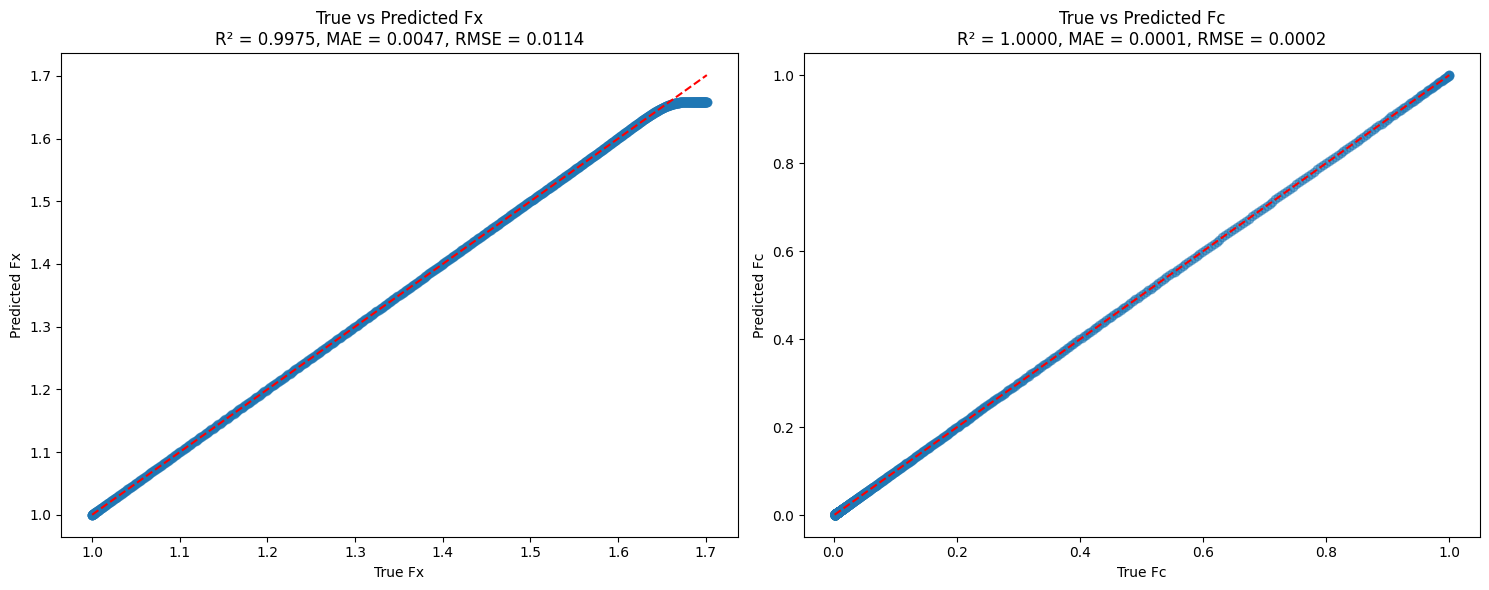

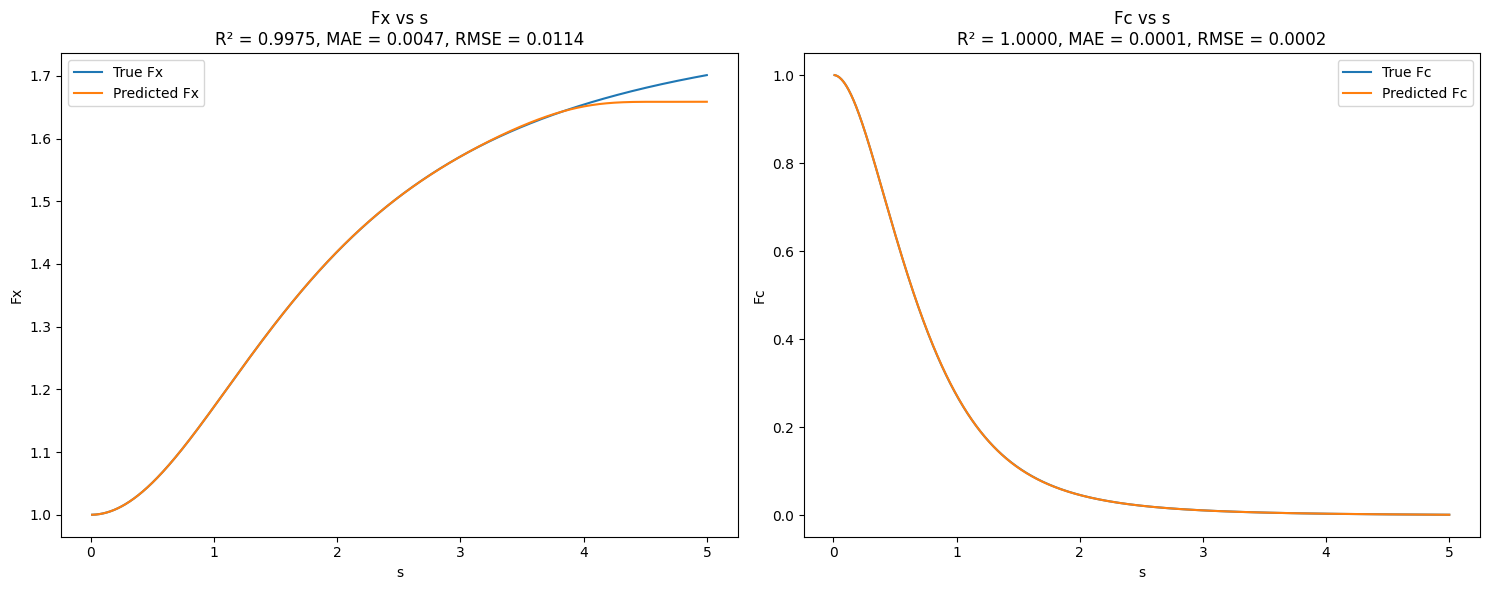

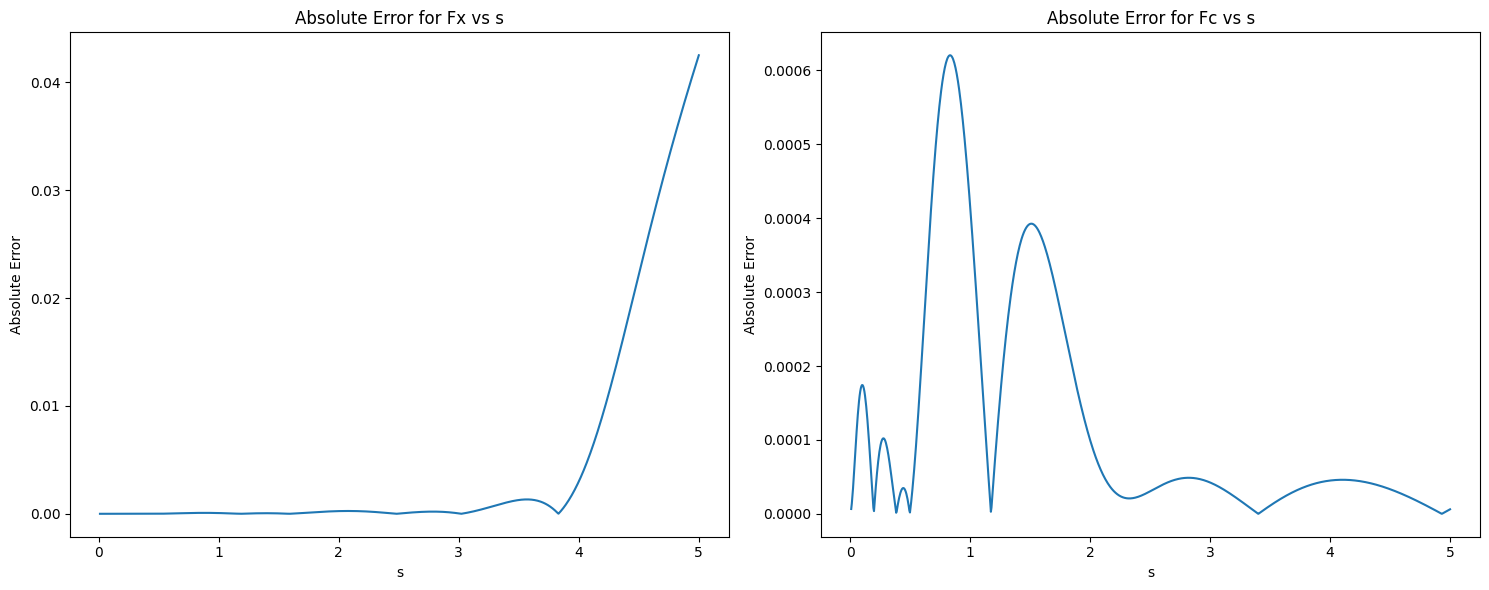

Fx Statistics:
R-squared: 0.997549
Mean Absolute Error: 0.004695
Root Mean Squared Error: 0.011360
Maximum Absolute Error: 0.042501

Fc Statistics:
R-squared: 0.999999
Mean Absolute Error: 0.000120
Root Mean Squared Error: 0.000197
Maximum Absolute Error: 0.000621


In [20]:
# Generate test points
test_s = jnp.linspace(START_S, STOP_S, num=1000)
test_rho = jnp.full_like(test_s, 1.0)  # We'll use a constant rho for simplicity

# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * test_rho)**(1/3)
grad_rho_test = 2 * test_s * k_F_test * test_rho
sigma = grad_rho_test**2

# Prepare inputs for the neural networks
test_inputs = jnp.stack([test_rho, sigma], axis=1)
test_sinputs = jnp.stack([test_rho, test_s], axis=1)
test_inputs_normalized = (test_inputs - inputs_mean) / (inputs_std + 1e-8)

# Calculate true PBE enhancement factors
true_fx_test = Fx(test_rho, grad_rho_test)
true_fc_test = Fc(test_rho, grad_rho_test)

# Predict using neural networks
#NOTE -- the inputs here ARE the s values, not the grad_rho values
pred_fx = jax.vmap(model_fxggsig)(test_inputs).squeeze()
# pred_fx = jax.vmap(model_fx2)(grad_rho_test[:, jnp.newaxis]).squeeze()

#The inputs here 
pred_fc = jax.vmap(model_fcggsig)(test_inputs).squeeze()

# Function to calculate statistics
def calculate_stats(true, pred):
    # R-squared
    ss_res = np.sum((true - pred) ** 2)
    ss_tot = np.sum((true - np.mean(true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(true - pred))
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean((true - pred) ** 2))
    
    return r2, mae, rmse

# Calculate statistics
r2_fx, mae_fx, rmse_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc = calculate_stats(true_fc_test, pred_fc)

# 1. Correlation plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(true_fx_test, pred_fx, alpha=0.5)
ax1.plot([true_fx_test.min(), true_fx_test.max()], [true_fx_test.min(), true_fx_test.max()], 'r--')
ax1.set_xlabel('True Fx')
ax1.set_ylabel('Predicted Fx')
ax1.set_title(f'True vs Predicted Fx\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')

ax2.scatter(true_fc_test, pred_fc, alpha=0.5)
ax2.plot([true_fc_test.min(), true_fc_test.max()], [true_fc_test.min(), true_fc_test.max()], 'r--')
ax2.set_xlabel('True Fc')
ax2.set_ylabel('Predicted Fc')
ax2.set_title(f'True vs Predicted Fc\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')

plt.tight_layout()
plt.show()

# 2. True PBE factors vs. s
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, true_fx_test, label='True Fx')
ax1.plot(test_s, pred_fx, label='Predicted Fx')
ax1.set_xlabel('s')
ax1.set_ylabel('Fx')
ax1.set_title(f'Fx vs s\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')
ax1.legend()

ax2.plot(test_s, true_fc_test, label='True Fc')
ax2.plot(test_s, pred_fc, label='Predicted Fc')
ax2.set_xlabel('s')
ax2.set_ylabel('Fc')
ax2.set_title(f'Fc vs s\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')
ax2.legend()

plt.tight_layout()
plt.show()

# 3. Error plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, np.abs(true_fx_test - pred_fx))
ax1.set_xlabel('s')
ax1.set_ylabel('Absolute Error')
ax1.set_title('Absolute Error for Fx vs s')

ax2.plot(test_s, np.abs(true_fc_test - pred_fc))
ax2.set_xlabel('s')
ax2.set_ylabel('Absolute Error')
ax2.set_title('Absolute Error for Fc vs s')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {np.max(np.abs(true_fx_test - pred_fx)):.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {np.max(np.abs(true_fc_test - pred_fc)):.6f}")

**NOTE**: It seems, at least using the above training method, that including the gradients only serves to make the actual enhancement factor fit much worse -- I am only able to generate an accurate network when the gradients serve as a regularizer. I weight the actual enhancement factor loss much more heavily in the above training, and that is why I get an accurate result here -- but you can see in the exchange enhancement factor in particular that it is much less accurate than the network trained without gradients.

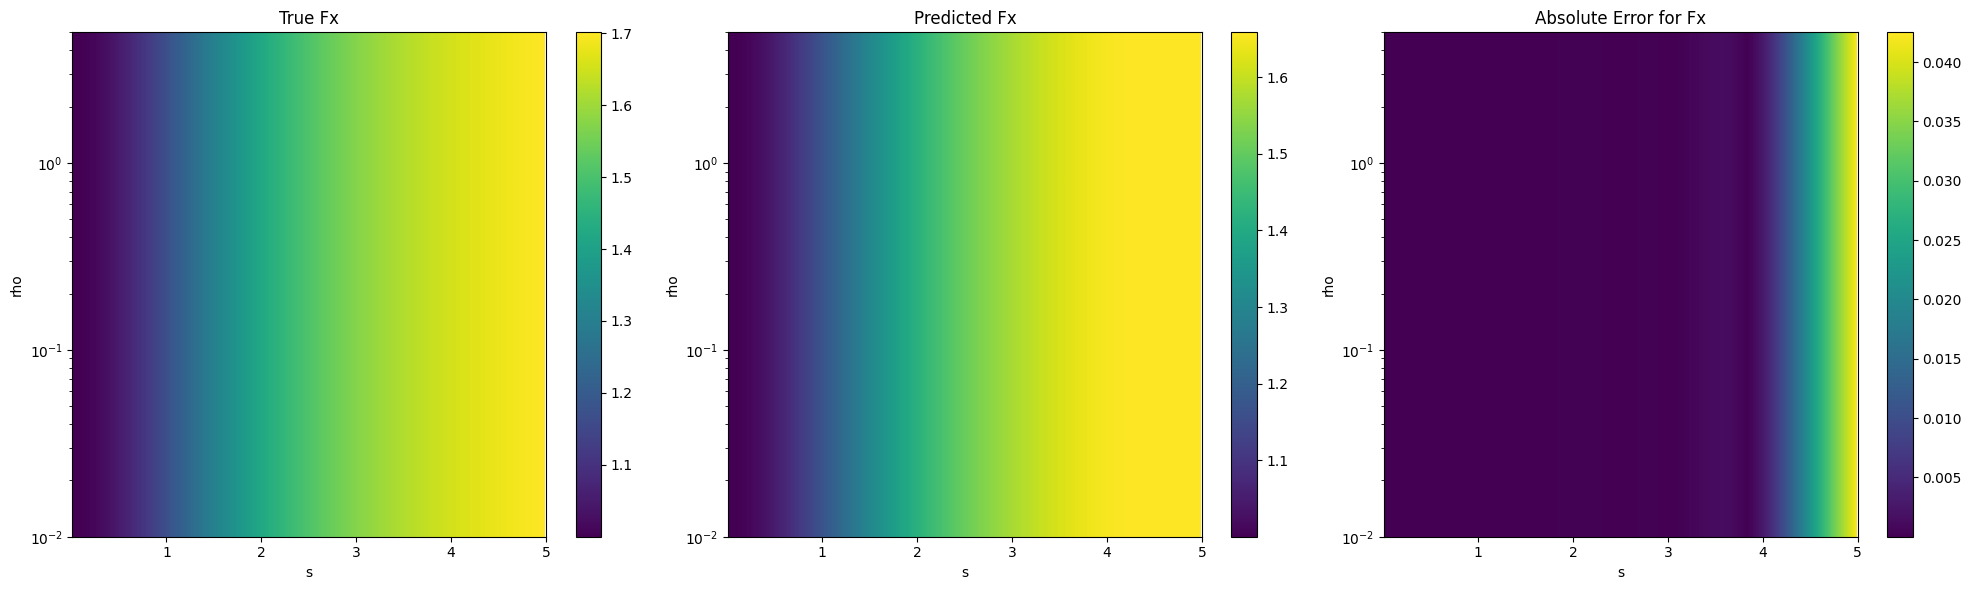

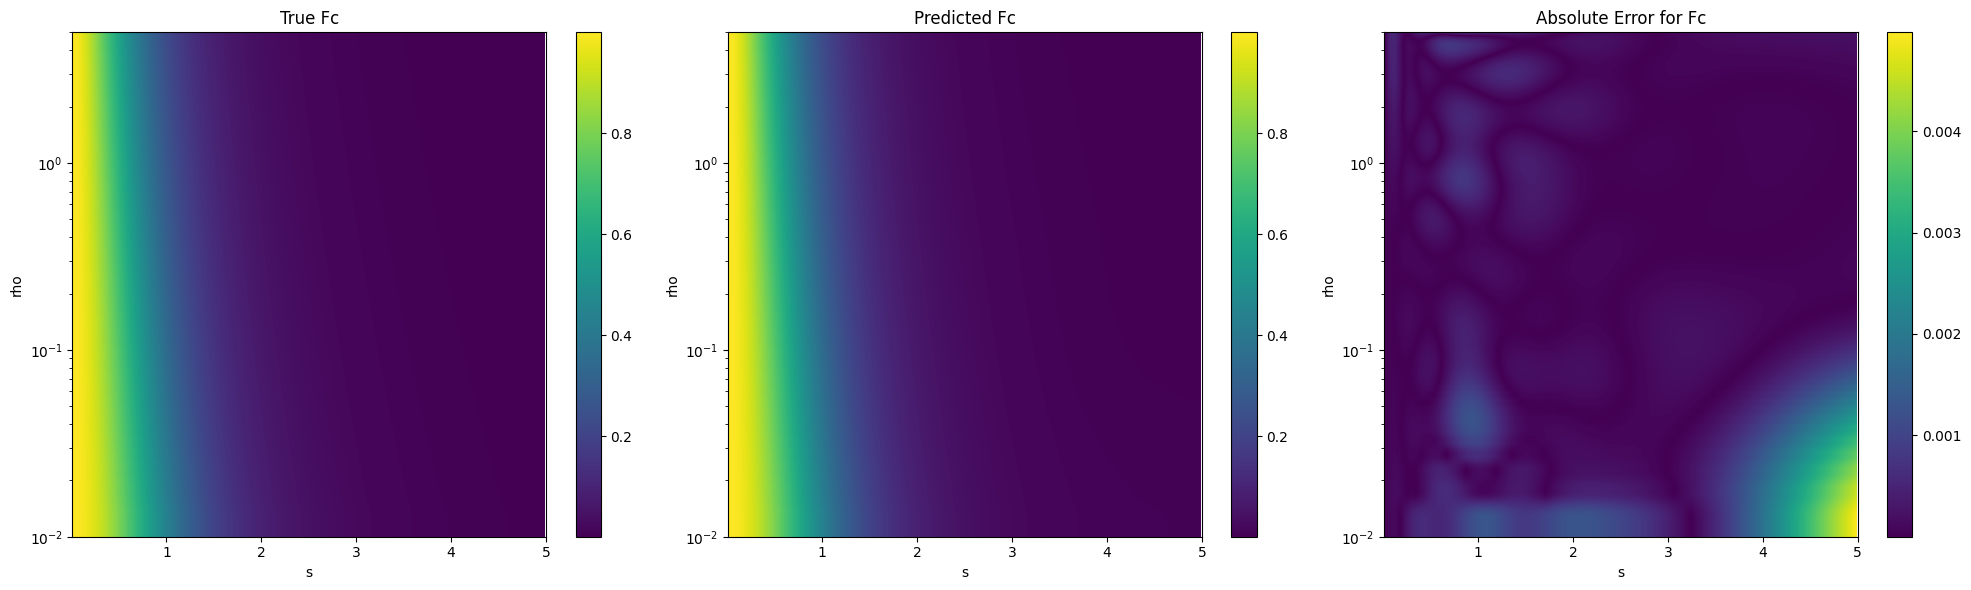

Fx Statistics:
R-squared: 0.997549
Mean Absolute Error: 0.004695
Root Mean Squared Error: 0.011360
Maximum Absolute Error: 0.042501

Fc Statistics:
R-squared: 0.999999
Mean Absolute Error: 0.000129
Root Mean Squared Error: 0.000219
Maximum Absolute Error: 0.004975


In [21]:
# Generate test points
NUM_RHO = 1000  # Number of different rho values to test
NUM_S = 1000  # Number of s values for each rho

START_S, STOP_S = 0.01, 5  # Adjust these values as needed
START_RHO, STOP_RHO = 0.01, 5  # Range of rho values to test

test_s = jnp.linspace(START_S, STOP_S, num=NUM_S)
test_rho = jnp.linspace(START_RHO, STOP_RHO, num=NUM_RHO)

# Create meshgrid for s and rho
s_mesh, rho_mesh = jnp.meshgrid(test_s, test_rho)

# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * rho_mesh)**(1/3)
grad_rho_test = 2 * s_mesh * k_F_test * rho_mesh
sigma = grad_rho_test**2

# Prepare inputs for the neural networks
test_inputs = jnp.stack([rho_mesh.flatten(), sigma.flatten()], axis=1)
test_sinputs = jnp.stack([rho_mesh.flatten(), s_mesh.flatten()], axis=1)
test_inputs_normalized = (test_inputs - inputs_mean) / (inputs_std + 1e-8)

# Calculate true PBE enhancement factors
true_fx_test = Fx(rho_mesh.flatten(), grad_rho_test.flatten())
true_fc_test = Fc(rho_mesh.flatten(), grad_rho_test.flatten())

# Predict using neural networks
# pred_fx_normalized = jax.vmap(model_fx)(test_inputs_normalized).squeeze()
# pred_fx = pred_fx_normalized * true_fx_std + true_fx_mean
pred_fx = jax.vmap(model_fxggsig)(test_inputs)

# pred_fc_normalized = jax.vmap(model_fc)(test_inputs_normalized).squeeze()
# pred_fc = pred_fc_normalized * true_fc_std + true_fc_mean
pred_fc = jax.vmap(model_fcggsig)(test_inputs)

# Reshape results
true_fx_test = true_fx_test.reshape(NUM_RHO, NUM_S)
true_fc_test = true_fc_test.reshape(NUM_RHO, NUM_S)
pred_fx = pred_fx.reshape(NUM_RHO, NUM_S)
pred_fc = pred_fc.reshape(NUM_RHO, NUM_S)

# Function to calculate statistics
def calculate_stats(true, pred):
    true_flat = true.flatten()
    pred_flat = pred.flatten()
    
    # R-squared
    ss_res = np.sum((true_flat - pred_flat) ** 2)
    ss_tot = np.sum((true_flat - np.mean(true_flat)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(true_flat - pred_flat))
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean((true_flat - pred_flat) ** 2))
    
    # Maximum Absolute Error
    max_error = np.max(np.abs(true_flat - pred_flat))
    
    return r2, mae, rmse, max_error

# Calculate statistics
r2_fx, mae_fx, rmse_fx, max_error_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc, max_error_fc = calculate_stats(true_fc_test, pred_fc)

# Plotting
def plot_heatmap(true, pred, title, rho_values, s_values):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    im1 = ax1.imshow(true, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax1.set_title(f'True {title}')
    ax1.set_xlabel('s')
    ax1.set_ylabel('rho')
    ax1.set_yscale('log')
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(pred, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax2.set_title(f'Predicted {title}')
    ax2.set_xlabel('s')
    ax2.set_ylabel('rho')
    ax2.set_yscale('log')
    fig.colorbar(im2, ax=ax2)
    
    error = np.abs(true - pred)
    im3 = ax3.imshow(error, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax3.set_title(f'Absolute Error for {title}')
    ax3.set_xlabel('s')
    ax3.set_ylabel('rho')
    ax3.set_yscale('log')
    fig.colorbar(im3, ax=ax3)
    
    plt.tight_layout()
    plt.show()

# Plot heatmaps
plot_heatmap(true_fx_test, pred_fx, 'Fx', test_rho, test_s)
plot_heatmap(true_fc_test, pred_fc, 'Fc', test_rho, test_s)

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {max_error_fx:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {max_error_fc:.6f}")

# Section: Testing

In this section, we will be testing the accuracy of our network is agreeing with the various energy densities, potentials, and derivatives to verify that our network is correctly predicting our target.

## An Interface to PySCF

There is a brief description of how to customize an XC functional in PySCF [here](https://pyscf.org/user/dft.html). The github repo has further examples [here](https://github.com/pyscf/pyscf/blob/master/examples/dft/24-custom_xc_functional.py) and [here](https://github.com/pyscf/pyscf/blob/master/examples/dft/24-define_xc_functional.py). The prior focuses on custom combinations of existing functionals, while the latter focuses on truly custom functionals.

We must first, however, generate the density expected by PySCF.
- Get the atomic orbitals and coordinates for a given calculation
- Use those in generating the density values
- Convert to the expected network inputs

The first `eval_xc` function below will be ignoring the `vrho` and `vgamma` values used in the SCF cycle for a GGA, to illustrate the error in `Exc` generated from not utilizing these values.

In [22]:
import pyscf
from pyscf import dft, scf, gto
print(pyscf.__version__)

2.3.0


In [23]:
mol = gto.M(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol.verbose = 0
mf = dft.RKS(mol)
mf.grids.level = 1
mf.xc = 'pbe'
mf.kernel()

-76.33342437818288

In [24]:
Epbe = mf.e_tot
mf.scf_summary['e_tot'] = mf.e_tot
mf.scf_summary

{'e1': -123.16726249308127,
 'coul': 46.92503796722739,
 'exc': -9.279458270075114,
 'nuc': 9.188258417746113,
 'e_tot': -76.33342437818288}

In [25]:
#deriv = 1 for GGA rho input
ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=1)
dm = mf.make_rdm1()
rho = dft.numint.eval_rho(mol, ao, dm, xctype='GGA')

In [26]:
h2o_heg_x = dft.libxc.eval_xc(1, rho, spin=0, deriv=0)[0]
h2o_heg_c = dft.libxc.eval_xc(12, rho, spin=0, deriv=0)[0]

What derivatives does LibXC calculate for PBE?

In [27]:
heg_rho_array = np.zeros((6, len(rho_flat)))  # Initialize the rho_array with the correct shape. Only the first element (rho) matters, so the rest are populated with 0. 
heg_rho_array[0, :] = rho_flat  # Populate first array value with rho
e_heg_c = dft.libxc.eval_xc(',LDA_C_PW', heg_rho_array, spin=0, deriv=1)
e_heg_x = dft.libxc.eval_xc('LDA_X,', heg_rho_array, spin=0, deriv=1)
print(len(e_heg_c), len(e_heg_x))
print(e_heg_c, e_heg_x)
print([len(i) for i in e_heg_c if  type(i) != type(None)])
print([len(i) for i in e_heg_x if type(i) != type(None)])

4 4
(array([-0.0376977 , -0.03792128, -0.03814554, ..., -0.08430881,
       -0.08462633, -0.08494425]), [array([-0.04387606, -0.04411862, -0.04436182, ..., -0.09309108,
       -0.09341977, -0.09374881])], None, None) (array([-0.15911766, -0.16104563, -0.16299696, ..., -1.23286049,
       -1.24779861, -1.26291773]), [array([-0.21215688, -0.21472751, -0.21732929, ..., -1.64381399,
       -1.66373148, -1.6838903 ])], None, None)
[29756, 1]
[29756, 1]


So the second-order functional derivatives are not being calculated, which is good for us in terms of computational efficiency. We just need to generate the energy densities and the potentials associated with them. **Notably, the returned `vxc` is of length one, indicating only `vrho` is returned.**

# Grid-point gradients
As libxc expects the derivatives w.r.t. the energy *density*, not the integrated exchange-correlation energy, we must modify what `eval_xc` does.

In [28]:
func_lda_x = pylibxc.LibXCFunctional("lda_x", "unpolarized")
func_lda_c_pw = pylibxc.LibXCFunctional("lda_c_pw", "unpolarized")

In [29]:
inp = {}
inp['rho'] = rho[0]
inp['sigma'] = np.sqrt(rho[1]**2+rho[2]**2+rho[3]**2)

In [30]:
ret_lda_x = func_lda_x.compute(inp)
ret_lda_c = func_lda_c_pw.compute(inp)

In [31]:
rho0 = rho[0]

In [32]:
h2o_lda_x = lda_x(rho0)
h2o_lda_c = lda_c_pw(rho0)
tvf = jax.vmap(lambda x: pw92c(x, nspin=1))
h2o_lda_c2, tv2 = tvf(rho0[:, jnp.newaxis])
h2o_lda_c3 = pw92c_unpolarized(rho0)

In [33]:
print('CODED Exchange Energy Density vs. PySCF.DFT.LIBXC: MAE = ', jnp.mean(abs(h2o_heg_x - h2o_lda_x)))
print('CODED Correlation Energy Density vs. PySCF.DFT.LIBXC: MAE = ', jnp.mean(abs(h2o_heg_c - h2o_lda_c)))
print('Marivi CODED Correlation Energy Density vs. PySCF.DFT.LIBXC: MAE = ', jnp.mean(abs(h2o_heg_c - h2o_lda_c2)))
print('Josh version CODED Correlation Energy Density vs. PySCF.DFT.LIBXC: MAE = ', jnp.mean(abs(h2o_heg_c - h2o_lda_c3)))

CODED Exchange Energy Density vs. PySCF.DFT.LIBXC: MAE =  6.435331325509359e-17
CODED Correlation Energy Density vs. PySCF.DFT.LIBXC: MAE =  5.177038468194449e-05
Marivi CODED Correlation Energy Density vs. PySCF.DFT.LIBXC: MAE =  7.037022604021681e-08
Josh version CODED Correlation Energy Density vs. PySCF.DFT.LIBXC: MAE =  8.477475567407867e-18


Based on above, our `eval_xc` calls should rely on the `lda_x` functions and the `pw92c_unpolarized` functions.

In [34]:
print('CODED Exchange Energy Density vs. PYLIBXC: MAE = ', jnp.mean(abs(ret_lda_x['zk'] - h2o_lda_x)))
print('CODED Correlation Energy Density vs. PYLIBXC: MAE = ', jnp.mean(abs(ret_lda_c['zk'] - h2o_lda_c)))
print('CODED Correlation Energy Density vs. PYLIBXC: MAE = ', jnp.mean(abs(ret_lda_c['zk'] - h2o_lda_c2)))

CODED Exchange Energy Density vs. PYLIBXC: MAE =  1.9595437959399492e-16
CODED Correlation Energy Density vs. PYLIBXC: MAE =  5.1770384681939786e-05
CODED Correlation Energy Density vs. PYLIBXC: MAE =  7.037022604491869e-08


In [35]:
func_lda_c_pw.compute({'rho': 1.0}, do_vxc = False)

[array([[-0.07120031]])]

## Testing the Potential

Per [this question/answer exchange](https://mattermodeling.stackexchange.com/questions/3650/how-does-libxc-calculate-the-potential-of-gga-functionals), the GGA potential is constructed via $$v_{xc} = \epsilon + \rho \frac{\partial\epsilon}{\partial\rho} + 2\nabla\cdot \left( \rho \frac{\partial\epsilon}{\partial\sigma}\nabla\rho\right),$$ where $\sigma = |\nabla\rho|^2$. For an LDA calculation, the only two contributing terms are the first two. Below we test whether our network can achieve the same results as `pylibxc` for these values.

Expanding out the gradient contraction above yields $$v_{xc} = \epsilon + \rho \frac{\partial\epsilon}{\partial\rho} + 2 \left( \frac{\partial\epsilon}{\partial\sigma} + \rho \frac{\partial^2\epsilon}{\partial\rho\partial\sigma} \right) \sigma - 2\rho \frac{\partial^2\epsilon}{\partial\sigma^2} \nabla\rho\cdot\nabla\sigma - 2\rho \frac{\partial\epsilon}{\partial\sigma} \nabla^2\rho,$$ which, when neglecting derivatives of higher order, approximates to $$v_{xc} \sim \epsilon + \rho \frac{\partial\epsilon}{\partial\rho} + 2 \left( \frac{\partial\epsilon}{\partial\sigma}\right) \sigma.$$

*This approximation is just to test the agreement between the outputs of `pylibxc` and the network's derivatives, and is not intended to be an accurate measure of the true value of $v_{xc}$.*

In [36]:
mol = gto.M(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol.verbose = 0
mf = dft.RKS(mol)
mf.grids.level = 1
mf.xc = 'pbe'
mf.kernel()
ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=1)
dm = mf.make_rdm1()
rho = dft.numint.eval_rho(mol, ao, dm, xctype='GGA')

In [37]:
#the functions to compute the exc
func_lda_x = pylibxc.LibXCFunctional("lda_x", "unpolarized")
func_lda_c_pw = pylibxc.LibXCFunctional("lda_c_pw", "unpolarized")
func_pbe_x = pylibxc.LibXCFunctional("gga_x_pbe", "unpolarized")
func_pbe_c = pylibxc.LibXCFunctional("gga_c_pbe", "unpolarized")

inp = {}
inp['rho'] = rho[0]
inp['sigma'] = rho[1]**2+rho[2]**2+rho[3]**2
inp['gamma'] = np.sqrt(inp['sigma'])

ret_lda_x = func_lda_x.compute(inp)
ret_lda_c = func_lda_c_pw.compute(inp)
ret_pbe_x = func_pbe_x.compute(inp)
ret_pbe_c = func_pbe_c.compute(inp)

plxc_lda_vx = ret_lda_x['zk'] + inp['rho']*ret_lda_x['vrho']
plxc_lda_vc = ret_lda_c['zk'] + inp['rho']*ret_lda_c['vrho']

plxc_pbe_vx = ret_pbe_x['zk'] + inp['rho']*ret_pbe_x['vrho'] + 2*ret_pbe_x['vsigma']*inp['sigma']
plxc_pbe_vc = ret_pbe_c['zk'] + inp['rho']*ret_pbe_c['vrho'] + 2*ret_pbe_c['vsigma']*inp['sigma']

In [38]:
ret_lda_x.keys(), ret_pbe_x.keys()

(dict_keys(['zk', 'vrho']), dict_keys(['zk', 'vrho', 'vsigma']))

We have used `pylibxc` to construct the LDA energy densities and the associated derivative, and the PBE energy densities and derivatives.

We must now use the networks to:
- generate the separate $\epsilon_{x/c}$ values
- find the derivatives w.r.t. $\rho$ (for the LDA case, where $s$=0)
- find the derivatives w.r.t. $\sigma$ (for the GGA case)

In [39]:
def calc_exc_vxc_lda(rho, xmodel, cmodel, vvv=False):
    grho = np.zeros_like(rho)
    stacked_inputs = jnp.stack([rho, grho], axis=1)

    #calculate ex, assuming grho is 0
    Fx = jax.vmap(xmodel)(stacked_inputs)
    #calculate ec, assuming grho is 0
    Fc = jax.vmap(cmodel)(stacked_inputs)
    if vvv:
        print(Fx, Fc, Fx.mean(), Fc.mean())
    ex = Fx*lda_x(rho)
    ec = Fc*pw92c_unpolarized(rho)

    return ex, ec

def calc_exc_vxc_pbe(rho, grho, xmodel, cmodel, do_v = False, vvv=False):
    stacked_inputs = jnp.stack([rho, grho], axis=1)

    def calc_ex(rho, grho):
        ex_stacked_inputs = jnp.stack([rho, grho], axis=1)

        return lda_x(rho) * jax.vmap(xmodel)(ex_stacked_inputs)
    def calc_ec(rho, grho):
        ec_stacked_inputs = jnp.stack([rho, grho], axis=1)

        return pw92c_unpolarized(rho) * jax.vmap(cmodel)(ec_stacked_inputs)
    def calc_rhoex(inputs):
        rho, sig = inputs
        #convert sigma to gamma to pass to network
        ex_stacked_inputs = jnp.stack([rho, jnp.sqrt(sig)], axis=0)
        if vvv:
            print('calc_rhoex inputs shape', inputs.shape)
            print('calc_rhoex inputs', inputs, inputs[0], inputs[1])
            print('ex_stacked_inputs shape', ex_stacked_inputs.shape)
        return rho*lda_x(rho) * xmodel(ex_stacked_inputs)
    def calc_rhoec(inputs):
        rho, sig = inputs
        #convert sigma to gamma to pass to network
        ec_stacked_inputs = jnp.stack([rho, jnp.sqrt(sig)], axis=0)
        ret = rho*pw92c_unpolarized(rho) * cmodel(ec_stacked_inputs)
        return ret[0]

    ex = calc_ex(rho, grho)
    ec = calc_ec(rho, grho)

    if do_v:
        sigma = grho**2
        vinp = jnp.stack([rho, sigma], axis=1)
        if vvv:
            print('vinp shape', vinp.shape)
        vxf = jax.grad(calc_rhoex)
        vcf = jax.grad(calc_rhoec)
        
        vxr = jax.vmap(vxf)(vinp)
        vcr = jax.vmap(vcf)(vinp)

        return ex, vxr, ec, vcr
    else:
        return ex, ec

In [40]:
lda_ex, lda_ec = calc_exc_vxc_lda(inp['rho'], xmodel=model_fxg, cmodel=model_fcg, vvv=True)
np.mean( abs(lda_ex - ret_lda_x['zk'])), np.mean( abs(lda_ec - ret_lda_c['zk']))

[1. 1. 1. ... 1. 1. 1.] [1. 1. 1. ... 1. 1. 1.] 1.0 1.0


(Array(1.95817186e-16, dtype=float64), Array(3.83649407e-18, dtype=float64))

The above example is not very illuminating. By construction our enhancement factors are 1 when the gradient (or s) is 0, and thus just multiply the HEG and show that our HEG functions give the values that pylibxc does.

For a more useful comparison, we must use the PBE function.

In [41]:
pbe_ex, pbe_ec = calc_exc_vxc_pbe(inp['rho'], inp['gamma'], xmodel=model_fxg, cmodel=model_fcg)
np.mean( abs(pbe_ex - ret_pbe_x['zk'])), np.mean( abs(pbe_ec - ret_pbe_c['zk']))

(Array(5.3717901e-05, dtype=float64), Array(0.00313213, dtype=float64))

In [42]:
pbe_ex, pbe_ec = calc_exc_vxc_pbe(inp['rho'], inp['gamma'], xmodel=model_fxgg, cmodel=model_fcgg)
np.mean( abs(pbe_ex - ret_pbe_x['zk'])), np.mean( abs(pbe_ec - ret_pbe_c['zk']))

(Array(2.27105909e-05, dtype=float64), Array(0.00316752, dtype=float64))

The above values show that our enhancement factors, trained on a regular grid of $\rho$ and $|\nabla\rho|$ values, have different levels of performance.

The testing MAE errors for these networks were on the order of $10^{-4}$ for each. While we see similar levels of accuracy for the exchange network, the correlation network predictions are an order of magnitude less accurate.

In [43]:
pbe_ex, pbe_vxr, pbe_ec, pbe_vcr = calc_exc_vxc_pbe(inp['rho'], inp['gamma'], xmodel=model_fxg, cmodel=model_fcg, do_v=True, vvv=False)
print('x: MAE(pylibxc e - network e)', np.mean( abs( pbe_ex - ret_pbe_x['zk'])))
print('x: MAE(pylibxc vrho - network vrho)', np.mean( abs( pbe_vxr[:, 0] - ret_pbe_x['vrho'])))
print('x: MAE(pylibxc vsig - network vsig)', np.mean( abs( pbe_vxr[:, 1] - ret_pbe_x['vsigma'])))
print()
print('c: MAE(pylibxc e - network e)', np.mean( abs( pbe_ec - ret_pbe_c['zk'])))
print('c: MAE(pylibxc vrho - network vrho)', np.mean( abs( pbe_vcr[:, 0] - ret_pbe_c['vrho'])))
print('c: MAE(pylibxc vsig - network vsig)', np.mean( abs( pbe_vcr[:, 1] - ret_pbe_c['vsigma'])))

x: MAE(pylibxc e - network e) 5.3717900957173586e-05
x: MAE(pylibxc vrho - network vrho) 0.00012941894116818396
x: MAE(pylibxc vsig - network vsig) 0.18453688700146403

c: MAE(pylibxc e - network e) 0.003132126404077973
c: MAE(pylibxc vrho - network vrho) 0.00665483225359423
c: MAE(pylibxc vsig - network vsig) 0.002286522287779423


In [44]:
pbe_ex, pbe_vxr, pbe_ec, pbe_vcr = calc_exc_vxc_pbe(inp['rho'], inp['gamma'], xmodel=model_fxgg, cmodel=model_fcgg, do_v=True, vvv=False)
print('x: MAE(pylibxc e - network+g e)', np.mean( abs( pbe_ex - ret_pbe_x['zk'])))
print('x: MAE(pylibxc vrho - network+g vrho)', np.mean( abs( pbe_vxr[:, 0] - ret_pbe_x['vrho'])))
print('x: MAE(pylibxc vsig - network+g vsig)', np.mean( abs( pbe_vxr[:, 1] - ret_pbe_x['vsigma'])))
print()
print('c: MAE(pylibxc e - network e)', np.mean( abs( pbe_ec - ret_pbe_c['zk'])))
print('c: MAE(pylibxc vrho - network+g vrho)', np.mean( abs( pbe_vcr[:, 0] - ret_pbe_c['vrho'])))
print('c: MAE(pylibxc vsig - network+g vsig)', np.mean( abs( pbe_vcr[:, 1] - ret_pbe_c['vsigma'])))

x: MAE(pylibxc e - network+g e) 2.271059087143379e-05
x: MAE(pylibxc vrho - network+g vrho) 7.885361119748956e-05
x: MAE(pylibxc vsig - network+g vsig) 0.16809112783178057

c: MAE(pylibxc e - network e) 0.0031675218166339046
c: MAE(pylibxc vrho - network+g vrho) 0.006798715764861303
c: MAE(pylibxc vsig - network+g vsig) 0.0023726516012336145


In [45]:
#construct the potentials only to the LDA level and compare
pbe_vx = pbe_ex + inp['rho']*pbe_vxr[:, 0] 
pbe_vc = pbe_ec + inp['rho']*pbe_vcr[:, 0]
np.mean( abs(pbe_vx - (ret_pbe_x['zk'] + inp['rho']*ret_pbe_x['vrho']))), np.mean( abs(pbe_vc - (ret_pbe_c['zk'] + inp['rho']*ret_pbe_c['vrho'])))

(Array(0.00083413, dtype=float64), Array(1.1097075, dtype=float64))

In [46]:
pbe_vx = pbe_ex + inp['rho']*pbe_vxr[:, 0] + 2*pbe_vxr[:, 1]*inp['sigma']
pbe_vc = pbe_ec + inp['rho']*pbe_vcr[:, 0] + 2*pbe_vcr[:, 1]*inp['sigma']
np.mean( abs(pbe_vx - plxc_pbe_vx)), np.mean( abs(pbe_vc - plxc_pbe_vc))

(Array(0.00025738, dtype=float64), Array(0.79118293, dtype=float64))

## SCF characteristic comparison between these trained networks as a function of the number of SCF steps.

Per the [equinox documentation](https://docs.kidger.site/equinox/api/transformations/#automatic-differentiation), if we want derivatives w.r.t. both of the inputs (rho and sigma), we need to wrap these functions in one that unpacks a tuple passing them both.

In [56]:
FXNET = model_fxggsig
FCNET = model_fcggsig
# FXNET = model_fxgsig
# FCNET = model_fcgsig

def custom_pbe_Fx(rho, sigma, XNET = None):
    #this will be a call to the Fx neural network we want
    # print('DEBUG custom_pbe_Fx, rho/sigma shapes: ', rho.shape, sigma.shape)
    # print('DEBUG custom_pbe_Fx: rho: ', rho)
    # print('DEBUG custom_pbe_Fx: sigma: ', sigma)

    Fx = XNET([rho, sigma])
    return Fx

def custom_pbe_Fc(rho, sigma, CNET = None): #Assumes zeta = 0
    #this will be a call to the Fc neural network we want
    Fc = CNET([rho, sigma])
    return Fc

def custom_pbe_e(rho, sigma, XNET = None, CNET = None):
    Fx = custom_pbe_Fx(rho, sigma, XNET = XNET)
    Fc = custom_pbe_Fc(rho, sigma, CNET = CNET)

    exc = lda_x(rho)*Fx + pw92c_unpolarized(rho)*Fc

    return exc

def custom_pbe_epsilon(rho, sigma, XNET = None, CNET = None):

    return rho*custom_pbe_e(rho, sigma, XNET = XNET, CNET = CNET)

def derivable_custom_pbe_e(rhosigma, XNET = None, CNET = None):
    rho, sigma = rhosigma
    # print('DEBUG derivable_custom_pbe_e: rhosigma len/shapes: ', len(rhosigma), rhosigma)
    # print('DEBUG derivable_custom_pbe_e: rho/sigma shapes: ', rho.shape, sigma.shape)
    # print('DEBUG derivable_custom_pbe_e: rho: ', rho)
    # print('DEBUG derivable_custom_pbe_e: sigma: ', sigma)
    return custom_pbe_e(rho, sigma, XNET = XNET, CNET = CNET)

def derivable_custom_pbe_epsilon(rhosigma, XNET = None, CNET = None):
    rho = rhosigma[0]
    sigma = rhosigma[1]
    result = custom_pbe_epsilon(rho, sigma, XNET = XNET, CNET = CNET)
    return result[0]
    
def eval_xc_gga_j(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None,
                 XNET = None, CNET = None):
    #we only expect there to be a rho0 array, but I unpack it as (rho, deriv) here to be in line with the
    #pyscf example -- the size of the 'rho' array depends on the xc type (LDA, GGA, etc.)
    #so since LDA calculation, check for size first.
    rho0, dx, dy, dz = rho[:4]
    rho0 = jnp.array(rho0)
    sigma = jnp.array(dx**2+dy**2+dz**2)
    # print('DEBUG eval_xc_gga_j: rho0/sigma shapes: ', rho0.shape, sigma.shape)
    rhosig = (rho0, sigma)
    #calculate the "custom" energy with rho -- THIS IS e
    #cast back to np.array since that's what pyscf works with
    #pass as tuple -- (rho, sigma)
    derivable_net_e = partial(derivable_custom_pbe_e, XNET = XNET, CNET = CNET)
    derivable_net_epsilon = partial(derivable_custom_pbe_epsilon, XNET = XNET, CNET = CNET)
    exc = np.array(jax.vmap(derivable_net_e)( rhosig ) )
    
    #first order derivatives w.r.t. rho and sigma
    vrho_f = eqx.filter_grad(derivable_net_epsilon)
    vrhosigma = np.array(jax.vmap(vrho_f)( rhosig ))
    # print('vrhosigma shape:', vrhosigma.shape)
    vxc = (vrhosigma[0], vrhosigma[1], None, None)

    # v2_f = eqx.filter_hessian(derivable_custom_pbe_epsilon)
    v2_f = jax.hessian(derivable_net_epsilon)
    # v2_f = jax.hessian(custom_pbe_epsilon, argnums=[0, 1])
    v2 = np.array(jax.vmap(v2_f)( rhosig ))
    # print('v2 shape', v2.shape)
    v2rho2 = v2[0][0]
    v2rhosigma = v2[0][1]
    v2sigma2 = v2[1][1]
    v2lapl2 = None
    vtau2 = None
    v2rholapl = None
    v2rhotau = None
    v2lapltau = None
    v2sigmalapl = None
    v2sigmatau = None
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    #3rd order
    kxc = None
    
    return exc, vxc, fxc, kxc

### Computation using networks trained without gradients

In [59]:
#construct a callable that uses the network that were not trained on gradient information
nongrad_eval = partial(eval_xc_gga_j, XNET = model_fxgsig, CNET = model_fcgsig)
mfcpj = dft.RKS(mol)
mfcpj = mfcpj.define_xc_(nongrad_eval, 'GGA')
mfcpj.kernel()

-76.28791870739634

In [60]:
scf_steps = np.arange(0, 25)
nograd_dct = {step: {} for step in scf_steps}
for step in scf_steps:
    print(step)
    this_mf = dft.RKS(mol)
    this_mf = this_mf.define_xc_(nongrad_eval, 'GGA')
    this_mf.max_cycle = step
    this_mf.kernel()
    this_dct = this_mf.scf_summary
    this_dct['e_tot'] = this_mf.e_tot
    this_dct['veff'] = this_mf.get_veff()
    nograd_dct[step] = this_dct

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [61]:
ref_veff = mf.get_veff()
nograd_errors_dct = {k: [] for k in nograd_dct[1].keys()}
for k in nograd_errors_dct.keys():
    these_errors = []
    for step in scf_steps:
        if k in ['e1', 'coul', 'exc', 'nuc']:        
            these_errors.append( abs(mf.scf_summary[k] - nograd_dct[step][k]))
        elif k == 'e_tot':
            these_errors.append( abs(mf.e_tot - nograd_dct[step][k]))
        elif k == 'veff':
            these_errors.append( np.mean(abs(ref_veff - nograd_dct[step][k])) )

    nograd_errors_dct[k] = these_errors

In [62]:
nograd_errors_dct

{'e1': [1.5736654373353787,
  2.193122130079928,
  4.157171112871396,
  0.08886720325693886,
  0.01565099575574891,
  0.010282979820260607,
  0.007698026597793728,
  0.007663162459650152,
  0.007663162459692785,
  0.0076631624596359416,
  0.007663162459678574,
  0.007663162459721207,
  0.007663162459706996,
  0.007663162459920159,
  0.007663162459664363,
  0.007663162459593309,
  0.007663162459664363,
  0.007663162459664363,
  0.007663162459749628,
  0.007663162459721207,
  0.007663162459806472,
  0.007663162459593309,
  0.007663162459650152,
  0.007663162459863315,
  0.007663162459621731],
 'coul': [1.729918925776417,
  2.607140002640442,
  4.324337113261173,
  0.10016817282853907,
  0.018251805812575128,
  0.012042423619618603,
  0.009152749514669267,
  0.009108627478269682,
  0.00910862747824126,
  0.009108627478184417,
  0.009108627478276787,
  0.009108627478283893,
  0.00910862747824126,
  0.009108627478404685,
  0.009108627478198628,
  0.009108627478191522,
  0.009108627478234155

Text(0.5, 1.0, 'Energy/Veff errors of Network Trained without Gradients\nagainst PBE Reference')

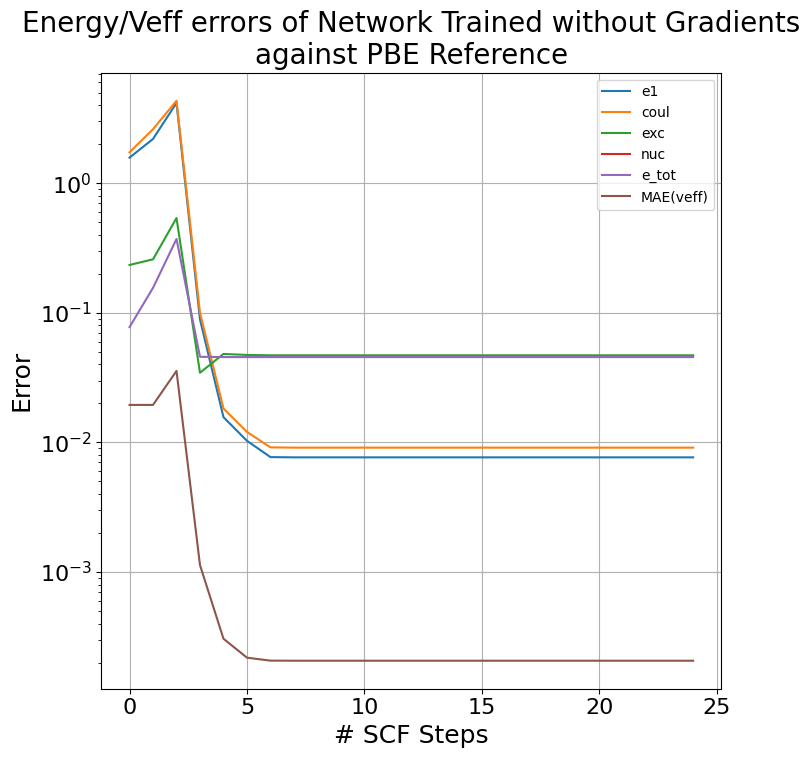

In [63]:
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111)
ax.set_yscale('log')

for k in nograd_errors_dct.keys():
    klab = k
    if k == 'veff':
        klab = 'MAE(veff)'
    ax.plot(scf_steps, nograd_errors_dct[k], label = klab)

ax.tick_params(axis='both', labelsize=16)
ax.legend()
ax.set_xlabel('# SCF Steps', fontsize=18)
ax.set_ylabel('Error', fontsize=18)
ax.grid()
ax.set_title('Energy/Veff errors of Network Trained without Gradients\nagainst PBE Reference', fontsize=20)

In [64]:
print('BASELINE PBE CALCULATION:')
print('Total Energy = {} H'.format(mf.e_tot))
print('SCF Summary and Converged:')
print(mf.scf_summary)
print(mf.converged)
print(10*'=')
print('RESULTS (networks trained without gradients):')
print('Total Energy = {} H'.format(mfcpj.e_tot))
print('SCF Summary and Converged:')
print(mfcpj.scf_summary)
print(mfcpj.converged)
print(10*'=')
print('ERRORS')
print('Total energy: {} H'.format( abs(mf.e_tot - mfcpj.e_tot)))
for k in mf.scf_summary.keys():
    if k in ['e_tot', 'veff']:
        continue
    print('{} : {} H'.format(k, abs(mf.scf_summary[k]-mfcpj.scf_summary[k])))

BASELINE PBE CALCULATION:
Total Energy = -76.33342437818295 H
SCF Summary and Converged:
{'e1': -123.16726249308113, 'coul': 46.92503796722715, 'exc': -9.279458270075086, 'nuc': 9.188258417746113}
True
RESULTS (networks trained without gradients):
Total Energy = -76.28791870739634 H
SCF Summary and Converged:
{'e1': -123.15959933062153, 'coul': 46.915929339748956, 'exc': -9.232507134269882, 'nuc': 9.188258417746113}
True
ERRORS
Total energy: 0.04550567078661061 H
e1 : 0.007663162459593309 H
coul : 0.009108627478191522 H
exc : 0.04695113580520349 H
nuc : 0.0 H


### Computation using networks trained with gradients

In [65]:
#construct a callable that uses the network that were trained on gradient information
grad_eval = partial(eval_xc_gga_j, XNET = model_fxggsig, CNET = model_fcggsig)
mfcpj = dft.RKS(mol)
mfcpj = mfcpj.define_xc_(grad_eval, 'GGA')
mfcpj.kernel()

-76.28908395041037

In [66]:
scf_steps = np.arange(0, 25)
grad_dct = {step: {} for step in scf_steps}
for step in scf_steps:
    print(step)
    this_mf = dft.RKS(mol)
    this_mf = this_mf.define_xc_(grad_eval, 'GGA')
    this_mf.max_cycle = step
    this_mf.kernel()
    this_dct = this_mf.scf_summary
    this_dct['e_tot'] = this_mf.e_tot
    this_dct['veff'] = this_mf.get_veff()
    grad_dct[step] = this_dct
ref_veff = mf.get_veff()
grad_errors_dct = {k: [] for k in grad_dct[1].keys()}
for k in grad_errors_dct.keys():
    these_errors = []
    for step in scf_steps:
        if k in ['e1', 'coul', 'exc', 'nuc']:        
            these_errors.append( abs(mf.scf_summary[k] - grad_dct[step][k]))
        elif k == 'e_tot':
            these_errors.append( abs(mf.e_tot - grad_dct[step][k]))
        elif k == 'veff':
            these_errors.append( np.mean(abs(ref_veff - grad_dct[step][k])) )

    grad_errors_dct[k] = these_errors

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


Text(0.5, 1.0, 'Energy/Veff errors of Network Trained with Gradients\nagainst PBE Reference')

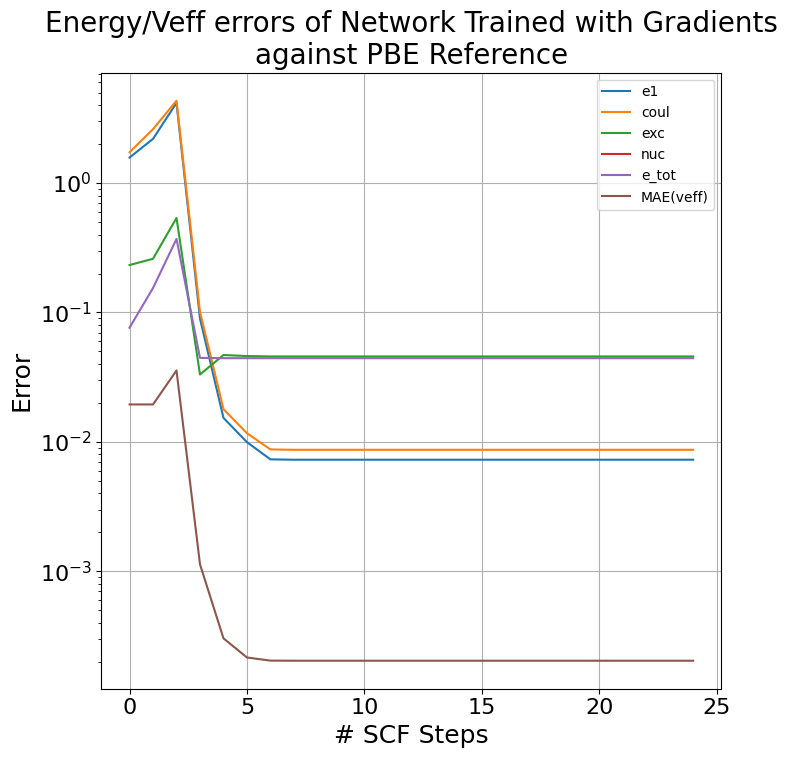

In [67]:
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111)
ax.set_yscale('log')

for k in grad_errors_dct.keys():
    klab = k
    if k == 'veff':
        klab = 'MAE(veff)'
    ax.plot(scf_steps, grad_errors_dct[k], label = klab)

ax.tick_params(axis='both', labelsize=16)
ax.legend()
ax.set_xlabel('# SCF Steps', fontsize=18)
ax.set_ylabel('Error', fontsize=18)
ax.grid()
ax.set_title('Energy/Veff errors of Network Trained with Gradients\nagainst PBE Reference', fontsize=20)

In [68]:
print('BASELINE PBE CALCULATION:')
print('Total Energy = {} H'.format(mf.e_tot))
print('SCF Summary and Converged:')
print(mf.scf_summary)
print(mf.converged)
print(10*'=')
print('RESULTS (networks trained with gradients):')
print('Total Energy = {} H'.format(mfcpj.e_tot))
print('SCF Summary and Converged:')
print(mfcpj.scf_summary)
print(mfcpj.converged)
print(10*'=')
print('ERRORS')
print('Total energy: {} H'.format( abs(mf.e_tot - mfcpj.e_tot)))
for k in mf.scf_summary.keys():
    if k in ['e_tot', 'veff']:
        continue
    print('{} : {} H'.format(k, abs(mf.scf_summary[k]-mfcpj.scf_summary[k])))

BASELINE PBE CALCULATION:
Total Energy = -76.33342437818295 H
SCF Summary and Converged:
{'e1': -123.16726249308113, 'coul': 46.92503796722715, 'exc': -9.279458270075086, 'nuc': 9.188258417746113}
True
RESULTS (networks trained with gradients):
Total Energy = -76.28908395041037 H
SCF Summary and Converged:
{'e1': -123.1599788373177, 'coul': 46.916348661224475, 'exc': -9.233712192063258, 'nuc': 9.188258417746113}
True
ERRORS
Total energy: 0.04434042777258185 H
e1 : 0.0072836557634303745 H
coul : 0.008689306002672481 H
exc : 0.04574607801182751 H
nuc : 0.0 H


# BELOW THIS IS DEVELOPMENT -- IGNORE

## PySCF Interface

In [ ]:
mol = gto.M(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol.verbose = 0
pmf = dft.RKS(mol)
pmf.grids.level = 1
pmf.xc = 'pbe'
pmf.kernel()

In [ ]:
print(pmf.scf_summary)
#deriv = 1 for GGA rho input
ao = dft.numint.eval_ao(mol, pmf.grids.coords, deriv=1)
dm = mf.make_rdm1()
rho = dft.numint.eval_rho(mol, ao, dm, xctype='GGA')
print(rho.shape)

In [ ]:
func_lda_x = pylibxc.LibXCFunctional("lda_x", "unpolarized")
func_lda_c_pw = pylibxc.LibXCFunctional("lda_c_pw", "unpolarized")
h2o_lda_x = func_lda_x.compute({'rho':rho[0]})
h2o_lda_c = func_lda_c_pw.compute({'rho':rho[0]})
rho_flat = rho[0].flatten()
heg_rho_array = np.zeros((6, len(rho_flat)))  # Initialize the rho_array with the correct shape. Only the first element (rho) matters, so the rest are populated with 0. 
heg_rho_array[0, :] = rho_flat  # Populate first array value with rho
e_heg_c = dft.libxc.eval_xc(',LDA_C_PW', heg_rho_array, spin=0, deriv=1)
e_heg_x = dft.libxc.eval_xc('LDA_X,', heg_rho_array, spin=0, deriv=1)
print(len(e_heg_c), len(e_heg_x))
print(e_heg_c, e_heg_x)
print([len(i) for i in e_heg_c if  type(i) != type(None)])
print([len(i) for i in e_heg_x if type(i) != type(None)])

In [ ]:
#store as global values for use in function below
GRIDC = pmf.grids.coords
GRIDW = pmf.grids.weights

def get_heg_ec(rho):
    inp = {'rho':rho}
    print(f'get_heg_ec rho  = {rho}')
    shape = jax.core.ShapedArray( rho.shape, rho[0].dtype)
    compute_func = lambda x: func_lda_c_pw.compute(x, do_vxc=False)
    calc = jax.pure_callback(compute_func, shape, inp, vectorized=True)[0]
    return calc
def get_heg_ec_vrho(rho):
    shape = jax.core.ShapedArray( rho.shape, rho[0].dtype)
    compute_func = lambda x: func_lda_c_pw.compute(x, do_exc=False)
    calc = jax.pure_callback(compute_func, shape, inp, vectorized=True)[0]
    return vrho
def get_heg_ec2(rho):
    calc = lda_c_pw(rho)
    return calc
    
def get_heg_ex(rho):
    return lda_x(rho)

get_heg_ec = custom_jvp(get_heg_ec)
get_heg_ex = custom_jvp(get_heg_ex)

@get_heg_ec.defjvp
def _get_heg_ec_jvp(primals, tangents):
    rho = primals
    rho_dot = tangents
    # calc_zk = get_heg_ec(rho, sigma)
    return get_heg_ec(rho), get_heg_ec_vrho(rho)

@get_heg_ex.defjvp
def _get_heg_ex_jvp(primals, tangents):
    rho = primals[0]
    rho_dot = tangents
    first = -3/4*(3/jnp.pi)**(1/3)*rho**(1/3)
    deriv = (1/3)*(-3/4)*(3/jnp.pi)**(1/3)/(rho**2/3 + 1e-10)
    return first, deriv

#A new function using specifically the networks that have the modified LOB wrapping function to avoid nans in gradients
def net_eval_xc_g(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None, rhoxexc = False):
    #flag to determine changing jax arrays to numpy on return
    CONVERT_TO_NUMPY = True

    print(f'eval_xc call rho shape = {rho.shape}')
    frho0, fdx, fdy, fdz = rho[:4]
    fsigma = fdx**2 + fdy**2 + fdz**2
    fgamma = jnp.sqrt(fsigma)
    frho0 = jnp.maximum(1e-11, frho0) #Prevents division by 0
    print(f'frho0 max = {frho0.max()}')
    print(f'frho0 shape = {frho0.shape}')
    finputs = jnp.stack([frho0, fsigma], axis=1)
    
    def get_exc(inputs):    
        rho0 = inputs[0, jnp.newaxis]
        sigma = inputs[1, jnp.newaxis]
        gamma = jnp.sqrt(sigma)
        inp = {}
        inp['rho'] = rho0[0]
        inp['sigma'] = gamma[0]

        e_heg_x = lda_x(rho0[0])
        e_heg_c = pw92c_unpolarized(rho0[0])
    
        # print(f'e_heg_c shape = {e_heg_c.shape}, e_heg_x shape = {e_heg_x.shape}')
        # print(f'e_heg_c = {e_heg_c}, e_heg_x = {e_heg_x}')        
        k_F = (3 * jnp.pi**2 * rho0)**(1/3)
        s = gamma/(2*k_F*rho0+1e-10)
        Fx = model_fxgg(inputs)
        sinputs = jnp.array( [rho0, s])[:, 0]
        print('sinputs shape', sinputs.shape)
        Fc = model_fcgg(inputs)
        exc = e_heg_x*Fx + e_heg_c*Fc
        return exc[0]
    def get_rhoxexc(inputs):    
        rho0 = inputs[0, jnp.newaxis]
        sigma = inputs[1, jnp.newaxis]
        gamma = jnp.sqrt(sigma)
        inp = {}
        inp['rho'] = rho0[0]
        inp['sigma'] = gamma[0]

        e_heg_x = lda_x(rho0[0])
        e_heg_c = pw92c_unpolarized(rho0[0])
    
        # print(f'e_heg_c shape = {e_heg_c.shape}, e_heg_x shape = {e_heg_x.shape}')
        # print(f'e_heg_c = {e_heg_c}, e_heg_x = {e_heg_x}')        
        k_F = (3 * jnp.pi**2 * rho0)**(1/3)
        s = gamma/(2*k_F*rho0+1e-10)
        Fx = model_fxgg(inputs)
        sinputs = jnp.array( [rho0, s])[:, 0]
        print('sinputs shape', sinputs.shape)
        Fc = model_fcgg(inputs)
        exc = rho0*(e_heg_x*Fx + e_heg_c*Fc)
        return exc[0]

    if not rhoxexc:
        v_and_g = eqx.filter_value_and_grad(get_exc)
        hess = eqx.filter_hessian(get_exc)
        
        exc, v = jax.vmap(v_and_g)(finputs)
        h = jax.vmap(hess)(finputs)
    else:
        exc = jax.vmap(get_exc)(finputs)
    
        vf = eqx.filter_grad(get_rhoxexc)
        hf = eqx.filter_hessian(get_rhoxexc)
    
        v = jax.vmap(vf)(finputs)
        h = jax.vmap(hf)(finputs)
    print(f'exc shape = {exc.shape}')
    print(f'exc stats: max/min/mean = {exc.max()}, {exc.min()}, {exc.mean()}')
    # print(f'v shape = {v.shape}')
    # print(f'h shape = {h.shape}')
    # print(f'v nans = {jnp.sum(jnp.isnan(v))}')
    # print(f'h nans = {jnp.sum(jnp.isnan(h))}')
    
    #need functional derivatives for the potentials:
    vrho = v[:, 0]
    vgamma = v[:, 1]
    vlapl = None
    vtau = None
    
    #second order derivatives
    # per jax docs, indices [Hf]_{i,j} = d2f/(didj)
    v2rho2 = h[:, 0, 0]
    v2rhosigma = h[:, 0, 1]
    v2sigma2 = h[:, 1, 1]
    v2lapl2 = None
    vtau2 = None
    v2rholapl = None
    v2rhotau = None
    v2lapltau = None
    v2sigmalapl = None
    v2sigmatau = None
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    kxc = None  # 3rd order functional derivative
    vxc = [vrho, vgamma, vlapl, vtau]
    if CONVERT_TO_NUMPY:
        return np.asarray(exc), [np.asarray(i) for i in vxc], [np.asarray(i) for i in fxc], kxc
    else:
        return exc, vxc, fxc, kxc


In [ ]:
#kernel without rhoxexc
mf5 = dft.RKS(mol)
mf5.grids.level = 1
mf5.grids.build()
#kernel with rhoxexc
mf5r = dft.RKS(mol)
mf5r.grids.level = 1
mf5r.grids.build()
#define functions for 
#create function that will not multiply exc by rho in the end
def neval_norhox_gga_test(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None):
    return net_eval_xc_g(xc_code, rho, spin=spin, relativity=relativity,
                             deriv=deriv, omega=omega, verbose=verbose, rhoxexc = False)
def neval_rhox_gga_test(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None):
    return net_eval_xc_g(xc_code, rho, spin=spin, relativity=relativity,
                             deriv=deriv, omega=omega, verbose=verbose, rhoxexc = True)

mf5.define_xc_(neval_norhox_gga_test, 'GGA', hyb=0)
mf5.kernel()
Enet5 = mf5.e_tot
mf5r.define_xc_(neval_rhox_gga_test, 'GGA', hyb=0)
mf5r.kernel()
Enet5r = mf5r.e_tot

In [ ]:
(Epbe, mf.scf_summary), (Enet5, mf5.scf_summary, mf5.converged), (Enet5r, mf5r.scf_summary, mf5r.converged)

In [ ]:
cterr1 = abs(Epbe - Enet5)
cterr2 = abs(Epbe - Enet5r)
#print out statistics for the above test
print('For derivatives w.r.t. SIGMA = NORM(drho)**2')
print(40*'=')
print('PBE SCF Summary Energies')
print('PBE converged? ', mf.converged)
print('PBE Total Energy: {} H'.format(Epbe))
for k, v in mf.scf_summary.items():
    print(f'{k}: {v} H')
print(40*'=')
print('NN eval_xc (exc, [exc]_prime) SCF Summary Energies')
print('NN eval_xc (exc, [exc]_prime) converged? ', mf5.converged)
print('NN eval_xc (exc, [exc]_prime) Total Energy: {} H'.format(Enet5))
for k, v in mf5.scf_summary.items():
    print(f'{k}: {v} H')
print(40*'=')
print('NN eval_xc (exc, [rho0*exc]_prime) SCF Summary Energies')
print('NN eval_xc (exc, [rho0*exc]_prime) converged? ', mf5r.converged)
print('NN eval_xc (exc, [rho0&exc]_prime) Total Energy: {} H'.format(Enet5r))
for k, v in mf5r.scf_summary.items():
    print(f'{k}: {v} H')
print(40*'=')
print('SCF Summary Energy Errors (AE): PBE w.r.t. NN eval_xc (exc, [exc]_prime)')
print('Total energy AE: {} H / {} eV'.format(cterr1, cterr1*27.2114))
for k, v in mf.scf_summary.items():
    err = abs(mf.scf_summary[k] - mf5.scf_summary[k])
    err_ev = abs(mf.scf_summary[k] - mf5.scf_summary[k])*27.2114 #Hartree to eV
    print(f'{k}: {err} H / {err_ev} eV')
print(40*'=')
print('SCF Summary Energy Errors (AE): PBE w.r.t. NN eval_xc (exc, [rho0*exc]_prime)')
print('Total energy AE: {} H / {} eV'.format(cterr2, cterr2*27.2114))
for k, v in mf.scf_summary.items():
    err = abs(mf.scf_summary[k] - mf5r.scf_summary[k])
    err_ev = abs(mf.scf_summary[k] - mf5r.scf_summary[k])*27.2114 #Hartree to eV
    print(f'{k}: {err} H / {err_ev} eV')


# Using JS matlab versions converted into python
exchng.m goes:
```
function [EX,VX] = exchng( IREL, NSP, DS )

% *****************************************************************
%  Finds local exchange energy density and potential
%  Adapted by J.M.Soler from routine velect of Froyen's 
%    pseudopotential generation program. Madrid, Jan'97. Version 0.5.
% **** Input ******************************************************
% INTEGER IREL    : relativistic-exchange switch (0=no, 1=yes)
% INTEGER NSP     : spin-polarizations (1=>unpolarized, 2=>polarized)
% REAL*8  DS(NSP) : total (nsp=1) or spin (nsp=2) electron density
% **** Output *****************************************************
% REAL*8  EX      : exchange energy density
% REAL*8  VX(NSP) : (spin-dependent) exchange potential
% **** Units ******************************************************
% Densities in electrons/Bohr**3
% Energies in Hartrees
% *****************************************************************

      C014 = 0.014;
      TFTM = 2^(4/3)-2;
      A0 = (4/(9*pi))^(1/3);       
      ALP = 2/3;                % X-alpha parameter

      if (NSP==2) 
        D1 = max(DS(1),0);
        D2 = max(DS(2),0);
        D = D1 + D2;
        if (D<=0) 
          EX = 0;
          VX(1) = 0;
          VX(2) = 0;
          return
        end
        Z = (D1 - D2) / D;
        FZ = ((1+Z)^(4/3)+(1-Z)^(4/3)-2)/TFTM;
        FZP = (4/3)*((1+Z)^(1/3)-(1-Z)^(1/3))/TFTM; 
      else
        D = DS(1);
        if (D<=0) 
          EX = 0;
          VX(1) = 0;
          return
        end
        Z = 0;
        FZ = 0;
        FZP = 0;
      end
      RS = (3 / (4*pi*D) )^(1/3);
      VXP = -(3*ALP/(2*pi*A0*RS));
      EXP_VAR = 3*VXP/4;
      if (IREL==1) 
        BETA = C014/RS;
        SB = SQRT(1+BETA*BETA);
        ALB = LOG(BETA+SB);
        VXP = VXP * (-0.5 + 1.5 * ALB / (BETA*SB));
        EXP_VAR = EXP_VAR * (1-1.5*((BETA*SB-ALB)/BETA^2)^2); 
      end
      VXF = 2^(1/3)*VXP;
      EXF = 2^(1/3)*EXP_VAR;
      if (NSP==2) 
        VX(1) = VXP + FZ*(VXF-VXP) + (1-Z)*FZP*(EXF-EXP_VAR);
        VX(2) = VXP + FZ*(VXF-VXP) - (1+Z)*FZP*(EXF-EXP_VAR);
        EX    = EXP_VAR + FZ*(EXF-EXP_VAR);
      else
        VX(1) = VXP;
        EX    = EXP_VAR;
      end
     
end % function
```
And the PW92 correlation:
```
function [EC,VC] = pw92c( nspin, Dens )

% ********************************************************************
% Implements the Perdew-Wang'92 local correlation (beyond RPA).
% Ref: J.P.Perdew & Y.Wang, PRB, 45, 13244 (1992)
% Written by L.C.Balbas and J.M.Soler. Dec'96.  Version 0.5.
% ********* INPUT ****************************************************
% INTEGER nspin       : Number of spin polarizations (1 or 2)
% REAL*8  Dens(nspin) : Local (spin) density
% ********* OUTPUT ***************************************************
% REAL*8  EC        : Correlation energy density
% REAL*8  VC(nspin) : Correlation (spin) potential
% ********* UNITS ****************************************************
% Densities in electrons per Bohr**3
% Energies in Hartrees
% ********* ROUTINES CALLED ******************************************
% None
% ********************************************************************

% Add tiny numbers to avoid numerical errors
      DENMIN = 1.e-12;
      ONE    = 1 + 1.e-12;

% Parameters from Table I of Perdew & Wang, PRB, 45, 13244 (92)
      P      = [ 1.00d0,     1.00d0,     1.00d0     ]';
      A      = [ 0.031091d0, 0.015545d0, 0.016887d0 ]';
      ALPHA1 = [ 0.21370d0,  0.20548d0,  0.11125d0  ]';
      BETA   = [ 7.5957d0,  14.1189d0,  10.357d0;
                 3.5876d0,   6.1977d0,   3.6231d0;
                 1.6382d0,   3.3662d0,   0.88026d0;
                 0.49294d0,  0.62517d0,  0.49671d0 ]';

% Find rs and zeta
      if (nspin==1) 
        DTOT = max( DENMIN, Dens(1) );
        ZETA = 0;
        RS = ( 3 / (4*pi*DTOT) )^(1/3);
%       Find derivatives dRs/dDens and dZeta/dDens
        DRSDD = (- RS) / DTOT / 3;
        DZDD(1) = 0;
      else
        DTOT = max( DENMIN, Dens(1)+Dens(2) );
        ZETA = ( Dens(1) - Dens(2) ) / DTOT;
        RS = ( 3 / (4*pi*DTOT) )^(1/3);
        DRSDD = (- RS) / DTOT / 3;
        DZDD(1) =   (ONE - ZETA) / DTOT;
        DZDD(2) = - (ONE + ZETA) / DTOT;
      end

% Find eps_c(rs,0)=G(1), eps_c(rs,1)=G(2) and -alpha_c(rs)=G(3)
% using eq.(10) of cited reference (Perdew & Wang, PRB, 45, 13244 (92))
      for IG = 1:3
        B = BETA(IG,1) * RS^0.5 + ...
            BETA(IG,2) * RS     + ...
            BETA(IG,3) * RS^1.5 + ...
            BETA(IG,4) * RS^(P(IG)+1);
        DBDRS = BETA(IG,1) * 0.5/RS^0.5 + ...
                BETA(IG,2)              + ...
                BETA(IG,3) * 1.5*RS^0.5 + ...
                BETA(IG,4) * (P(IG)+1) * RS^P(IG);
        C = 1 + 1 / (2 * A(IG) * B);
        DCDRS = - ( (C-1) * DBDRS / B );
        G(IG) = (- 2) * A(IG) * ( 1 + ALPHA1(IG)*RS ) * log(C);
        DGDRS(IG) = (- 2) *A(IG) * ( ALPHA1(IG) * log(C) + ...
                                  (1+ALPHA1(IG)*RS) * DCDRS / C );
      end

% Find f''(0) and f(zeta) from eq.(9)
      C = 1 / (2^(4/3) - 2);
      FPP0 = 8 * C / 9;
      F = ( (ONE+ZETA)^(4/3) + (ONE-ZETA)^(4/3) - 2 ) * C;
      DFDZ = (4/3) * ( (ONE+ZETA)^(1/3) - (ONE-ZETA)^(1/3) ) * C;

% Find eps_c(rs,zeta) from eq.(8)
      EC = G(1) - G(3) * F / FPP0 * (ONE-ZETA^4) + ...
          (G(2)-G(1)) * F * ZETA^4;
      DECDRS = DGDRS(1) - DGDRS(3) * F / FPP0 * (ONE-ZETA^4) + ...
              (DGDRS(2)-DGDRS(1)) * F * ZETA^4;
      DECDZ = (- G(3)) / FPP0 * ( DFDZ*(ONE-ZETA^4) - F*4*ZETA^3 ) + ...
              (G(2)-G(1)) * ( DFDZ*ZETA^4 + F*4*ZETA^3 );
      
% Find correlation potential
      if (nspin==1) 
        DECDD(1) = DECDRS * DRSDD;
        VC(1) = EC + DTOT * DECDD(1);
      else
        DECDD(1) = DECDRS * DRSDD + DECDZ * DZDD(1);
        DECDD(2) = DECDRS * DRSDD + DECDZ * DZDD(2);
        VC(1) = EC + DTOT * DECDD(1);
        VC(2) = EC + DTOT * DECDD(2);
      end

end % function
```

In [ ]:
def jsexchng(ds, irel=0, nsp=1):
    CO14 = 0.014
    TFTM = 2**(4/3)-2
    A0 = (4/(9*jnp.pi))**(1/3)
    ALP = 2/3

    if nsp == 2:
        pass
        #worry about polarization later
    else:
        try:
            D = ds[0]
        except:
            D = ds
        # #must wrap condition in jax.lax.cond if using; assume modified rho outside of function to avoid that
        # if D <= 0:
        #     EX = 0
        #     VX = 0
        #     return EX, VX
        
        Z = 0
        FZ = 0
        FZP = 0
    RS = (3/ (4*jnp.pi*D) )**(1/3)
    VXP = -(3*ALP/(2*jnp.pi*A0*RS))
    EXP_VAR = 3*VXP/4
    if (irel == 1):
        pass
    VXF = 2**(1/3)*VXP
    EXF = 2**(1/3)*EXP_VAR
    if nsp == 2:
        pass
    else:
        VX = VXP
        EX = EXP_VAR

    DEXDD = -(3/4)*(3/jnp.pi)**(1/3) * (1/3) / D**(2/3)
    return EX, VX, DEXDD

def jsexchng_exonly(ds, irel=0, nsp=1):
    CO14 = 0.014
    TFTM = 2**(4/3)-2
    A0 = (4/(9*jnp.pi))**(1/3)
    ALP = 2/3

    if nsp == 2:
        pass
        #worry about polarization later
    else:
        try:
            D = ds[0]
        except:
            D = ds
        # #must wrap condition in jax.lax.cond if using; assume modified rho outside of function to avoid that
        # if D <= 0:
        #     EX = 0
        #     VX = 0
        #     return EX, VX
        
        Z = 0
        FZ = 0
        FZP = 0
    RS = (3/ (4*jnp.pi*D) )**(1/3)
    VXP = -(3*ALP/(2*jnp.pi*A0*RS))
    EXP_VAR = 3*VXP/4
    if (irel == 1):
        pass
    VXF = 2**(1/3)*VXP
    EXF = 2**(1/3)*EXP_VAR
    if nsp == 2:
        pass
    else:
        VX = VXP
        EX = EXP_VAR
    return EX


def jscorr(Dens, nspin=1):
    #tiny numbers to avoid numeric issues
    DENMIN = 1e-12
    ONE = 1 + DENMIN
    P = jnp.array([1.00, 1.00, 1.00])
    A = jnp.array([0.031091, 0.015545, 0.016887])
    ALPHA1 = jnp.array([0.21370,  0.20548,  0.11125])
    BETA   = jnp.array([ [7.5957,  14.1189,  10.357],
                     [3.5876,   6.19770,   3.62310],
                     [1.6382,   3.36620,   0.880260],
                     [0.49294,  0.625170,  0.496710], ]).T #the transpose is needed evidently
    if nspin == 1:
        DTOT = jnp.maximum(DENMIN, Dens)
        ZETA = 0
        RS = ( 3 / (4*jnp.pi*DTOT) )**(1/3)
        DRSDD = (-RS) / DTOT / 3
        DZDD = 0
    else:
        pass
        #worry about polarization later

    #% Find eps_c(rs,0)=G(1), eps_c(rs,1)=G(2) and -alpha_c(rs)=G(3)
    #% using eq.(10) of cited reference (Perdew & Wang, PRB, 45, 13244 (92))
    G = []
    DGDRS = []
    for IG in [0, 1, 2]:
        B = BETA[IG, 0] * RS**(1/2) + BETA[IG, 1] * RS + BETA[IG, 2] * RS ** (3/2) + BETA[IG, 3] * RS**(P[IG]+1)
        DBDRS = BETA[IG,0] * 0.5/RS**0.5 + BETA[IG,1] + BETA[IG,2] * 1.5*RS**0.5 + BETA[IG,3] * (P[IG]+1) * RS**P[IG]
        C = 1 + 1 / (2*A[IG] * B)
        DCDRS = - ( (C-1) * DBDRS / B)
        G.append( (-2)*A[IG] * (1 + ALPHA1[IG]*RS ) * jnp.log(C) )
        DGDRS.append( (-2)*A[IG] * (ALPHA1[IG]*jnp.log(C) + (1+ALPHA1[IG]*RS)*DCDRS/C) )

    #find f''(0) and f(zeta) from eq.9
    C = 1/(2**(4/3)-2)
    FPP0 = 8*C/9
    F = ( (ONE + ZETA)**(4/3) + (ONE - ZETA)**(4/3) - 2) * C
    DFDZ = (4/3) * ( (ONE + ZETA)**(1/3) - (ONE - ZETA)**(1/3) ) * C

    #find eps_c(rs,zeta) from eq. 8
    EC = G[0] - G[2] * F/FPP0 * (ONE - ZETA**4) + (G[1] - G[0]) * F * ZETA**4
    DECDRS = DGDRS[0] - DGDRS[2] * F/FPP0 * (ONE - ZETA)**4 + (DGDRS[1] - DGDRS[0])*F*ZETA**4
    DECDZ = (-G[2]) / FPP0 * ( DFDZ*(ONE-ZETA**4) - F*4*ZETA**3) + (G[1]-G[0])*(DFDZ*ZETA**4 + F*4*ZETA**3)

    #find correlation potential
    if nspin == 1:
        DECDD = DECDRS*DRSDD
        VC = EC + DTOT*DECDD
    else:
        pass

    return EC, VC, DECDD

def jscorr_econly(Dens, nspin=1):
    #tiny numbers to avoid numeric issues
    DENMIN = 1e-12
    ONE = 1 + DENMIN
    P = jnp.array([1.00, 1.00, 1.00])
    A = jnp.array([0.031091, 0.015545, 0.016887])
    ALPHA1 = jnp.array([0.21370,  0.20548,  0.11125])
    BETA   = jnp.array([ [7.5957,  14.1189,  10.357],
                     [3.5876,   6.19770,   3.62310],
                     [1.6382,   3.36620,   0.880260],
                     [0.49294,  0.625170,  0.496710], ]).T #the transpose is needed evidently
    if nspin == 1:
        DTOT = jnp.maximum(DENMIN, Dens)
        ZETA = 0
        RS = ( 3 / (4*jnp.pi*DTOT) )**(1/3)
        DRSDD = (-RS) / DTOT / 3
        DZDD = 0
    else:
        pass
        #worry about polarization later

    #% Find eps_c(rs,0)=G(1), eps_c(rs,1)=G(2) and -alpha_c(rs)=G(3)
    #% using eq.(10) of cited reference (Perdew & Wang, PRB, 45, 13244 (92))
    G = []
    DGDRS = []
    for IG in [0, 1, 2]:
        B = BETA[IG, 0] * RS**(1/2) + BETA[IG, 1] * RS + BETA[IG, 2] * RS ** (3/2) + BETA[IG, 3] * RS**(P[IG]+1)
        DBDRS = BETA[IG,0] * 0.5/RS**0.5 + BETA[IG,1] + BETA[IG,2] * 1.5*RS**0.5 + BETA[IG,3] * (P[IG]+1) * RS**P[IG]
        C = 1 + 1 / (2*A[IG] * B)
        DCDRS = - ( (C-1) * DBDRS / B)
        G.append( (-2)*A[IG] * (1 + ALPHA1[IG]*RS ) * jnp.log(C) )
        DGDRS.append( (-2)*A[IG] * (ALPHA1[IG]*jnp.log(C) + (1+ALPHA1[IG]*RS)*DCDRS/C) )

    #find f''(0) and f(zeta) from eq.9
    C = 1/(2**(4/3)-2)
    FPP0 = 8*C/9
    F = ( (ONE + ZETA)**(4/3) + (ONE - ZETA)**(4/3) - 2) * C
    DFDZ = (4/3) * ( (ONE + ZETA)**(1/3) - (ONE - ZETA)**(1/3) ) * C

    #find eps_c(rs,zeta) from eq. 8
    EC = G[0] - G[2] * F/FPP0 * (ONE - ZETA**4) + (G[1] - G[0]) * F * ZETA**4
    DECDRS = DGDRS[0] - DGDRS[2] * F/FPP0 * (ONE - ZETA)**4 + (DGDRS[1] - DGDRS[0])*F*ZETA**4
    DECDZ = (-G[2]) / FPP0 * ( DFDZ*(ONE-ZETA**4) - F*4*ZETA**3) + (G[1]-G[0])*(DFDZ*ZETA**4 + F*4*ZETA**3)

    #find correlation potential
    if nspin == 1:
        DECDD = DECDRS*DRSDD
        VC = EC + DTOT*DECDD
    else:
        pass

    return EC

@custom_jvp
def jscorr_cust(Dens):
    #hardcode nspin = 1
    nspin = 1
    #tiny numbers to avoid numeric issues
    DENMIN = 1e-12
    ONE = 1 + DENMIN
    P = jnp.array([1.00, 1.00, 1.00])
    A = jnp.array([0.031091, 0.015545, 0.016887])
    ALPHA1 = jnp.array([0.21370,  0.20548,  0.11125])
    BETA   = jnp.array([ [7.5957,  14.1189,  10.357],
                     [3.5876,   6.19770,   3.62310],
                     [1.6382,   3.36620,   0.880260],
                     [0.49294,  0.625170,  0.496710], ]).T #the transpose is needed evidently
    if nspin == 1:
        # print('DENMIN', DENMIN)
        # print('DENS', Dens)
        DTOT = jnp.maximum(DENMIN, Dens)
        ZETA = 0
        RS = ( 3 / (4*jnp.pi*DTOT) )**(1/3)
        DRSDD = (-RS) / DTOT / 3
        DZDD = 0
    else:
        pass
        #worry about polarization later

    #% Find eps_c(rs,0)=G(1), eps_c(rs,1)=G(2) and -alpha_c(rs)=G(3)
    #% using eq.(10) of cited reference (Perdew & Wang, PRB, 45, 13244 (92))
    G = []
    DGDRS = []
    for IG in [0, 1, 2]:
        B = BETA[IG, 0] * RS**(1/2) + BETA[IG, 1] * RS + BETA[IG, 2] * RS ** (3/2) + BETA[IG, 3] * RS**(P[IG]+1)
        DBDRS = BETA[IG,0] * 0.5/(RS**0.5+DENMIN) + BETA[IG,1] + BETA[IG,2] * 1.5*RS**0.5 + BETA[IG,3] * (P[IG]+1) * RS**P[IG]
        C = 1 + 1 / (2*A[IG] * B)
        DCDRS = - ( (C-1) * DBDRS / B)
        G.append( (-2)*A[IG] * (1 + ALPHA1[IG]*RS ) * jnp.log(C) )
        DGDRS.append( (-2)*A[IG] * (ALPHA1[IG]*jnp.log(C) + (1+ALPHA1[IG]*RS)*DCDRS/C) )

    #find f''(0) and f(zeta) from eq.9
    C = 1/(2**(4/3)-2)
    FPP0 = 8*C/9
    F = ( (ONE + ZETA)**(4/3) + (ONE - ZETA)**(4/3) - 2) * C
    DFDZ = (4/3) * ( (ONE + ZETA)**(1/3) - (ONE - ZETA)**(1/3) ) * C

    #find eps_c(rs,zeta) from eq. 8
    EC = G[0] - G[2] * F/FPP0 * (ONE - ZETA**4) + (G[1] - G[0]) * F * ZETA**4
    DECDRS = DGDRS[0] - DGDRS[2] * F/FPP0 * (ONE - ZETA)**4 + (DGDRS[1] - DGDRS[0])*F*ZETA**4
    DECDZ = (-G[2]) / FPP0 * ( DFDZ*(ONE-ZETA**4) - F*4*ZETA**3) + (G[1]-G[0])*(DFDZ*ZETA**4 + F*4*ZETA**3)

    #find correlation potential
    if nspin == 1:
        DECDD = DECDRS*DRSDD
        VC = EC + DTOT*DECDD
    else:
        pass

    return EC

@jscorr_cust.defjvp
def jscorr_cust_jvp(primals, tangents):
    Dens = primals[0]
    # print('primals', primals)
    # print('primals type', type(primals))
    # print('Dens', Dens)
    # print('Dense type', type(Dens))
    # print('Dense shape', Dens.shape)
    # print('tangents', tangents)
    p_out, _, t_out = jscorr(jnp.array([Dens]))
    return p_out[0], t_out[0]*tangents[0]

### Small Test
to verify that JAX gradients of the above coded functions return an accurate potential

In [ ]:
vg_ex = eqx.filter_value_and_grad(jsexchng_exonly)
vg_ec = eqx.filter_value_and_grad(jscorr_econly)
vg_ec_cust = eqx.filter_value_and_grad(jscorr_cust)

irho = rho[0, :]
# irho = jnp.maximum(1e-10, irho)

js_ex, js_vx, js_dexdd = jax.vmap(jsexchng)(irho)
js_ec, js_vc, js_decdd = jax.vmap(jscorr)(irho)
jax_ex, jax_dexdd = jax.vmap(vg_ex)(irho)
jax_ec, jax_decdd = jax.vmap(vg_ec)(irho)
jax_ec2, jax_decdd2 = jax.vmap(vg_ec_cust)(irho)

In [ ]:
print('JS Exchange Energy Density vs. pyscf on same density: MAE = ', jnp.mean(abs(js_ex[0] - e_heg_x[0])))
print('JS Exchange Energy Density vs. pylibxc on same density: MAE = ', jnp.mean(abs(js_ex[0] - h2o_lda_x['zk'])))
print('JS Exchange Energy Potential vs. pylibxc on same density: MAE = ', jnp.mean(abs(js_ex[1] - h2o_lda_x['vrho'])))
print('JS Correlation Energy Density vs. pyscf on same density: MAE = ', jnp.mean(abs(js_ec[0] - e_heg_c[0])))
print('JS Correlation Energy Density vs. pylibxc on same density: MAE = ', jnp.mean(abs(js_ec[0] - h2o_lda_c['zk'])))
print('JS Correlation Energy Potential vs. pylibxc on same density: MAE = ', jnp.mean(abs(js_ec[1] - h2o_lda_c['vrho'])))

In [ ]:
print('STATS')
print('MAE: JS_EX vs. JAX_EX = ', jnp.mean(abs(js_ex - jax_ex)))
print('MAE: JS_DEXDD vs. JAX_DEXDD = ', jnp.mean(abs(js_dexdd - jax_dexdd)))
print('MAE: JS_VX vs JAX_EX + RHO*JAX_DEXDD = ', jnp.mean(abs(js_vx - jax_ex+rho[0, :]*jax_dexdd)))
print('MAE: JS_EC vs. JAX_EC = ', jnp.mean(abs(js_ec - jax_ec)))
print('MAE: JS_DECDD vs. JAX_DECDD = ', jnp.mean(abs(js_decdd - jax_decdd)))
print('MAE: JS_VX vs JAX_EC + RHO*JAX_DECDD = ', jnp.mean(abs(js_vc - jax_ec+rho[0, :]*jax_decdd)))
print('MAE: JS_EC vs. JAX_EC_CUST = ', jnp.mean(abs(js_ec - jax_ec)))
print('MAE: JS_DECDD vs. JAX_DECDD_CUST = ', jnp.mean(abs(js_decdd - jax_decdd2)))
print('MAE: JS_VX vs JAX_EC_CUST + RHO*JAX_DECDD_CUST = ', jnp.mean(abs(js_vc - jax_ec2+rho[0, :]*jax_decdd2)))

In [ ]:
test_arr = rho[0, :]*jax_decdd
test_arr2 = rho[0, :]*js_decdd
print('rho mean/max/min: ', rho[0, :].mean(), rho[0, :].max(), rho[0, :].min())
print('js_decdd mean/max/min: ', js_decdd.mean(), js_decdd.max(), js_decdd.min())
print('jax_decdd mean/max/min: ', jax_decdd.mean(), jax_decdd.max(), jax_decdd.min())
print('rho*js_decdd mean/max/min: ', test_arr.mean(), test_arr.max(), test_arr.min())
print('rho*jax_decdd mean/max/min: ', test_arr2.mean(), test_arr2.max(), test_arr2.min())

In [ ]:
f = plt.figure(figsize=(8, 4))
xa = f.add_subplot(121)
ca = f.add_subplot(122)
axs = [xa, ca]
xa.scatter(rho[0, :], abs(js_dexdd - jax_dexdd))
ca.scatter(rho[0, :], abs(js_decdd - jax_decdd))
for ax in axs:
    ax.set_yscale('log')
    rlim = 0.000000000001
    ax.set_xlim(-rlim/10, rlim)
    ax.grid()
xa.set_xlabel('$\\rho$')
ca.set_xlabel('$\\rho$')
xa.set_title('$\\frac{d\\epsilon_x}{d\\rho}$ Absolute Error: JAX vs. JS')
ca.set_title('$\\frac{d\\epsilon_c}{d\\rho}$ Absolute Error: JAX vs. JS')
plt.tight_layout()

In [ ]:
f = plt.figure(figsize=(8, 4))
xa = f.add_subplot(121)
ca = f.add_subplot(122)
axs = [xa, ca]
xa.scatter(js_dexdd, abs(js_dexdd - jax_dexdd))
ca.scatter(js_decdd, abs(js_decdd - jax_decdd))
for ax in axs:
    ax.set_yscale('symlog')
    ax.set_xscale('symlog')
    # ax.set_xlim(-0.1, 2)
    ax.grid()
xa.set_xlabel('$\\frac{d\\epsilon_x}{d\\rho}$')
ca.set_xlabel('$\\frac{d\\epsilon_c}{d\\rho}$')
xa.set_title('$\\frac{d\\epsilon_x}{d\\rho}$ Absolute Error: JAX vs. JS')
ca.set_title('$\\frac{d\\epsilon_c}{d\\rho}$ Absolute Error: JAX vs. JS')
plt.tight_layout()

In [ ]:
f = plt.figure(figsize=(8, 4))
xa = f.add_subplot(121)
ca = f.add_subplot(122)
axs = [xa, ca]
xa.scatter(js_dexdd, jax_dexdd)
ca.scatter(js_decdd, jax_decdd)
for ax in axs:
    ax.set_yscale('symlog')
    ax.set_xscale('symlog')
    # ax.set_xlim(-0.1, 2)
    ax.grid()

xa.set_xlabel('JS Analytical Derivatives')
xa.set_ylabel('JAX Autodiff Derivatives')
xa.set_title('$\\frac{d\\epsilon_x}{d\\rho}$ Parity Plot: JAX vs. JS')
ca.set_title('$\\frac{d\\epsilon_c}{d\\rho}$ Parity Plot: JAX vs. JS')
plt.tight_layout()

In [ ]:
#store as global values for use in function below
GRIDC = pmf.grids.coords
GRIDW = pmf.grids.weights

#A new function using specifically the networks that have the modified LOB wrapping function to avoid nans in gradients
def net_eval_xc_g_lda(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None, rhoxexc = False):
    #flag to determine changing jax arrays to numpy on return
    CONVERT_TO_NUMPY = True

    print(f'eval_xc call rho shape = {rho.shape}')
    frho0 = rho
    frho0 = jnp.maximum(1e-10, frho0) #Prevents division by 0
    print(f'frho0 max = {frho0.max()}')
    print(f'frho0 shape = {frho0.shape}')
    finputs = frho0
    
    def get_exc(inputs):    
        rho0 = inputs
        e_heg_x = jsexchng_exonly(rho0)
        e_heg_c = pw92c_unpolarized(rho0)
    
        Fx = 1
        Fc = 1
        exc = e_heg_x*Fx + e_heg_c*Fc
        return exc[0]
    def get_rhoxexc(inputs):    
        rho0 = inputs
        e_heg_x = jsexchng_exonly(rho0)
        e_heg_c = pw92c_unpolarized(rho0)
    
        Fx = 1
        Fc = 1
        exc = rho0*(e_heg_x*Fx + e_heg_c*Fc)
        return exc[0]

    if not rhoxexc:
        v_and_g = eqx.filter_value_and_grad(get_exc)
        hess = eqx.filter_hessian(get_exc)
        
        exc, v = jax.vmap(v_and_g)(finputs)
        h = jax.vmap(hess)(finputs)
    else:
        exc = jax.vmap(get_exc)(finputs)
    
        vf = eqx.filter_grad(get_rhoxexc)
        hf = eqx.filter_hessian(get_rhoxexc)
    
        v = jax.vmap(vf)(finputs)
        h = jax.vmap(hf)(finputs)
    
    print(f'exc shape = {exc.shape}')
    print(f'exc stats: max/min/mean = {exc.max()}, {exc.min()}, {exc.mean()}')
    # print(f'v shape = {v.shape}')
    # print(f'h shape = {h.shape}')
    # print(f'v nans = {jnp.sum(jnp.isnan(v))}')
    # print(f'h nans = {jnp.sum(jnp.isnan(h))}')
    
    #need functional derivatives for the potentials:
    vrho = v
    vgamma = None
    vlapl = None
    vtau = None
    
    #second order derivatives
    # per jax docs, indices [Hf]_{i,j} = d2f/(didj)
    v2rho2 = None
    v2rhosigma = None
    v2sigma2 = None
    v2lapl2 = None
    vtau2 = None
    v2rholapl = None
    v2rhotau = None
    v2lapltau = None
    v2sigmalapl = None
    v2sigmatau = None
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    kxc = None  # 3rd order functional derivative
    vxc = [vrho, vgamma, vlapl, vtau]
    if CONVERT_TO_NUMPY:
        return np.asarray(exc), [np.asarray(i) for i in vxc], [np.asarray(i) for i in fxc], kxc
    else:
        return exc, vxc, fxc, kxc


In [ ]:
mol.verbose = 9
#to use just exc
mfL = dft.RKS(mol)
mfL.grids.level = 1
mfL.grids.build()
#to use the rho*exc
mfL2 = dft.RKS(mol)
mfL2.grids.level = 1
mfL2.grids.build()
#create function that will not multiply exc by rho in the end
def neval_norhox(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None):
    return net_eval_xc_g_lda(xc_code, rho, spin=spin, relativity=relativity,
                             deriv=deriv, omega=omega, verbose=verbose, rhoxexc = False)
def neval_rhox(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None):
    return net_eval_xc_g_lda(xc_code, rho, spin=spin, relativity=relativity,
                             deriv=deriv, omega=omega, verbose=verbose, rhoxexc = True)

mfL.define_xc_(neval_norhox, 'LDA', hyb=0)
mfL.kernel()
EnetL = mfL.e_tot
mfL2.define_xc_(neval_rhox, 'LDA', hyb=0)
mfL2.kernel()
EnetL2 = mfL2.e_tot

In [ ]:
(Epbe, mf.scf_summary), (EnetL, mfL.scf_summary, mfL.converged), (EnetL2, mfL2.scf_summary, mfL2.converged)

In [ ]:
#store as global values for use in function below
GRIDC = pmf.grids.coords
GRIDW = pmf.grids.weights

#A new function using specifically the networks that have the modified LOB wrapping function to avoid nans in gradients
def net_eval_xc_g2(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None, rhoxexc = False):
    #flag to determine changing jax arrays to numpy on return
    CONVERT_TO_NUMPY = True
    VERBOSE_PRINT = verbose
    if VERBOSE_PRINT:
        print(f'eval_xc call rho shape = {rho.shape}')
    frho0, fdx, fdy, fdz = rho[:4]
    fsigma = fdx**2 + fdy**2 + fdz**2
    fgamma = jnp.sqrt(fsigma)
    frho0 = jnp.maximum(1e-10, frho0) #Prevents division by 0
    if VERBOSE_PRINT:
        print(f'frho0 max = {frho0.max()}')
        print(f'frho0 shape = {frho0.shape}')
    finputs = jnp.stack([frho0, fsigma], axis=1)
    # finputs = jnp.stack([frho0, fgamma], axis=1)
    
    def get_exc(inputs):    
        rho0 = inputs[0, jnp.newaxis]
        sigma = inputs[1, jnp.newaxis]
        gamma = jnp.sqrt(sigma)
        # gamma = sigma
        inp = {}
        inp['rho'] = rho0[0]
        inp['sigma'] = gamma[0]

        # e_heg_c = get_heg_ec(rho0[0], gamma[0])
        # e_heg_c = get_heg_ec(rho0[0])
        # e_heg_x = get_heg_ex(rho0[0])
        # e_heg_x, _ = jsexchng(rho0[0])
        # e_heg_c, _ = jscorr(rho0[0])
        e_heg_x = jsexchng_exonly(rho0)
        e_heg_c = pw92c_unpolarized(rho0)
    
        # print(f'e_heg_c shape = {e_heg_c.shape}, e_heg_x shape = {e_heg_x.shape}')
        # print(f'e_heg_c = {e_heg_c}, e_heg_x = {e_heg_x}')        
        k_F = (3 * jnp.pi**2 * rho0)**(1/3)
        s = gamma/(2*k_F*rho0+1e-10)
        Fx = model_fx3(s)
        # Fx = 1
        sinputs = jnp.array([rho0[0], s[0]])
        Fc = model_fc3(sinputs)
        # Fc = 1
        exc = e_heg_x*Fx + e_heg_c*Fc
        return exc[0]
    def get_rhoxexc(inputs):    
        rho0 = inputs[0, jnp.newaxis]
        sigma = inputs[1, jnp.newaxis]
        gamma = jnp.sqrt(sigma)
        # gamma = sigma
        inp = {}
        inp['rho'] = rho0[0]
        inp['sigma'] = gamma[0]

        # e_heg_c = get_heg_ec(rho0[0], gamma[0])
        # e_heg_c = get_heg_ec(rho0[0])
        # e_heg_x = get_heg_ex(rho0[0])
        # e_heg_x, _ = jsexchng(rho0[0])
        # e_heg_c, _ = jscorr(rho0[0])
        e_heg_x = jsexchng_exonly(rho0)
        e_heg_c = pw92c_unpolarized(rho0)
    
        # print(f'e_heg_c shape = {e_heg_c.shape}, e_heg_x shape = {e_heg_x.shape}')
        # print(f'e_heg_c = {e_heg_c}, e_heg_x = {e_heg_x}')        
        k_F = (3 * jnp.pi**2 * rho0)**(1/3)
        s = gamma/(2*k_F*rho0+1e-10)
        Fx = model_fx3(s)
        # Fx = 1
        sinputs = jnp.array([rho0[0], s[0]])
        Fc = model_fc3(sinputs)
        # Fc = 1
        exc = rho0*(e_heg_x*Fx + e_heg_c*Fc)
        return exc[0]

    if not rhoxexc:
        v_and_g = eqx.filter_value_and_grad(get_exc)
        hess = eqx.filter_hessian(get_exc)
        
        exc, v = jax.vmap(v_and_g)(finputs)
        h = jax.vmap(hess)(finputs)
    else:
        exc = jax.vmap(get_exc)(finputs)
    
        vf = eqx.filter_grad(get_rhoxexc)
        hf = eqx.filter_hessian(get_rhoxexc)
    
        v = jax.vmap(vf)(finputs)
        h = jax.vmap(hf)(finputs)
    if VERBOSE_PRINT:    
        print(f'exc shape = {exc.shape}')
        print(f'exc stats: max/min/mean = {exc.max()}, {exc.min()}, {exc.mean()}')
        # print(f'v shape = {v.shape}')
        # print(f'h shape = {h.shape}')
        # print(f'v nans = {jnp.sum(jnp.isnan(v))}')
        # print(f'h nans = {jnp.sum(jnp.isnan(h))}')
    
    #need functional derivatives for the potentials:
    vrho = v[:, 0]
    vgamma = v[:, 1]
    vlapl = None
    vtau = None
    
    #second order derivatives
    # per jax docs, indices [Hf]_{i,j} = d2f/(didj)
    v2rho2 = h[:, 0, 0]
    v2rhosigma = h[:, 0, 1]
    v2sigma2 = h[:, 1, 1]
    v2lapl2 = None
    vtau2 = None
    v2rholapl = None
    v2rhotau = None
    v2lapltau = None
    v2sigmalapl = None
    v2sigmatau = None
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    kxc = None  # 3rd order functional derivative
    vxc = [vrho, vgamma, vlapl, vtau]
    if CONVERT_TO_NUMPY:
        return np.asarray(exc), [np.asarray(i) for i in vxc], [np.asarray(i) for i in fxc], kxc
    else:
        return exc, vxc, fxc, kxc


In [ ]:
mol.verbose = 9
#kernel without rhoxexc
mf6 = dft.RKS(mol)
mf6.grids.level = 1
mf6.grids.build()
#kernel with rhoxexc
mf6r = dft.RKS(mol)
mf6r.grids.level = 1
mf6r.grids.build()
#define functions for 
#create function that will not multiply exc by rho in the end
def neval_norhox_gga(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None):
    return net_eval_xc_g2(xc_code, rho, spin=spin, relativity=relativity,
                             deriv=deriv, omega=omega, verbose=verbose, rhoxexc = False)
def neval_rhox_gga(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None):
    return net_eval_xc_g2(xc_code, rho, spin=spin, relativity=relativity,
                             deriv=deriv, omega=omega, verbose=verbose, rhoxexc = True)

mf6.define_xc_(neval_norhox_gga, 'GGA', hyb=0)
mf6.kernel()
Enet6 = mf6.e_tot
mf6r.define_xc_(neval_rhox_gga, 'GGA', hyb=0)
mf6r.kernel()
Enet6r = mf6r.e_tot

In [ ]:
terr1 = abs(Epbe - Enet6)
terr2 = abs(Epbe - Enet6r)
#print out statistics for the above test
print('For derivatives w.r.t. SIGMA = NORM(drho)**2')
print(40*'=')
print('PBE SCF Summary Energies')
print('PBE converged? ', mf.converged)
print('PBE Total Energy: {} H'.format(Epbe))
for k, v in mf.scf_summary.items():
    print(f'{k}: {v} H')
print(40*'=')
print('NN eval_xc (exc, [exc]_prime) SCF Summary Energies')
print('NN eval_xc (exc, [exc]_prime) converged? ', mf6.converged)
print('NN eval_xc (exc, [exc]_prime) Total Energy: {} H'.format(Enet6))
for k, v in mf6.scf_summary.items():
    print(f'{k}: {v} H')
print(40*'=')
print('NN eval_xc (exc, [rho0*exc]_prime) SCF Summary Energies')
print('NN eval_xc (exc, [rho0*exc]_prime) converged? ', mf6r.converged)
print('NN eval_xc (exc, [rho0&exc]_prime) Total Energy: {} H'.format(Enet6r))
for k, v in mf6r.scf_summary.items():
    print(f'{k}: {v} H')
print(40*'=')
print('SCF Summary Energy Errors (AE): PBE w.r.t. NN eval_xc (exc, [exc]_prime)')
print('Total energy AE: {} H / {} eV'.format(terr1, terr1*27.2114))
for k, v in mf.scf_summary.items():
    err = abs(mf.scf_summary[k] - mf6.scf_summary[k])
    err_ev = abs(mf.scf_summary[k] - mf6.scf_summary[k])*27.2114 #Hartree to eV
    print(f'{k}: {err} H / {err_ev} eV')
print(40*'=')
print('SCF Summary Energy Errors (AE): PBE w.r.t. NN eval_xc (exc, [rho0*exc]_prime)')
print('Total energy AE: {} H / {} eV'.format(terr2, terr2*27.2114))
for k, v in mf.scf_summary.items():
    err = abs(mf.scf_summary[k] - mf6r.scf_summary[k])
    err_ev = abs(mf.scf_summary[k] - mf6r.scf_summary[k])*27.2114 #Hartree to eV
    print(f'{k}: {err} H / {err_ev} eV')


# Test SCF of PBE v. Network to see Divergence Points

In [ ]:
def get_exc_scf(inputs):    
    rho0 = inputs[0, jnp.newaxis]
    sigma = inputs[1, jnp.newaxis]
    gamma = jnp.sqrt(sigma)
    # gamma = sigma
    inp = {}
    inp['rho'] = rho0[0]
    inp['sigma'] = gamma[0]

    # e_heg_c = get_heg_ec(rho0[0], gamma[0])
    # e_heg_c = get_heg_ec(rho0[0])
    # e_heg_x = get_heg_ex(rho0[0])
    # e_heg_x, _ = jsexchng(rho0[0])
    # e_heg_c, _ = jscorr(rho0[0])
    e_heg_x = jsexchng_exonly(rho0)
    e_heg_c = pw92c_unpolarized(rho0)

    # print(f'e_heg_c shape = {e_heg_c.shape}, e_heg_x shape = {e_heg_x.shape}')
    # print(f'e_heg_c = {e_heg_c}, e_heg_x = {e_heg_x}')        
    k_F = (3 * jnp.pi**2 * rho0)**(1/3)
    s = gamma/(2*k_F*rho0+1e-10)
    Fx = model_fx3(s)
    # Fx = 1
    sinputs = jnp.array([rho0[0], s[0]])
    Fc = model_fc3(sinputs)
    # Fc = 1
    exc = e_heg_x*Fx + e_heg_c*Fc
    return exc[0]
def get_rhoxexc_scf(inputs):    
    rho0 = inputs[0, jnp.newaxis]
    sigma = inputs[1, jnp.newaxis]
    gamma = jnp.sqrt(sigma)
    # gamma = sigma
    inp = {}
    inp['rho'] = rho0[0]
    inp['sigma'] = gamma[0]

    # e_heg_c = get_heg_ec(rho0[0], gamma[0])
    # e_heg_c = get_heg_ec(rho0[0])
    # e_heg_x = get_heg_ex(rho0[0])
    # e_heg_x, _ = jsexchng(rho0[0])
    # e_heg_c, _ = jscorr(rho0[0])
    e_heg_x = jsexchng_exonly(rho0)
    e_heg_c = pw92c_unpolarized(rho0)

    # print(f'e_heg_c shape = {e_heg_c.shape}, e_heg_x shape = {e_heg_x.shape}')
    # print(f'e_heg_c = {e_heg_c}, e_heg_x = {e_heg_x}')        
    k_F = (3 * jnp.pi**2 * rho0)**(1/3)
    s = gamma/(2*k_F*rho0+1e-10)
    Fx = model_fx3(s)
    # Fx = 1
    sinputs = jnp.array([rho0[0], s[0]])
    Fc = model_fc3(sinputs)
    # Fc = 1
    exc = rho0*(e_heg_x*Fx + e_heg_c*Fc)
    return exc[0]

In [ ]:
mol = gto.M(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol.verbose = 0
mf = dft.RKS(mol)
mf.grids.level = 1
mf.grids.build()
mf.xc = 'pbe'

#net mf
mfnet = dft.RKS(mol)
mfnet.grids.level = 1
mfnet.grids.build()
mfnet.define_xc_(neval_rhox_gga, 'GGA', hyb=0)

ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=1)

scf_steps = np.arange(1, 50)
e_pbes = []
e_nets = []

scf_summ_pbe = []
scf_summ_net = []

dms_pbes = []
dms_nets = []

libxc_xcs = []
net_xcs = []



for iscf, scf in enumerate(scf_steps):
    print(iscf, scf)
    mf.max_cycle = scf
    mf.kernel()
    dm = mf.make_rdm1()
    rho = dft.numint.eval_rho(mol, ao, dm, xctype='GGA')
    libxc_xcs.append(dft.libxc.eval_xc('PBE,PBE', rho, spin=0, deriv=1))
    e_pbes.append(mf.e_tot)
    dms_pbes.append(dm)
    scf_summ_pbe.append(mf.scf_summary)

    mfnet.max_cycle = scf
    mfnet.kernel()
    dmn = mfnet.make_rdm1()
    rhon = dft.numint.eval_rho(mol, ao, dm, xctype='GGA')
    e_nets.append(mfnet.e_tot)
    dms_nets.append(dmn)
    
    rho0, dx, dy, dz = rhon[:4]
    sigma = dx**2 + dy**2 + dz**2
    inputs = jnp.stack([rho0, sigma], axis=1)
    exc = jax.vmap(get_exc_scf)(inputs)
    vf = eqx.filter_grad(get_rhoxexc_scf)
    v = jax.vmap(vf)(inputs)
    net_xcs.append([exc, v])
    scf_summ_net.append(mfnet.scf_summary)

In [ ]:
f = plt.figure(figsize=(16,16))
axe = f.add_subplot(221)
axd = f.add_subplot(222)
axexc = f.add_subplot(223)
axscf = f.add_subplot(224)
axs = [axe,axd,axexc,axscf]
for ax in axs:
    ax.set_xlabel('SCF Steps', fontsize=14)
    ax.grid()
    ax.set_xlim(0, scf_steps[-1])
H_to_ev = 27.2114

e_pbes = np.array(e_pbes)
e_nets = np.array(e_nets)

axe.plot(scf_steps, H_to_ev*abs(e_pbes-e_nets), 'k-')
axe.set_ylabel('$|E_{PBE} - E_{NET}|$ (eV)', fontsize=14)
axe.set_title('Total Energy Absolute Error v. SCF Steps')

dms_pbes = np.array(dms_pbes)
dms_nets = np.array(dms_nets)

axd.plot(scf_steps, abs(dms_pbes-dms_nets).mean(axis=(1,2)), 'k-')
axd.set_ylabel('$\\langle|DM_{PBE} - DM_{NET}|\\rangle$', fontsize=14)
axd.set_title('DM Mean Absolute Error v. SCF Steps')

libxcs = []
netxcs = []
for iscf, scf in enumerate(scf_steps):
    libxc_e, libxc_v, _, _ = libxc_xcs[iscf]
    vrho, vsig = libxc_v
    libxc_this = jnp.stack((libxc_e, vrho, vsig), axis=-1)
    net_e, net_v = net_xcs[iscf]
    nvrho = net_v[:, 0]
    nvsig = net_v[:, 1]
    netxc_this = jnp.stack((net_e, nvrho, nvsig), axis=-1)
    libxcs.append(libxc_this)
    netxcs.append(netxc_this)

libxcs = np.array(libxcs)
netxcs = np.array(netxcs)

xc_maes = np.mean(abs(libxcs-netxcs), axis=1)

axexc.plot(scf_steps, xc_maes[:, 0]*H_to_ev, 'k-', label='MAE(exc)')
axexc.plot(scf_steps, xc_maes[:, 1]*H_to_ev, 'k--', label='MAE(vrho)')
axexc.plot(scf_steps, xc_maes[:, 2]*H_to_ev, 'k-.', label='MAE(vsig)')
axexc.set_ylabel('MAE (eV)', fontsize=14)
axexc.set_title('$\epsilon_{XC}/V_\\rho/V_\\sigma$ Mean Absolute Error v. SCF Steps\nNetwork w.r.t. PBE-Libxc')
axexc.set_yscale('log')
axexc.legend()

for iscf, scf in enumerate(scf_steps):
    pbe_e1s = np.array([i['e1'] for i in scf_summ_pbe])
    pbe_cs = np.array([i['coul'] for i in scf_summ_pbe])
    pbe_es = np.array([i['exc'] for i in scf_summ_pbe])
    pbe_ns = np.array([i['nuc'] for i in scf_summ_pbe])
    net_e1s = np.array([i['e1'] for i in scf_summ_net])
    net_cs = np.array([i['coul'] for i in scf_summ_net])
    net_es = np.array([i['exc'] for i in scf_summ_net])
    net_ns = np.array([i['nuc'] for i in scf_summ_net])

    e1s = abs(pbe_e1s-net_e1s)
    cs = abs(pbe_cs-net_cs)
    es = abs(pbe_es-net_es)
    ns = abs(pbe_ns-net_ns)

axscf.plot(scf_steps, e1s*H_to_ev, 'k-', label='e1')
axscf.plot(scf_steps, cs*H_to_ev, 'k--', label='coul')
axscf.plot(scf_steps, es*H_to_ev, 'k-.', label='Exc')
axscf.plot(scf_steps, ns*H_to_ev, 'k.', label='nuc')
axscf.legend()
axscf.set_ylabel('MAE (eV)', fontsize=14)
axscf.set_title('$E_1/E_{Coul}/E_{XC}/E_{nuc}$ Absolute Error v. SCF Steps\nNetwork w.r.t. PBE')


In [ ]:
scf_summ_net

In [ ]:
libxc_xcs[0], net_xcs[0]

9/16 notes:


# look at difference between the density/gradients from one-shot PBE with libxc and with out network; can we call a hybrid functional with mixed PBE/network X/C to see where most error comes from (if not both); Fx=Fc=1 for LDA function, compare to pyscf LDA do we obtain the same results etc;
- unclear if PySCF is working with sigma (norm squared), gamma (norm), which does it assume the derivatives are w.r.t.
    - From test above, it is clear that the gradients w.r.t. sigma are the correct ones to take.
- gradient calculation is not done analytically here, but through JAX, which might cause an error. Can see on first step if e-density evaluated with PBE from libxc is the same (or close) as evaluated with our model.
- Gradients returned by libxc should be close to what the model returns as well
- Incorporate gradients into network loss function during training
- Fc=Fx=1 test (with analytical densities but JAX gradients) already fails, so JAX gradients are likely incorrect; compare a JAX-gradient calculation with one using the gradients already coded in JS code

### Development cells below.

Per the `pyscf.dft.libxc.eval_xc` docstring, (relevant parts included):
```
        rho : ndarray
            Shape of ((*,N)) for electron density (and derivatives) if spin = 0;
            Shape of ((*,N),(*,N)) for alpha/beta electron density (and derivatives) if spin > 0;
            where N is number of grids.
            rho (*,N) are ordered as (den,grad_x,grad_y,grad_z,laplacian,tau)
            where grad_x = d/dx den, laplacian = \nabla^2 den, tau = 1/2(\nabla f)^2
            In spin unrestricted case,
            rho is ((den_u,grad_xu,grad_yu,grad_zu,laplacian_u,tau_u)
                    (den_d,grad_xd,grad_yd,grad_zd,laplacian_d,tau_d))

    Kwargs:
        spin : int
            spin polarized if spin > 0
        relativity : int
            No effects.
        verbose : int or object of :class:`Logger`
            No effects.

    Returns:
        ex, vxc, fxc, kxc

        where

        * vxc = (vrho, vsigma, vlapl, vtau) for restricted case

        * vxc for unrestricted case
          | vrho[:,2]   = (u, d)
          | vsigma[:,3] = (uu, ud, dd)
          | vlapl[:,2]  = (u, d)
          | vtau[:,2]   = (u, d)

        * fxc for restricted case:
          (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)

        * fxc for unrestricted case:
          | v2rho2[:,3]     = (u_u, u_d, d_d)
          | v2rhosigma[:,6] = (u_uu, u_ud, u_dd, d_uu, d_ud, d_dd)
          | v2sigma2[:,6]   = (uu_uu, uu_ud, uu_dd, ud_ud, ud_dd, dd_dd)
          | v2lapl2[:,3]
          | v2tau2[:,3]     = (u_u, u_d, d_d)
          | v2rholapl[:,4]
          | v2rhotau[:,4]   = (u_u, u_d, d_u, d_d)
          | v2lapltau[:,4]
          | v2sigmalapl[:,6]
          | v2sigmatau[:,6] = (uu_u, uu_d, ud_u, ud_d, dd_u, dd_d)

```
and per `pyscf.lib.dft.libxc_itrf.c`, 
```
/* Extracted from comments of libxc:gga.c

    sigma_st          = grad rho_s . grad rho_t
    zk                = energy density per unit particle

    vrho_s            = d n*zk / d rho_s
    vsigma_st         = d n*zk / d sigma_st

    v2rho2_st         = d^2 n*zk / d rho_s d rho_t
    v2rhosigma_svx    = d^2 n*zk / d rho_s d sigma_tv
    v2sigma2_stvx     = d^2 n*zk / d sigma_st d sigma_vx

    v3rho3_stv        = d^3 n*zk / d rho_s d rho_t d rho_v
    v3rho2sigma_stvx  = d^3 n*zk / d rho_s d rho_t d sigma_vx
    v3rhosigma2_svxyz = d^3 n*zk / d rho_s d sigma_vx d sigma_yz
    v3sigma3_stvxyz   = d^3 n*zk / d sigma_st d sigma_vx d sigma_yz

 if nspin == 2
    rho(2)          = (u, d)
    sigma(3)        = (uu, ud, dd)

 * vxc(N*5):
    vrho(2)         = (u, d)
    vsigma(3)       = (uu, ud, dd)

 * fxc(N*45):
    v2rho2(3)       = (u_u, u_d, d_d)
    v2rhosigma(6)   = (u_uu, u_ud, u_dd, d_uu, d_ud, d_dd)
    v2sigma2(6)     = (uu_uu, uu_ud, uu_dd, ud_ud, ud_dd, dd_dd)
    v2lapl2(3)
    vtau2(3)
    v2rholapl(4)
    v2rhotau(4)
    v2lapltau(4)
    v2sigmalapl(6)
    v2sigmatau(6)
```

All this to say that the gradients in `libxc` itself are assumed to be with respect to the density, not the total energy. That is, $$vrho = \frac{d\epsilon}{d\rho},$$ and $$vsigma = \frac{\partial \epsilon}{\partial \sigma}, \ \ \sigma = [\nabla\rho_\uparrow\cdot \nabla\rho_\uparrow,\nabla\rho_\uparrow\cdot \nabla\rho_\downarrow,\nabla\rho_\downarrow\cdot \nabla\rho_\downarrow].$$

We are not spin polarizing here, so perhaps the second element should be zero.

In [ ]:
#store as global values for use in function below
GRIDC = mf.grids.coords
GRIDW = mf.grids.weights
def net_eval_xc4(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None):
    rho0, dx, dy, dz = rho[:4]
    gamma = (dx**2 + dy**2 + dz**2)
    rho0 = jnp.maximum(1e-12, rho0) #Prevents division by 0
    heg_rho_array = np.zeros((6, len(rho0)))  # Initialize the rho_array with the correct shape. Only the first element (rho) matters, so the rest are populated with 0. 
    heg_rho_array[0, :] = rho0  # Populate first array value with rho
    e_heg_c = dft.libxc.eval_xc(',LDA_C_PW', heg_rho_array, spin=spin, deriv=deriv)[0]
    e_heg_x = dft.libxc.eval_xc('LDA_X,', heg_rho_array, spin=spin, deriv=deriv)[0]
    inputs = jnp.stack([rho0, gamma], axis=1)

    def get_Exc_exc(inputs):    
        k_F = (3 * jnp.pi**2 * inputs[0, :])**(1/3)
        s = inputs[1, :]/(2*k_F*inputs[0, :])
        Fx = jax.vmap(model_fx2)(s[:, jnp.newaxis])
        Fc = jax.vmap(model_fc2)(inputs)
        # print(f'g shapes: rho={rho.shape}')
        # print(f'g shapes: inputs={inputs.shape}')
        # print(f'g shapes: rho0={rho0.shape}, dx=dy=dz={dx.shape}')
        # print(f'g shapes: gamma={gamma.shape}')
        # print(f'g shapes: e_heg_c={e_heg_c.shape}, e_heg_x={e_heg_x.shape}')
        # print(f'g s.shape = {s.shape}')

        exc = e_heg_x*Fx + e_heg_c*Fc
        Exc = jnp.sum(rho0*exc*GRIDW)
        return Exc, exc
    
    Exc_exc, v = eqx.filter_value_and_grad(get_Exc_exc, has_aux=True)(rho)
    Exc, exc = Exc_exc
    # print(f'shapes: rho0={rho0.shape}, dx=dy=dz={dx.shape}')
    # print(f'shapes: gamma={gamma.shape}')
    # print(f'shapes: e_heg_c={e_heg_c.shape}, e_heg_x={e_heg_x.shape}')
    # print(f's.shape = {s.shape}')
    # print(f'Exc = {Exc}')
    # print(f'exc.shape = {exc.shape}')
    print(f'v.shape = {v.shape}')
    #need functional derivatives for the potentials:
    vrho = v[0, :]    
    # print(f'vrho.shape = {vrho.shape}')
    vgamma = v[1:, :].T
    vlapl = None
    vtau = None
    #unclear, but try
    vxc = (vrho, vgamma, vlapl, vtau)
    return exc, vxc, None, None


In [ ]:
mf5 = dft.RKS(mol)
mf5.define_xc_(net_eval_xc4, 'GGA', hyb=0)
mf5.kernel()

# Important: Equinox update from v0.11.3 to 0.11.4 now includes the filter function for Hessian calculation.

So the functional derivatives are clearly necessary for an accurate calculation, bringing the error from ~100 eV to ~1 eV. But the Coulomb and this `e1` energy are still off by a bit.

Let's see if the second-order derivatives help.

Hessian evaluation seems computationally impossible due to memory usage with this set-up. Problematic. **User beware with the below code, it will quickly saturate any RAM on a non-HPC machine. Untested on HPC clusters.**

In [ ]:
# mf6 = dft.RKS(mol)
# mf6.grids.level = 1
# mf6.grids.build()

In [ ]:
# #store as global values for use in function below
# GRIDC = mf4.grids.coords
# GRIDW = mf4.grids.weights
# def net_eval_xc_h(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None):
#     rho0, dx, dy, dz = rho[:4]
#     gamma = (dx**2 + dy**2 + dz**2)
#     rho0 = jnp.maximum(1e-12, rho0) #Prevents division by 0
#     heg_rho_array = np.zeros((6, len(rho0)))  # Initialize the rho_array with the correct shape. Only the first element (rho) matters, so the rest are populated with 0. 
#     heg_rho_array[0, :] = rho0  # Populate first array value with rho
#     e_heg_c = dft.libxc.eval_xc(',LDA_C_PW', heg_rho_array, spin=spin, deriv=deriv)[0]
#     e_heg_x = dft.libxc.eval_xc('LDA_X,', heg_rho_array, spin=spin, deriv=deriv)[0]
#     # inputs = jnp.stack([rho0, gamma], axis=1)

#     def get_Exc_exc(rho):    
#         rho0, dx, dy, dz = rho[:4]
#         gamma = (dx**2 + dy**2 + dz**2)
#         rho0 = jnp.maximum(1e-12, rho0) #Prevents division by 0
#         inputs = jnp.stack([rho0, gamma], axis=1)
#         k_F = (3 * jnp.pi**2 * rho0)**(1/3)
#         s = gamma/(2*k_F*rho0)
#         Fx = jax.vmap(model_fx2)(inputs[1, jnp.newaxis])
#         Fc = jax.vmap(model_fx2)(inputs)
#         # print(f'g shapes: rho={rho.shape}')
#         # print(f'g shapes: inputs={inputs.shape}')
#         # print(f'g shapes: rho0={rho0.shape}, dx=dy=dz={dx.shape}')
#         # print(f'g shapes: gamma={gamma.shape}')
#         # print(f'g shapes: e_heg_c={e_heg_c.shape}, e_heg_x={e_heg_x.shape}')
#         # print(f'g s.shape = {s.shape}')

#         exc = e_heg_x*Fx + e_heg_c*Fc
#         Exc = jnp.sum(rho0*exc*GRIDW)
#         return Exc, exc
#     #for hessian generation maybe?
#     @eqx.filter_jit
#     def get_Exc(rho):    
#         rho0, dx, dy, dz = rho[:4]
#         gamma = (dx**2 + dy**2 + dz**2)
#         rho0 = jnp.maximum(1e-12, rho0) #Prevents division by 0
#         inputs = jnp.stack([rho0, gamma], axis=1)
#         k_F = (3 * jnp.pi**2 * rho0)**(1/3)
#         s = gamma/(2*k_F*rho0)
#         Fx = jax.vmap(model_fx2)(inputs[1, jnp.newaxis])
#         Fc = jax.vmap(model_fx2)(inputs)
#         # print(f'h shapes: rho={rho.shape}')
#         # print(f'h shapes: inputs={inputs.shape}')
#         # print(f'h shapes: rho0={rho0.shape}, dx=dy=dz={dx.shape}')
#         # print(f'h shapes: gamma={gamma.shape}')
#         # print(f'h shapes: e_heg_c={e_heg_c.shape}, e_heg_x={e_heg_x.shape}')
#         # print(f'h s.shape = {s.shape}')

#         exc = e_heg_x*Fx + e_heg_c*Fc
#         Exc = jnp.sum(rho0*exc*GRIDW)
#         return Exc

    
#     Exc_exc, v = eqx.filter_value_and_grad(get_Exc_exc, has_aux=True)(rho)
#     Exc, exc = Exc_exc
#     print('getting hessian')
#     h = eqx.filter_hessian(get_Exc)(rho)
#     print(f'shapes: hessian = {h.shape}')
#     # print(f'shapes: rho0={rho0.shape}, dx=dy=dz={dx.shape}')
#     # print(f'shapes: gamma={gamma.shape}')
#     # print(f'shapes: e_heg_c={e_heg_c.shape}, e_heg_x={e_heg_x.shape}')
#     # print(f's.shape = {s.shape}')
#     # print(f'Exc = {Exc}')
#     # print(f'exc.shape = {exc.shape}')
#     # print(f'v.shape = {v.shape}')
#     #need functional derivatives for the potentials:
#     vrho = v[0, :]    
#     # print(f'vrho.shape = {vrho.shape}')
#     vgamma = v[1:, :].T
#     vlapl = None
#     vtau = None
#     #unclear, but try
#     vxc = (vrho, vgamma, vlapl, vtau)
#     return exc, vxc, None, None
